# Citation Intent Classification - Galactica_SMALL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A survey of methodologies for Citation Intent Classification
#### Brief description of the task
The aim of this project is to walk through the building of a Machine Learning model capable of classifying citation intents in scientific papers.

I will make use of a Pre-trained language model (PLM) to build a meaningful comparison between some of the different techniques that could be used to produce the final outcome, in order to investigate which works better for the task.

The techniques I aim to compare are:
- The fine-tuning of a PLM;
- The construction of an ensemble multi-class classifier based on binary classifiers.

#### Requirements

Download additional libraries and modules.

In [ ]:
!pip install transformers datasets scikit-learn accelerate ray[tune]==2.9.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00


Below you will find all the necessary imports for the project, together with the version of the main libraries.

In [ ]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import missingno as msno
import seaborn as sns
import sklearn
import tensorflow as tf
import datasets
from datasets import load_dataset
import random
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

print(f"Python Version: {sys.version}\n\nMain libraries of the project:\n")
print(f"- NumPy Version: {np.__version__}")
print(f"- Pandas Version: {pd.__version__}")
print(f"- Matplotlib Version: {mpl.__version__}")
print(f"- Seaborn Version: {sns.__version__}")
print(f"- Scikit-learn Version: {sklearn.__version__}")
print(f"- TensorFlow Version: {tf.__version__}")
print(f"- PyTorch Version: {torch.__version__}")
print(f"- Datasets Version: {datasets.__version__}")
print(f"- Transformers Version: {transformers.__version__}")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Main libraries of the project:

- NumPy Version: 1.23.5
- Pandas Version: 1.5.3
- Matplotlib Version: 3.7.1
- Seaborn Version: 0.13.1
- Scikit-learn Version: 1.2.2
- TensorFlow Version: 2.15.0
- PyTorch Version: 2.1.0+cu121
- Datasets Version: 2.16.1
- Transformers Version: 4.35.2


Retrieve GPU device for PyTorch based operations

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset loading and inspection

Below, I download the SciCite dataset directly from the datasets library provided by Huggingface. The dataset will be stored inside a dict-like object yet splitted, consistently with the benchmark dataset, into train, validation and test sets.

In [ ]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8194 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1859 [00:00<?, ? examples/s]

Here I print some information about the dataset we are using. Mainly, we get a brief description of it, as well as the link to access the original dataset.

In [ ]:
print(dataset['train'].description, '\n\n')
print(dataset['train'].homepage)


This is a dataset for classifying citation intents in academic papers.
The main citation intent label for each Json object is specified with the label
key while the citation context is specified in with a context key. Example:
{
 'string': 'In chacma baboons, male-infant relationships can be linked to both
    formation of friendships and paternity success [30,31].'
 'sectionName': 'Introduction',
 'label': 'background',
 'citingPaperId': '7a6b2d4b405439',
 'citedPaperId': '9d1abadc55b5e0',
 ...
 }
You may obtain the full information about the paper using the provided paper ids
with the Semantic Scholar API (https://api.semanticscholar.org/).
The labels are:
Method, Background, Result
 


https://github.com/allenai/scicite


Let's start inspecting our dataset.

At first, we print the shape of each one of the three splits.

In [ ]:
print(dataset.shape)

{'train': (8194, 14), 'validation': (916, 14), 'test': (1859, 14)}


Now, let's look at the specific columns of each one the splits.

For simplicty, I will work around the train split for inspection purposes, but first asserting that all the splits have the same columns.

In [ ]:
assert(dataset['train'].column_names==dataset['validation'].column_names==dataset['test'].column_names)
print(dataset['train'].column_names)

['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']


Let's now inspect the types of data contained in these columns.

In [ ]:
dataset['train'].features

{'string': Value(dtype='string', id=None),
 'sectionName': Value(dtype='string', id=None),
 'label': ClassLabel(names=['method', 'background', 'result'], id=None),
 'citingPaperId': Value(dtype='string', id=None),
 'citedPaperId': Value(dtype='string', id=None),
 'excerpt_index': Value(dtype='int32', id=None),
 'isKeyCitation': Value(dtype='bool', id=None),
 'label2': ClassLabel(names=['supportive', 'not_supportive', 'cant_determine', 'none'], id=None),
 'citeEnd': Value(dtype='int64', id=None),
 'citeStart': Value(dtype='int64', id=None),
 'source': ClassLabel(names=['properNoun', 'andPhrase', 'acronym', 'etAlPhrase', 'explicit', 'acronymParen', 'nan'], id=None),
 'label_confidence': Value(dtype='float32', id=None),
 'label2_confidence': Value(dtype='float32', id=None),
 'id': Value(dtype='string', id=None)}

The dataset has been thought to represent a real distribution of citation intents in the average research paper. Thus, it presents an higly imbalanced distribution of labels. </br>To better see this, let's visualize the distribution for each of the splits.

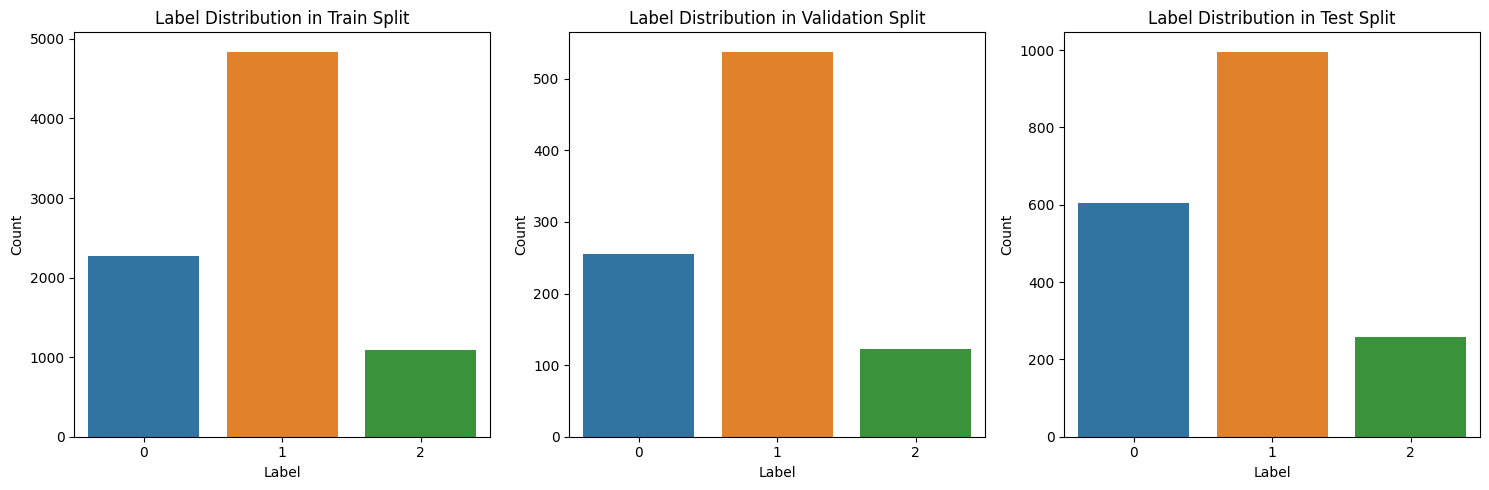

In [ ]:
splits = ['train', 'validation', 'test']

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, split in enumerate(splits):
    labels = [example['label'] for example in dataset[split]]
    # Here I count the occurrence of each label thanks to counter, imported from collections
    label_counts = Counter(labels)

    df = pd.DataFrame({'label': list(label_counts.keys()), 'count': list(label_counts.values())})
    sns.barplot(x='label', y='count', data=df, ax=axs[i])

    axs[i].set_title(f'Label Distribution in {split.capitalize()} Split')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

# Below is to adjust padding
plt.tight_layout()
plt.show()

As stated above, the distribution of labels is consistent within the splits.

Now, let's inspect the missing values from the dataset.

According to how the dataset has been created, <b>NaN</b> values are not present in the huggingface version. Thus, in order to have a grasp of which columns present missing values, and how many of them we have to deal with, we should made a simple conversion from "", or " ", to np.nan.</br>Then, we plot a mtrix like representation of missing values for each of the splits.

Missing values in Train: 587
Missing values in Train Split:
Missing values in Validation: 71
Missing values in Validation Split:
Missing values in Test: 66
Missing values in Test Split:


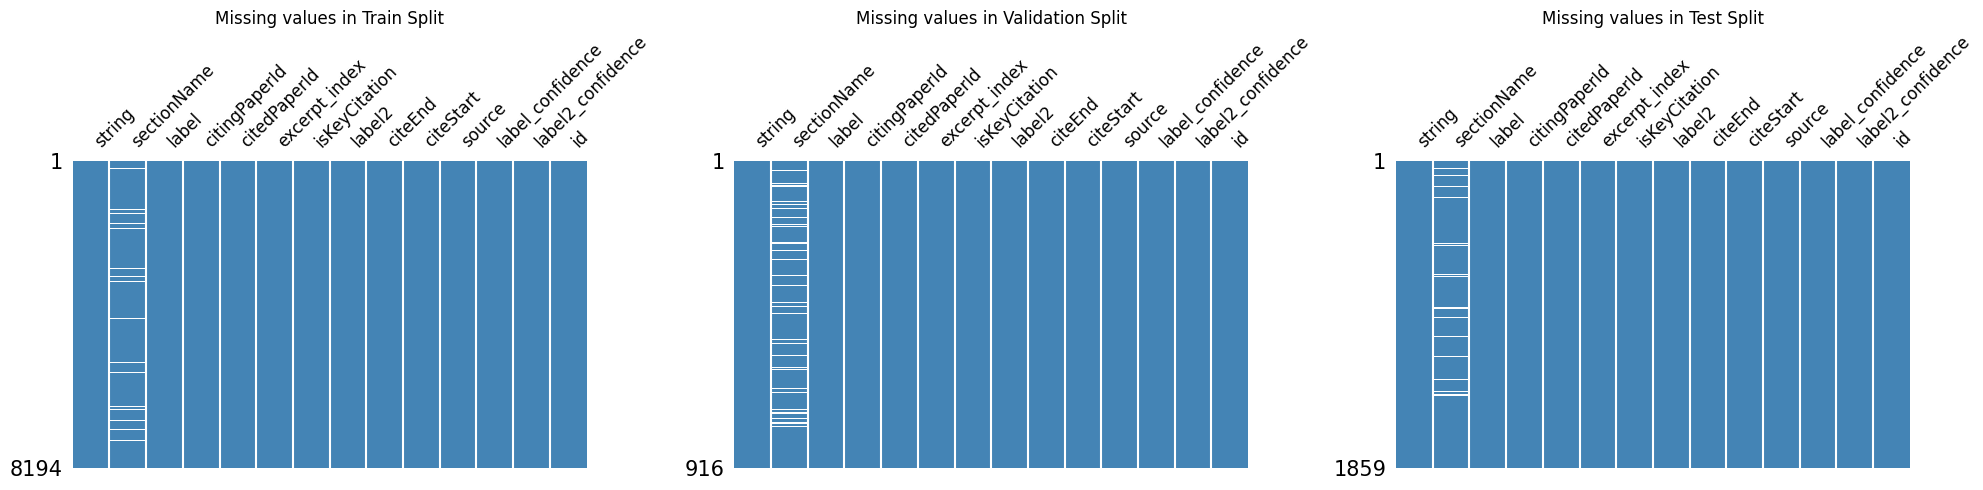

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, split in enumerate(splits):
    df = pd.DataFrame(dataset[split])
    # Conversion of empty cells into np.nan
    df.replace({"": np.nan, " ": np.nan}, inplace=True)
    # Find missing values
    missing_values = df.isna().sum().sum()
    print(f"Missing values in {split.capitalize()}: {missing_values}")
    # Visualizing the missing values with missingno library
    print(f"Missing values in {split.capitalize()} Split:")
    msno.matrix(df, ax=axs[i], sparkline=False, fontsize=12, color=(0.27, 0.52, 0.71))
    axs[i].set_title(f'Missing values in {split.capitalize()} Split')

plt.tight_layout()
plt.show()

From this dataset, we are mainly interested in seeing how to deal with string, sectionName, and label columns. All the other information can be discarded because are not useful for the task.

## 2. Brief discussion: PLMs and SOTA

The Citation Intent Classification task has been studied intensively, and the current state of the art is a Macro-F1 score of 88.93 obtained with an XLNet based model ([SOTA page](https://paperswithcode.com/sota/citation-intent-classification-on-scicite)). Other methodologies, like embedding based analyses, together with LSTM based approaches, show a much lower performance.

As you can imagine, the task can be tackled from very different perspectives, we could use prompt-tuning, fine-tuning, zero-shot, few-shot, sentence-transformer based similarity, and so on... But, for the aim of this project, I'd like to go deeper on the scores we can obtain by using an ensemble based approach, and see whether or not it will outperform the scores obtained with task specific fine-tuning. Additionally, I'd like to investigate the impact that a mix of feature and prompt engineering, correctly applied to these PLMs could have.

In order to move our first steps into the task, we must first decide which model we would like to use. To make such decision, I have a list of candidate PLMs.

The models I will take into consideration are the following:
- <b>SciBERT</b>: A BERT based model trained on a corpus of scientific texts. Its main advantages is its good understanding of the scientific domain and the SciVocab, a newly designed vocabulary containing a great number of terms from the scientific literature - [Reference Paper](https://arxiv.org/abs/1903.10676);
- <b>XLNet</b>: A model presenting an evolution of the way in which LMs are trained for Language Understanding tasks. As said before, it is also the current base-model of SOTA results for this task - [Reference Paper](https://arxiv.org/abs/1906.08237);
- <b>Galactica</b>: A big open source science based language model from META. It is a controversial model for the results it has obtained in text generation tasks, but it is now back on track - [Reference Paper](https://arxiv.org/abs/2211.09085).

Each of these models could be particularly suited for the task.

## 3. Galactica Fine-Tuning
In this section, I will tackle the problem with the raw fine-tuning of the Galactica small model on the SciCite dataset.

Fine tuning is an approach that involves changing the weights of the PLM to adapt it to a new task. Additionally, the process involves the use of a classification head in this specific case. Such head is useful to classify, by means of the logits of the model, its answers into either one of the three possible classes.

For this part, I will solely rely on Huggingface for fine tuning and Ray Tune for hyperparameter optimization.

Below, you can see and inspect Galactica configuration.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, XLNetForSequenceClassification

ckp = "facebook/galactica-125m"#"facebook/galactica-1.3b" # CON 1.3B è pesantissimo, infattibile con PBT
model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3)

# Adjust the output layer to 3 classes
#model.logits_proj = torch.nn.Linear(768, 3)

model.to(device)

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/250M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OPTForSequenceClassification(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50000, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): GELUActivation()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_nor

In [ ]:
for layer in model.named_modules():
    print(layer)

('', OPTForSequenceClassification(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50000, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): GELUActivation()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_laye

#### 3.a) Tokenization and Model download

The tokenization part is mostly carried out by the AutoTokenizer object of  Huggingface. What we need to do is simply load the tokenizer we want to use, and then define a mapping function to the dataset.

For what concerns the model download, the same is true. We can easily rely on huggingface to download the model we want to use, and add a mapping from labels to numerical values of them.

#### 3.b) Ray Tune for HP optimization

To optimize the search in the HP space, we will make use of ray tune library. This library gives us the possibility to define in high details the way in which we want to perform such search.

<b><u>"Unfortunately", seen the dimension of these PLMs, I will need to define each of the steps I am describing inside a single function, otherwise Ray Tune wouldn't be able to correctly handle GPU RAM.</b></u>

For what concerns the task specific Fine-Tuning, I would like to make use of some prompt and feature engineering on the sentences that the model will need to classify. Additionally, I will implement a Population Based Search for HP optimization.

The main HP I will deal with are the following:
- Learning Rate;
- Weighted loss or non-weighted loss (since the dataset is higly imbalanced, a weighted loss could, or not, help);
- Weight decay for the optimizer;
- Batch size.

Additionally, these models are highly sensible to weights initialization and data order, which may result in drastically different performances, as stated in [Fine-Tuning Pretrained Language Models:
Weight Initializations, Data Orders, and Early Stopping](https://arxiv.org/pdf/2002.06305v1.pdf). Thus, searching also through the seeds could be a good idea but, for memory and efficiency requirements, I will manually set a pre-defined seed.

#### 3.c) Training loop

Inside the main function, that you will see below, I have implemented a particular training loop.

This is not the standard training suggested for PLMs fine tuning (which is way less flexible...), I have implemented an early stopping condition to deal with the fact that such PLMs heavily tends to overfit. Moreover, since the problem of overfitting is real, I will save the model with the best generalization performance in terms of validation loss at each step, to finally retrieve the best performing overall.

Additionally, seen that PLMs need really low learning rate values in their fine tuning, they risk many times to get stuck. Thus, instead of opting for a linear decrease of the learning rate through epochs, I found way better results with a static reduction of the learning rate when the model gets stuck in a plateau.

Since the number of epochs needed for PLMs is relatively low (around 5 epochs at most, or they will for sure overfit...), I have decided to add a fine-grained evaluation of generalization performances. This means that the model will look into validation data more than once during each epoch, and these data are used to implement LR reduction and Early Stopping.

Finally, to speed up the fine tuning process, I have used mixed precision training thanks to Autocast and GradScaler. The former is useful to perform forward and backward passes at half precision (float16 instead of float32), thus reducing memory requirements and speeding up the process, while the latter serves to purpose of mitigating numerical instability issues due to the half precision. With this strategy, we are in the end able to obtain more or less the same results but with a significantly lower use of resources and with a training that requires less than a half of the time that a normal loop would need.

#### 3.d) Implementation

Below I implement and describe through comments all the steps I have discussed above.

In [ ]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from ray import tune, train
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import tempfile
from ray.train import Checkpoint


def train_model(config):
    dataset = load_dataset("allenai/scicite", trust_remote_code=True)

    # Use config from ray Tune
    ckp = config["model_ckp"]
    loss_balance = config["loss_balance"]
    seed = config["seed"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    ray_checkpoint_interval = config['ray_checkpoint_interval']
    tokens_max_length = config["tokens_max_length"]

    # Here I define the mapping from numerical to string labels, and viceversa
    # This is useful for Huggingface automodel
    id2label = {0: "method", 1: "background", 2: "result"}
    label2id = {"method": 0, "background": 1, "result": 2}

    # Download the model from the checkpoint of SciBERT, and move it on GPU
    model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

    """# Freeze the first three layers in the model.decoder.layers
    for layer_index in range(3):  # Layer indices 0, 1, 2
        for param in model.model.decoder.layers[layer_index].parameters():
            param.requires_grad = False"""

    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()

    # Load SciBERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ckp)
    tokenizer.pad_token_id = 1

    # The function below defines the tokenization process
    def tokenize_function(examples):
        augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
        tokenized = tokenizer(augmented, max_length=tokens_max_length, padding='max_length', truncation=True)
        tokenized['augmented'] = augmented
        return tokenized

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id', 'token_type_ids'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Define train and validation sets according to the standard splits
    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    # Define the dataloaders
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=128)

    # It is good norm to not applying weight decay to the following two layers if present
    # I will check if they are in the model and in case set their weight decay to 0
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    # Define the optimizer and the scheduler
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.75, min_lr=8e-7, cooldown=2, verbose=True)

    batch_counter = 0
    # Accumulation steps are only useful if the GPU is not sufficiently big,
    # in this case I leave it to 1, so it is like if it is not here
    accumulation_steps = 1
    validation_interval = ray_checkpoint_interval
    step_counter = 0
    evaluation_counter = 0

    # Set extreme values to have checkpointing
    best_val_loss = float('inf')
    best_val_f1 = float('-inf')

    scaler = GradScaler()

    no_improvement = 0
    early_stopping_patience = 8 # Number of evaluations without performance improvement before stopping

    start_epoch = 0
    last_batch_index = 0

    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        print("GETTING BACK CHECKPOINT AFTER PAUSED TRAINING")
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        step_counter = checkpoint_dict["step"]
        best_val_loss = checkpoint_dict["best_val_loss"]
        evaluation_counter = checkpoint_dict["performed_evaluation"]
        scheduler.load_state_dict(checkpoint_dict["scheduler_state_dict"])

        # Give a cooldown step
        no_improvement = checkpoint_dict["no_improvement_steps"]
        if no_improvement >= 1:
            no_improvement-=1

        start_epoch = checkpoint_dict["last_epoch_index"]
        last_batch_index = checkpoint_dict["last_batch_index"]
        print(f"Resuming training from Epoch {start_epoch}, Batch Index: {last_batch_index}")
        metrics = checkpoint_dict["metrics"]

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        optimizer.zero_grad()

        for batch_index, batch in enumerate(train_dataloader):
            if epoch == start_epoch and batch_index < last_batch_index:
                continue  # Skip batches up to checkpoint

            batch = {k: v.to(device) for k, v in batch.items()}
            # Mixed precision below
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            # This below should ensure that the same amount of data has been seen by the model
            # even if it has the smallest batch size (16) between the searched ones.
            # This is useful to have a meaningful comparison of val_loss at the evaluation time,
            # because both bs=32 and bs=16 models should have seen the same amount of data.
            if batch_size==16:
                step_counter += 0.5
            else:
                step_counter += 1

            # Evaluation on Validation data + Ray Checkpoint creation
            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches
                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement = 0
                else:
                    no_improvement += 1

                evaluation_counter += 1

                if no_improvement >= early_stopping_patience:
                    print("No improvement in validation loss for {} evaluations, stopping.".format(early_stopping_patience))
                    train.report(metrics)
                    break

                scheduler.step(val_loss)
                intermediate_train_loss = train_loss/num_train_batches

                metrics = {"training_iteration":step_counter, "performed_evaluation":evaluation_counter, "best_val_loss": best_val_loss, "train_loss":intermediate_train_loss, "current_val_loss":val_loss, "current_val_f1":val_f1}

                # Checkpointing with Ray Tune/Train
                with tempfile.TemporaryDirectory() as tmpdir:
                    torch.save(
                        {
                            "performed_evaluation": evaluation_counter,
                            "step": step_counter,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "best_val_loss": best_val_loss,
                            "no_improvement_steps": no_improvement,
                            "scheduler_state_dict": scheduler.state_dict(),
                            "last_batch_index": batch_index,
                            "last_epoch_index": epoch,
                            "metrics": metrics
                        },
                        os.path.join(tmpdir, "checkpoint.pt"),
                    )
                    train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir)) # tmpdir
                    print(f"Checkpoint stored at Epoch:{epoch}, Batch:{batch_index} - batch size:{batch_size}")

        if no_improvement >= early_stopping_patience:
            break

        train.report(metrics)
        print(f"EPOCH {epoch} finished")


Below I define the configuration, as well as the population based training. Finally, I start the training process, of which you will be able to see the results under the cell.

In [ ]:
seeds = [1482]
"""
For simplicity, here I will consider a single seed, without performing any kind of search.
Normally, the seed do not need to be searched, but, according to https://arxiv.org/pdf/2002.06305v1.pdf
in a LLM, a different weight initialization, and data order, can higly impact the performances of the
fine tuned model.
"""
# After evaluation_interval batches (depending on batch_size, if 32 is 30, if 16 is 60) -> I consider step_counter as time_attr
evaluation_interval = 30

# Define configuration space
config = {
    "num_epochs": 5,
    "batch_size": tune.grid_search([16, 32]),
    "seed": tune.grid_search(seeds),
    "lr": tune.uniform(1e-5, 2e-5), # These are the recommended learning rates for similar tasks
    "weight_decay": tune.uniform(0.02, 0.01), # Weight decay may highly influence the final results
    "model_ckp": ckp,
    "loss_balance": False, #tune.grid_search([True, False]),
    "tokens_max_length": tune.grid_search([256, 312]),
    "ray_checkpoint_interval": evaluation_interval
}

For the population based training, I have defined a perturbation interval every 30 steps. This means that, after 30 evaluations on validation data for each possible model, the worst (also called explorers) will be randomly mutated according to the parameters defined below. Thus, their learning rate, or weight decay, could be changed in the range defined. Additionally, these modified explorers will be re-trained from zero up to 2x number of perturbation interval (so for 60 evaluations), and the process is repeated.

The best performing models, called exploiters, are then modified according to the best performing explorers in a random way. Finally, the worst performing HP are discarded and the ones that gave best results replace them in following iterations.

This process of "evolution" goes on until all the models have completed their training.

Usually, with Population Based Training (PBT), models converge faster and a broader HP search space is explored. Unfortunately, since I am running this on single GPU on Colab platform, the process is pretty slow because training cannot be parallelized.

In [ ]:
from ray.tune.schedulers import PopulationBasedTraining
import ray

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=evaluation_interval*8,
    metric="best_val_loss",
    mode="min",
    #burn_in_period=120.0, # Number of training steps before starting with Exploitation/Exploration process
    quantile_fraction=0.5,
    resample_probability=0.3,
    perturbation_factors=(1.15,0.85),
    hyperparam_mutations={
        "lr": tune.uniform(9e-6, 3e-5),
        "weight_decay": tune.uniform(0.001, 0.03),
    },
    synch=True
)

In [ ]:
import time

start_time = time.time()

if ray.is_initialized():
    ray.shutdown()
ray.init()

# This tune.with_resources is basically the same of resources_per_trial
# So this is allocating 4 CPUs and 30% GPU for trial, making it possible to
# train more model in parallel (Slows a bit the performances but it's ok)
train_model_with_resources = tune.with_resources(train_model, {"cpu": 4, "gpu":0.3})

tuner = tune.Tuner(
    train_model_with_resources, #train_model,
    run_config=train.RunConfig(
        name="Galactica_Mini_PBT",
        stop={"training_iteration": 800}, # a bit more than 3 epochs
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="best_val_loss",
            checkpoint_score_order="min",
            num_to_keep=7,
        ),
        storage_path="/content/tmp/ray_results", #"/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Ray_PBT_Checkpoints", # "/tmp/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2,
    ),
    param_space=config,
)

results_grid = tuner.fit()
end_time = time.time()

2024-01-21 12:48:07,710	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-21 12:48:08,727	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     Galactica_Mini_PBT      |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        PopulationBasedTraining |
| Number of trials                 8                       |
+----------------------------------------------------------+

View detailed results here: /content/tmp/ray_results/Galactica_Mini_PBT
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/Galactica_Mini_PBT`

Trial status: 8 PENDING
Current time: 2024-01-21 12:48:09. Total running time: 0s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |


(train_model pid=8335) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=8335) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizer_config.json: 100%|██████████| 166/166 [00:00<00:00, 950kB/s]
tokenizer.json: 100%|██████████| 2.14M/2.14M [00:00<00:00, 32.5MB/s]
special_tokens_map.json: 100%|██████████| 3.00/3.00 [00:00<00:00, 17.1kB/s]
Map: 100%|██████████| 8194/8194 [00:02<00:00, 3375.59 examples/s]



Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:48:39. Total running time: 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |
+-----------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05         0.0155588             16     1482                   256 |
| train_model_54176_00001   RUNNING    1.78379e-05        0.0142333             32     1482                   256 |
| train_model_54176_00002   RUNNING    1.67033e-05        0.0186582             16     1482                   312 |
| train_model_54176_00003   PENDING    1.11487e-05        0.017502              32     1482                   31

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000000)
(train_model pid=8334) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight'] [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_model pid=8334) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference. [repeated 2x across cluster]
Map: 100%|██████████| 1859/1859 [00:00<00:00, 3994.97 examples/s] [repeated 6x across cluster]


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:29 - batch size:32
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000000)
(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000000)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000001)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:59 - batch size:32
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:49:09. Total running time: 1min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05         

2024-01-21 12:49:11,681	WARNING util.py:202 -- The `on_step_begin` operation took 2.235 s, which may be a performance bottleneck.


(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000001)


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:49:39. Total running time: 1min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05         0.0155588             16     1482                   256       60            7

(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000001)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000002)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:89 - batch size:32


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000002)
2024-01-21 12:49:59,372	WARNING util.py:202 -- The `on_step_begin` operation took 3.798 s, which may be a performance bottleneck.


(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:179 - batch size:16
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:50:09. Total running time: 2min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05        

2024-01-21 12:50:11,977	WARNING util.py:202 -- The `on_step_begin` operation took 2.518 s, which may be a performance bottleneck.
(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000002)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:179 - batch size:16
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:239 - batch size:16 [repeated 2x across cluster]


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000003) [repeated 2x across cluster]
2024-01-21 12:50:35,375	WARNING util.py:202 -- The `on_step_begin` operation took 3.305 s, which may be a performance bottleneck.


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:50:39. Total running time: 2min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05         0.0155588             16     1482                   256      120            1

(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000003)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:239 - batch size:16


(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000004)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


2024-01-21 12:51:09,167	WARNING util.py:202 -- The `on_step_begin` operation took 3.604 s, which may be a performance bottleneck.


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:51:09. Total running time: 3min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05         0.0155588             16     1482                   256      150            15

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000005) [repeated 2x across cluster]


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:179 - batch size:32 [repeated 2x across cluster]


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000005) [repeated 2x across cluster]


(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:359 - batch size:16 [repeated 2x across cluster]
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:51:39. Total running time: 3min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000  

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000006)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000005)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:359 - batch size:16
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000006)


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 12:52:09. Total running time: 4min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.9821e-05         0.0155588             16     1482                   256      210            21

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000007)



Trial train_model_54176_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                           0.0175 |
+---------------------------------------------------------------+


(train_model pid=8334) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=8334) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 2630.39 examples/s]
2024-01-21 12:52:20,427	WARNING util.py:202 -- The `on_step_begin` operation took 0.925 s, which may be a performance bottleneck.
Map: 100%|██████████| 916/916 [00:01<00:00, 794.12 examples/s] 
(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000006)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000007)



Trial train_model_54176_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01395 |
+---------------------------------------------------------------+


(train_model pid=8333) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=8333) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 2072.86 examples/s]



Trial status: 2 PAUSED | 3 RUNNING | 3 PENDING
Current time: 2024-01-21 12:52:39. Total running time: 4min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00002   RUNNING    1.67033e-05        0.0186582             16     1482                   312      210 

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000000)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:29 - batch size:32

Trial train_model_54176_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01243 |
+---------------------------------------------------------------+


(train_model pid=8335) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=8335) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000007)
Map: 100%|██████████| 1859/1859 [00:00<00:00, 5548.04 examples/s]


(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000000)
(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000001)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:59 - batch size:32

Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:53:09. Total running time: 5min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00003   RUNNING    1.11487

(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000000)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:29 - batch size:32


(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000002) [repeated 2x across cluster]


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:89 - batch size:32 [repeated 2x across cluster]
Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:53:39. Total running time: 5min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_541

(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000001)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:59 - batch size:32
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000002)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:54:09. Total running time: 6min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00003   RUNNING    1.11487e-05        0.017502              32     1482                   312       90   

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000003)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:119 - batch size:32


(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000002)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:89 - batch size:32
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:239 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000003)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:54:39. Total running time: 6min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00003   RUNNING    1.11487e-05        0.017502              32     1482                   312      120  

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000004)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000003)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:119 - batch size:32
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000004)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:55:09. Total running time: 7min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00003   RUNNING    1.11487e-05        0.017502              32     1482                   312      150   

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000005)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000004)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:149 - batch size:32
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000005)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:55:39. Total running time: 7min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00003   RUNNING    1.11487e-05        0.017502              32     1482                   312      180  

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000006)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000005)


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:179 - batch size:32
Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 12:56:09. Total running time: 8min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00003   RUNNING    1.11487

(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000006)



Trial train_model_54176_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00006 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01775 |
+---------------------------------------------------------------+


(train_model pid=8335) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000006) [repeated 2x across cluster]


(train_model pid=8335) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=8334) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=8334) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1859/1859 [00:05<00:00, 346.80 examples/s] 



Trial status: 4 PAUSED | 3 RUNNING | 1 PENDING
Current time: 2024-01-21 12:56:39. Total running time: 8min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00004   RUNNING    1.70959e-05        0.0139534             16     1482                   256      210 

(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000007)



Trial train_model_54176_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01016 |
+---------------------------------------------------------------+


(train_model pid=8333) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=8333) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000000) [repeated 2x across cluster]


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:59 - batch size:16

Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 12:57:09. Total running time: 9min 1s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING    1.82395e-05        0.0177468       

(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000000)


(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:29 - batch size:32


(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000001)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:119 - batch size:16
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000001)
(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000002)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:179 - batch size:16
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 12:57:40. Total running time: 9min 31s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING    1.82395e-05        0.0177468      

(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000002)
(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000003)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:119 - batch size:32


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000003)


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 12:58:10. Total running time: 10min 1s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING    1.82395e-05        0.0177468             16     1482                   312      120           101.808            

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000004)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000004)
2024-01-21 12:58:35,284	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.585 s, which may be a performance bottleneck.
2024-01-21 12:58:35,288	WARNING util.py:202 -- The `process_trial_result` operation took 2.590 s, which may be a performance bottleneck.
2024-01-21 12:58:35,290	WARNING util.py:202 -- Processing trial results took 2.591 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-01-21 12:58:35,291	WARNING util.py:202 -- The `process_trial_result` operation took 2.593 s, which may be a performance bottleneck.


(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000005)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:359 - batch size:16
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 12:58:40. Total running time: 10min 31s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING    1.82395e-05        0.0177468     

(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000005)
(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000006)


(train_model pid=8334) Checkpoint stored at Epoch:0, Batch:419 - batch size:16
(train_model pid=8333) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000006)


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 12:59:14. Total running time: 11min 5s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING    1.82395e-05        0.0177468             16     1482                   312      210            162.935           

(train_model pid=8334) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000007)
2024-01-21 12:59:29,277	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 54176_00001 (score = -0.369593) into trial 54176_00003 (score = -0.384342)

2024-01-21 12:59:29,279	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial54176_00003:
lr : 1.7837940675895907e-05 --- (* 0.85) --> 1.516224957451152e-05
weight_decay : 0.014233270461564994 --- (* 1.15) --> 0.016368261030799743

2024-01-21 12:59:29,282	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 54176_00001 (score = -0.369593) into trial 54176_00005 (score = -0.383725)

2024-01-21 12:59:29,283	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyper


Trial train_model_54176_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.02146 |
+---------------------------------------------------------------+


(train_model pid=11634) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=8333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=11634) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11634) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=11634) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING

Trial train_model_54176_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01423 |
+---------------------------------------------------------------+


(train_model pid=11706) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000007)



Trial train_model_54176_00002 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00002 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01866 |
+---------------------------------------------------------------+


(train_model pid=11785) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=11706) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11706) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 12:59:44. Total running time: 11min 35s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.41978e-05        0.0214569             16     1482                   312      240

(train_model pid=11785) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11785) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=11785) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING [repeated 2x across cluster]
(train_model pid=11634) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=11706) Resuming training from Epoch 0, Batch Index: 239 [repeated 2x across cluster]
(train_model pid=11634) EPOCH 0 finished
(train_model pid=11706) EPOCH 0 finished [repeated 2x across cluster]
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:00:14. Total running time: 12min 5s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss 

(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000008)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000008) [repeated 2x across cluster]
2024-01-21 13:00:35,643	WARNING util.py:202 -- The `on_step_begin` operation took 1.125 s, which may be a performance bottleneck.


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:11 - batch size:32 [repeated 2x across cluster]
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:00:44. Total running time: 12min 35s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_5

(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000009)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:01:14. Total running time: 13min 5s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.4197

(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000009)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:41 - batch size:32


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000010) [repeated 3x across cluster]


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:71 - batch size:32 [repeated 3x across cluster]


2024-01-21 13:01:37,965	WARNING util.py:202 -- The `on_step_begin` operation took 1.937 s, which may be a performance bottleneck.


Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:01:44. Total running time: 13min 35s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.41978e-05        0.0214569             16     1482                   312      330 

(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000010)
(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000011)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:02:14. Total running time: 14min 5s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.419

2024-01-21 13:02:30,330	WARNING util.py:202 -- The `on_step_begin` operation took 2.060 s, which may be a performance bottleneck.
(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000011) [repeated 2x across cluster]


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


2024-01-21 13:02:41,720	WARNING util.py:202 -- The `on_step_begin` operation took 1.316 s, which may be a performance bottleneck.
(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:131 - batch size:32


(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:02:44. Total running time: 14min 35s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.41

(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000012)
2024-01-21 13:03:05,218	WARNING util.py:202 -- The `on_step_begin` operation took 3.311 s, which may be a performance bottleneck.
(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:161 - batch size:32
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 13:03:14. Total running time: 15min 5s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00000   RUNNING    1.419

2024-01-21 13:03:17,907	WARNING util.py:202 -- The `on_step_begin` operation took 2.662 s, which may be a performance bottleneck.


(train_model pid=11706) No improvement in validation loss for 8 evaluations, stopping.

Trial train_model_54176_00001 completed after 420 iterations at 2024-01-21 13:03:17. Total running time: 15min 9s
+--------------------------------------------------+
| Trial train_model_54176_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          3.6484 |
| time_total_s                             460.099 |
| training_iteration                           420 |
| best_val_loss                            0.36959 |
| current_val_f1                           0.83735 |
| current_val_loss                         0.39696 |
| performed_evaluation                          14 |
| train_loss                               0.24336 |
+--------------------------------------------------+


(train_model pid=11706) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000007)



Trial train_model_54176_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_54176_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ...ok/galactica-125m |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01637 |
+---------------------------------------------------------------+


(train_model pid=11706) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11706) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11706) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11634) Epoch 00015: reducing learning rate of group 0 to 1.2528e-05.
(train_model pid=11634) Epoch 00015: reducing learning rate of group 1 to 1.2528e-05.
(train_model pid=11706) Resuming training from Epoch 0, Batch Index: 239
(train_model pid=11785) Epoch 00015: reducing learning rate of group 1 to 1.2528e-05. [repeated 2x across cluster]
(train_model pid=11706) EPOCH 0 finished


(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0156_2024-01-21_12-48-08/checkpoint_000014)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial status: 3 RUNNING | 1 TERMINATED | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 13:03:48. Total running time: 15min 39s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_0

(train_model pid=11634) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0187_2024-01-21_12-48-08/checkpoint_000014)
(train_model pid=11634) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11634) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
(train_model pid=11634) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


2024-01-21 13:03:59,169	WARNING util.py:202 -- The `on_step_begin` operation took 0.968 s, which may be a performance bottleneck.



Trial train_model_54176_00002 completed after 450.0 iterations at 2024-01-21 13:04:01. Total running time: 15min 52s
+--------------------------------------------------+
| Trial train_model_54176_00002 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         8.30728 |
| time_total_s                             532.362 |
| training_iteration                           450 |
| best_val_loss                            0.37134 |
| current_val_f1                           0.83415 |
| current_val_loss                         0.45905 |
| performed_evaluation                          15 |
| train_loss                               0.24053 |
+--------------------------------------------------+
(train_model pid=11785) No improvement in validation loss for 8 evaluations, stopping.
(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:11 - batch size:32
Trial train_model_54176_000

(train_model pid=11785) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0142_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000008)


(train_model pid=11634) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=11785) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11785) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=11634) EPOCH 0 finished
(train_model pid=11785) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=11785) Resuming training from Epoch 0, Batch Index: 239


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000009)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:41 - batch size:32
(train_model pid=11785) EPOCH 0 finished

Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 13:04:18. Total running time: 16min 9s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000008)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000008)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:11 - batch size:32
Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 13:04:48. Total running time: 16min 39s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_000

(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000009) [repeated 2x across cluster]


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:85 - batch size:16 [repeated 2x across cluster]
(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:41 - batch size:32


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000009)
(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000011)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:101 - batch size:32
Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 13:05:18. Total running time: 17min 9s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_000

(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:71 - batch size:32
Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 13:05:48. Total running time: 17min 39s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_000

(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:131 - batch size:32


(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000011)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000011)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:101 - batch size:32


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0175_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:161 - batch size:32
(train_model pid=11785) Epoch 00013: reducing learning rate of group 0 to 1.3378e-05.
(train_model pid=11785) Epoch 00013: reducing learning rate of group 1 to 1.3378e-05.
Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 13:06:18. Total running time: 18min 9s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+---------------------------------------------------------------------------

(train_model pid=11706) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=11706) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11706) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=11706) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:131 - batch size:32


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11706) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=11634) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11706) EPOCH 0 finished
(train_model pid=11634) Checkpoint stored at Epoch:1, Batch:325 - batch size:16

Trial status: 4 TERMINATED | 3 RUNNING | 1 PENDING
Current time: 2024-01-21 13:06:48. Total running time: 18min 39s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0124_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:161 - batch size:32

Trial train_model_54176_00005 completed after 420 iterations at 2024-01-21 13:06:57. Total running time: 18min 48s
+--------------------------------------------------+
| Trial train_model_54176_00005 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         3.64955 |
| time_total_s                              414.83 |
| training_iteration                           420 |
| best_val_loss                            0.36959 |
| current_val_f1                           0.83735 |
| current_val_loss                         0.39696 |
| performed_evaluation                          14 |
| train_loss                               0.24336 |
+--------------------------------------------------+

Trial train_model_54176_00007 started with configuration:
+-------------------------------------------------------

(train_model pid=11785) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0140_2024-01-21_12-48-08/checkpoint_000007)
(train_model pid=11785) Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
(train_model pid=11785) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=11785) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=11785) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=11785) EPOCH 0 finished


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000008)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:25 - batch size:16

Trial status: 5 TERMINATED | 3 RUNNING
Current time: 2024-01-21 13:07:18. Total running time: 19min 9s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00004   RUNNING      1.709

(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000007) [repeated 2x across cluster]



Trial train_model_54176_00004 completed after 450.0 iterations at 2024-01-21 13:07:25. Total running time: 19min 16s
+--------------------------------------------------+
| Trial train_model_54176_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         9.36868 |
| time_total_s                             476.773 |
| training_iteration                           450 |
| best_val_loss                            0.37204 |
| current_val_f1                           0.83373 |
| current_val_loss                         0.47301 |
| performed_evaluation                          15 |
| train_loss                               0.24192 |
+--------------------------------------------------+
(train_model pid=11634) No improvement in validation loss for 8 evaluations, stopping.


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000009)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000008)



Trial status: 6 TERMINATED | 2 RUNNING
Current time: 2024-01-21 13:07:48. Total running time: 19min 39s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING      1.82395e-05        0.0177468             16     1482                   312      300            257.

(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000010)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000009)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000011)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 6 TERMINATED | 2 RUNNING
Current time: 2024-01-21 13:08:18. Total running time: 20min 9s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING      1.82395e-05        0.

2024-01-21 13:08:25,480	WARNING util.py:202 -- The `on_step_begin` operation took 1.252 s, which may be a performance bottleneck.
(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000010)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000011)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
Trial status: 6 TERMINATED | 2 RUNNING
Current time: 2024-01-21 13:08:48. Total running time: 20min 39s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING      1.82395e-05        0

(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
(train_model pid=11706) Epoch 00015: reducing learning rate of group 0 to 1.3680e-05.
(train_model pid=11706) Epoch 00015: reducing learning rate of group 1 to 1.3680e-05.


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000012)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


2024-01-21 13:09:06,795	WARNING util.py:202 -- The `on_step_begin` operation took 1.098 s, which may be a performance bottleneck.


Trial status: 6 TERMINATED | 2 RUNNING
Current time: 2024-01-21 13:09:18. Total running time: 21min 9s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_54176_00006   RUNNING      1.82395e-05        0.0177468             16     1482                   312      420            341.17

(train_model pid=11706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0177_2024-01-21_12-48-08/checkpoint_000014)


(train_model pid=11785) Epoch 00015: reducing learning rate of group 1 to 1.2822e-05. [repeated 2x across cluster]
(train_model pid=11706) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=11785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/Galactica_Mini_PBT/train_model_54176_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0102_2024-01-21_12-48-08/checkpoint_000013)


(train_model pid=11785) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial train_model_54176_00006 completed after 450.0 iterations at 2024-01-21 13:09:25. Total running time: 21min 16s
+--------------------------------------------------+
| Trial train_model_54176_00006 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         6.07124 |
| time_total_s                             368.374 |
| training_iteration                           450 |
| best_val_loss                            0.37129 |
| current_val_f1                           0.83456 |
| current_val_loss                         0.48785 |
| performed_evaluation                          15 |
| train_loss                               0.24162 |
+--------------------------------------------------+
(train_model pid=11706) No improvement in validation loss for 8 evaluations, stopping.


2024-01-21 13:09:29,297	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Trial train_model_54176_00007 completed after 450.0 iterations at 2024-01-21 13:09:29. Total running time: 21min 20s
+--------------------------------------------------+
| Trial train_model_54176_00007 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         5.15349 |
| time_total_s                             413.135 |
| training_iteration                           450 |
| best_val_loss                            0.37204 |
| current_val_f1                           0.83373 |
| current_val_loss                         0.47301 |
| performed_evaluation                          15 |
| train_loss                               0.24192 |
+--------------------------------------------------+

Trial status: 8 TERMINATED
Current time: 2024-01-21 13:09:29. Total running time: 21min 20s
Logical resource usage: 4.0/12 CPUs, 0.3/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------

As you might have noticed, the PBT is not exactly correct: it doesn't re-use models but re-starts training for all models without considering to continue any of them. This is due to the difficulty in providing a working trainable object with this particular train loop.

The positive thing about it is that it ensures HP perturbations and that it maintains only the best performing HP.

#### 3.e) Performance assessment and evaluation

Extract best model, and print out search results.

In [ ]:
from ray.train import Result

# Function to convert elapsed time in seconds to minutes and seconds
def convert_seconds_to_minutes_seconds(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return minutes, remaining_seconds

elapsed_time = end_time - start_time  # Calculate the elapsed time
minutes, seconds = convert_seconds_to_minutes_seconds(elapsed_time)
print(f"Time taken: {minutes} minutes and {seconds} seconds")


num_results = len(results_grid)
print("Number of results:", num_results)
# Check if there have been errors
if results_grid.errors:
    print("At least one of the trials failed!")
else:
    print("No errors!")

# Iterate over results
for i, result in enumerate(results_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a validation loss of:",
        result.metrics["current_val_loss"],
        " and the best validation loss through the training has been:",
        result.metrics["best_val_loss"]
    )


# Get the result with the maximum test set `mean_accuracy`
best_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="min"
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="max"
)

Time taken: 21.0 minutes and 23.749372243881226 seconds
Number of results: 8
No errors!
Trial #0 finished successfully with a validation loss of: 0.45904630795121193  and the best validation loss through the training has been: 0.3713444843888283
Trial #1 finished successfully with a validation loss of: 0.39696215838193893  and the best validation loss through the training has been: 0.36959270760416985
Trial #2 finished successfully with a validation loss of: 0.45904630795121193  and the best validation loss through the training has been: 0.3713444843888283
Trial #3 finished successfully with a validation loss of: 0.39696215838193893  and the best validation loss through the training has been: 0.36959270760416985
Trial #4 finished successfully with a validation loss of: 0.47300637140870094  and the best validation loss through the training has been: 0.3720351904630661
Trial #5 finished successfully with a validation loss of: 0.39696215838193893  and the best validation loss through the 

In [ ]:
print("Best model - final configuration after HP perturbations:\n")
tokenizer_length = best_result.config['tokens_max_length']
best_result.config

Best model - final configuration after HP perturbations:



{'num_epochs': 5,
 'batch_size': 32,
 'seed': 1482,
 'lr': 1.7837940675895907e-05,
 'weight_decay': 0.014233270461564994,
 'model_ckp': 'facebook/galactica-125m',
 'loss_balance': False,
 'tokens_max_length': 256,
 'ray_checkpoint_interval': 30}

<Figure size 30000x15000 with 0 Axes>

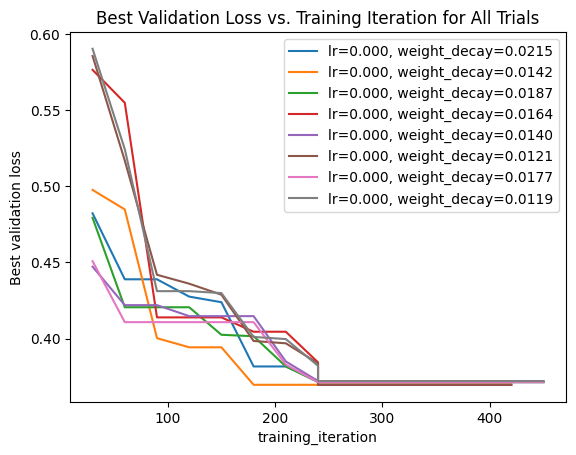

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 150))

ax = None
for result in results_grid:
    label = f"lr={result.config['lr']:.3f}, weight_decay={result.config['weight_decay']:.4f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "best_val_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "best_val_loss", ax=ax, label=label)

ax.set_title("Best Validation Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Best validation loss")
plt.show()  # Display the plot

In [ ]:
# Load the best fine tuned model and move it to GPU
id2label = {0: "method", 1: "background", 2: "result"}
label2id = {"method": 0, "background": 1, "result": 2}

best_model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model_state_dict = checkpoint['model_state_dict']  # Extract only the model's state dictionary
    best_model.load_state_dict(model_state_dict)

best_model = best_model.to(device)

full_model_path = "/content/drive/MyDrive/Models/Galactica_Models/Galactica_Small/FT/Galactica_mini_ft.pt"
torch.save(best_model.state_dict(), full_model_path)

print(f"Model saved to {full_model_path}")

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to /content/drive/MyDrive/Models/Galactica_Models/Galactica_Small/FT/Galactica_mini_ft.pt


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)
tokenizer.pad_token_id = 1

def tokenize_function(examples):
    augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=tokenizer_length, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id', 'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
# Test dataset and dataloader
test_dataset = tokenized_datasets["test"]
eval_dataloader = DataLoader(test_dataset, batch_size=64)

In [ ]:
###############################################################################
########################### Performance assessment ############################
###############################################################################
from tqdm.auto import tqdm

predictions_list = []
labels_list = []

best_model.eval() # Set the model to evaluation mode
test_loss = 0.0
num_test_batches = 0

test_progress_bar = tqdm(eval_dataloader, desc="Evaluating on Test Set")

with torch.no_grad():  # Disable gradient computation
    for batch in test_progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = best_model(**batch)
        loss = outputs.loss

        test_loss += loss.item()
        num_test_batches += 1

        # Store predictions and labels
        preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
        predictions_list.extend(preds)
        labels_list.extend(batch["labels"].cpu().numpy())

        test_progress_bar.set_postfix({"loss": loss.item()})

test_loss /= num_test_batches

print(f"Test Loss: {test_loss:.4f}")

# Calculate F1 score and accuracy using the stored predictions and labels
test_f1 = f1_score(labels_list, predictions_list, average="macro")
test_f1_none = f1_score(labels_list, predictions_list, average=None)
test_acc = accuracy_score(labels_list, predictions_list)

print(f"Test F1: {test_f1:.4f}, Test_f1_None: {test_f1_none} Test Acc: {test_acc:.4f}")
#was 85.63 macro-f1

Evaluating on Test Set:   0%|          | 0/30 [00:00<?, ?it/s]

Test Loss: 0.3180
Test F1: 0.8627, Test_f1_None: [0.8762072  0.89507708 0.81690141] Test Acc: 0.8774


## 4. Ensemble model

#### 4.a) Introduction to the methodology

In order to develop an ensemble model we first need to produce some base models capable of carrying out a part of the entire classification task. To this aim, I will build three different binary classifiers, each of which trained in recognizing whether a specific sentence can or cannot be classified as being part of a specific class.

In the end, I will obtain three binary classifiers:
- Background based model: aimed at correctly classifying whether a sentence is of type background or not;
- Method based model: aimed at correctly classifying whether a sentence is of type method or not;
- Result based model: aimed at correctly classifying whether a sentence is of type result or not.

Once I have the final predictions made by the models, I will use them as input to an ensemble classifier, for which I will inspect different possibilities.

#### 4.b) Base functions

Here, I define the basic functions useful to map labels to their binary counterpart.

In [ ]:
def background_transform_labels(example):
    if example['label'] == 1:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 2]:
        example['label'] = 0  # 'no'
    return example

def method_transform_labels(example):
    if example['label'] == 0:
        example['label'] = 1  # 'yes'
    elif example['label'] in [1, 2]:
        example['label'] = 0  # 'no'
    return example

def result_transform_labels(example):
    if example['label'] == 2:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 1]:
        example['label'] = 0  # 'no'
    return example

Now, we need a training loop for these binary classifiers we aim at building. For these base models, I will not make use of Hyperparameter search strategies. The loop below is based on the same theoretical information given above (scaled, fine-grained eveluation...).

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

def train_model(model, class_weights_tensor, train_dataloader, val_dataloader, model_path):
    loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Replace StepLR with ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.2, cooldown=8, verbose=True)

    num_epochs = 5
    batch_counter = 0
    accumulation_steps = 1
    validation_interval = 10
    step_counter = 0

    best_val_loss = float('inf')
    best_model_path = model_path # 'background_model_loss.pt'
    best_val_f1 = float('-inf')
    #best_model_f1_path = 'background_model_f1.pt'

    # For mixed precision training
    scaler = GradScaler()

    # For early stopping
    no_improvement = 0
    early_stopping_patience = 50  # Number of evaluations with no improvement after which training will be stopped

    for epoch in range(num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        optimizer.zero_grad()

        for batch in epoch_progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Use autocast for mixed precision
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Use scaler for backward
            scaler.scale(loss).backward()

            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            epoch_progress_bar.set_postfix({"train_loss": train_loss / num_train_batches})

            step_counter += 1

            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        # Use autocast for mixed precision
                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches

                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")
                val_acc = accuracy_score(val_labels_list, val_predictions_list)

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    #torch.save(model_background.state_dict(), best_model_f1_path)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= early_stopping_patience:
                        print("No improvement in validation loss for {} steps, stopping.".format(early_stopping_patience))
                        break

                scheduler.step(val_loss)

                print(f"Step {step_counter}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
                print(f"Best Val Loss: {best_val_loss:.4f}")
                print(f"Best Val Macro-F1: {best_val_f1:.4f}")

                model.train()

        if no_improvement >= early_stopping_patience:
            break

        train_loss /= num_train_batches

        train_f1 = f1_score(train_labels_list, train_predictions_list, average="macro")
        train_acc = accuracy_score(train_labels_list, train_predictions_list)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}")

Finally, I write a function to compute class weights.

In [ ]:
def compute_weight_tensor(tokenized_datasets):
    label_counts = Counter(tokenized_datasets['train']['label'])
    # Calculate weights
    class_weights = {k: 1.0 / v for k, v in label_counts.items()}
    # Normalize weights such that the sum of weights equals the number of classes
    total_weights = sum(class_weights.values())
    class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}
    # Transform the dict to a tensor and give it to device
    class_weights_tensor = torch.tensor([class_weights[i] for i in [0, 1]], dtype=torch.float).to(device)
    return class_weights_tensor

Now, we can go inside the specificity of each particular binary classifiers, each of which will make use of different weight for loss balance, and will work on different dataloaders.

#### 4.c) Base models

The operations for each model will be basically the same but with different objects and computations. Thus, I will explain them in detail only for their first appeareance.

First of all, let's download the dataset again and set the GPU device.

In [ ]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

if torch.cuda.is_available():
    print('cuda')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for allenai/scicite contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/allenai/scicite
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


cuda


Let's map the labels to the binary case thanks to the functions defined in the previous section.

In [ ]:
background_datasets = dataset.map(background_transform_labels)
method_datasets = dataset.map(method_transform_labels)
result_datasets = dataset.map(result_transform_labels)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Now, let's compute all the weights to balance the loss function.

In [ ]:
background_weight_tensor = compute_weight_tensor(background_datasets)
method_weight_tensor = compute_weight_tensor(method_datasets)
result_weight_tensor = compute_weight_tensor(result_datasets)

Now, we can define the various dataloaders. But, before, we write a function to carry on the tokenization part.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)
tokenizer.pad_token_id = 1

def tokenize_function(examples):
    augmented = ['[SECTION]: ' + section + '. [CITATION]: ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_dataloader(dataset, batch_size, seed=None):
    if seed is not None:
        set_seed(seed)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id', 'token_type_ids'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader

batch_size = 32
random_seed = 1482

background_train_dataloader, background_val_dataloader = prepare_dataloader(background_datasets, batch_size, seed=random_seed)
method_train_dataloader, method_val_dataloader = prepare_dataloader(method_datasets, batch_size, seed=random_seed)
result_train_dataloader, result_val_dataloader = prepare_dataloader(result_datasets, batch_size, seed=random_seed)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

It is important to notice that I will not use at all the test set with the base models. The first time the test set will be used is with the ensemble classifier.

##### <b>Background model</b>

Now, it is time to define the base models I will use for the ensemble classifier. Let's start with the Background model.

The steps will be the same for each model, so I will not repeat what I do.

The main part consists of a mapping between integer and literal labels. Such map must be fed to the PLM I will use, during the loading.

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_background = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_background = model_background.to(device)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we can procede with the training. In order to do that, I will use the above defined training loop function.

In [ ]:
train_model(model_background, background_weight_tensor, background_train_dataloader, background_val_dataloader, "background_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.5315, Val F1: 0.7110, Val Acc: 0.7282
Best Val Loss: 0.5315
Best Val Macro-F1: 0.7110
Step 20, Val Loss: 0.4604, Val F1: 0.7753, Val Acc: 0.7828
Best Val Loss: 0.4604
Best Val Macro-F1: 0.7753
Step 30, Val Loss: 0.4600, Val F1: 0.8069, Val Acc: 0.8122
Best Val Loss: 0.4600
Best Val Macro-F1: 0.8069
Step 40, Val Loss: 0.4012, Val F1: 0.8182, Val Acc: 0.8242
Best Val Loss: 0.4012
Best Val Macro-F1: 0.8182
Step 50, Val Loss: 0.3860, Val F1: 0.8366, Val Acc: 0.8461
Best Val Loss: 0.3860
Best Val Macro-F1: 0.8366
Step 60, Val Loss: 0.3930, Val F1: 0.8451, Val Acc: 0.8559
Best Val Loss: 0.3860
Best Val Macro-F1: 0.8451
Step 70, Val Loss: 0.3774, Val F1: 0.8467, Val Acc: 0.8537
Best Val Loss: 0.3774
Best Val Macro-F1: 0.8467
Step 80, Val Loss: 0.4360, Val F1: 0.8431, Val Acc: 0.8461
Best Val Loss: 0.3774
Best Val Macro-F1: 0.8467
Step 90, Val Loss: 0.4008, Val F1: 0.8082, Val Acc: 0.8253
Best Val Loss: 0.3774
Best Val Macro-F1: 0.8467
Step 100, Val Loss: 0.3818, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00026: reducing learning rate of group 1 to 4.0000e-06.
Step 260, Val Loss: 0.3731, Val F1: 0.8512, Val Acc: 0.8537
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8599
Step 270, Val Loss: 0.3549, Val F1: 0.8545, Val Acc: 0.8581
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8599
Step 280, Val Loss: 0.3518, Val F1: 0.8580, Val Acc: 0.8624
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8599
Step 290, Val Loss: 0.3618, Val F1: 0.8619, Val Acc: 0.8657
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8619
Step 300, Val Loss: 0.3654, Val F1: 0.8568, Val Acc: 0.8614
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8619
Step 310, Val Loss: 0.3599, Val F1: 0.8561, Val Acc: 0.8614
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8619
Step 320, Val Loss: 0.3637, Val F1: 0.8587, Val Acc: 0.8624
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8619
Step 330, Val Loss: 0.3630, Val F1: 0.8575, Val Acc: 0.8614
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8619
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.3561, Val F1: 0.8605, Val Acc: 0.8646
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 530, Val Loss: 0.3576, Val F1: 0.8640, Val Acc: 0.8679
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 540, Val Loss: 0.3607, Val F1: 0.8630, Val Acc: 0.8668
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 550, Val Loss: 0.3603, Val F1: 0.8629, Val Acc: 0.8668
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Epoch 00056: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00056: reducing learning rate of group 1 to 1.6000e-07.
Step 560, Val Loss: 0.3607, Val F1: 0.8593, Val Acc: 0.8635
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 570, Val Loss: 0.3608, Val F1: 0.8592, Val Acc: 0.8635
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 580, Val Loss: 0.3613, Val F1: 0.8593, Val Acc: 0.8635
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 590, Val Loss: 0.3619, Val F1: 0.8617, Val Acc: 0.8657
Best Val Loss: 0.3408
Best Val Macro-F1: 0.8654
Step 600, Va

##### <b>Method model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_method = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_method = model_method.to(device)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_method, method_weight_tensor, method_train_dataloader, method_val_dataloader, "method_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.4188, Val F1: 0.7984, Val Acc: 0.8275
Best Val Loss: 0.4188
Best Val Macro-F1: 0.7984
Step 20, Val Loss: 0.3630, Val F1: 0.8214, Val Acc: 0.8526
Best Val Loss: 0.3630
Best Val Macro-F1: 0.8214
Step 30, Val Loss: 0.4111, Val F1: 0.7914, Val Acc: 0.8581
Best Val Loss: 0.3630
Best Val Macro-F1: 0.8214
Step 40, Val Loss: 0.3355, Val F1: 0.8269, Val Acc: 0.8526
Best Val Loss: 0.3355
Best Val Macro-F1: 0.8269
Step 50, Val Loss: 0.2938, Val F1: 0.8581, Val Acc: 0.8908
Best Val Loss: 0.2938
Best Val Macro-F1: 0.8581
Step 60, Val Loss: 0.2902, Val F1: 0.8728, Val Acc: 0.8996
Best Val Loss: 0.2902
Best Val Macro-F1: 0.8728
Step 70, Val Loss: 0.2687, Val F1: 0.8746, Val Acc: 0.9050
Best Val Loss: 0.2687
Best Val Macro-F1: 0.8746
Step 80, Val Loss: 0.2725, Val F1: 0.8681, Val Acc: 0.8930
Best Val Loss: 0.2687
Best Val Macro-F1: 0.8746
Step 90, Val Loss: 0.2576, Val F1: 0.8795, Val Acc: 0.9072
Best Val Loss: 0.2576
Best Val Macro-F1: 0.8795
Step 100, Val Loss: 0.2646, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.2621, Val F1: 0.8799, Val Acc: 0.9039
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8799
Step 270, Val Loss: 0.2633, Val F1: 0.8731, Val Acc: 0.8996
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8799
Step 280, Val Loss: 0.2670, Val F1: 0.8811, Val Acc: 0.9050
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 290, Val Loss: 0.2697, Val F1: 0.8768, Val Acc: 0.9028
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 300, Val Loss: 0.2686, Val F1: 0.8737, Val Acc: 0.9007
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 310, Val Loss: 0.2691, Val F1: 0.8787, Val Acc: 0.9039
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 320, Val Loss: 0.2706, Val F1: 0.8807, Val Acc: 0.9039
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 330, Val Loss: 0.2691, Val F1: 0.8799, Val Acc: 0.9050
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 340, Val Loss: 0.2813, Val F1: 0.8610, Val Acc: 0.8941
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8811
Step 350, Val Loss: 0.2803, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.2672, Val F1: 0.8724, Val Acc: 0.9007
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Epoch 00053: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00053: reducing learning rate of group 1 to 1.6000e-07.
Step 530, Val Loss: 0.2664, Val F1: 0.8724, Val Acc: 0.9007
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 540, Val Loss: 0.2661, Val F1: 0.8736, Val Acc: 0.9017
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 550, Val Loss: 0.2657, Val F1: 0.8724, Val Acc: 0.9007
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 560, Val Loss: 0.2656, Val F1: 0.8724, Val Acc: 0.9007
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 570, Val Loss: 0.2658, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 580, Val Loss: 0.2661, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 590, Val Loss: 0.2664, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2531
Best Val Macro-F1: 0.8856
Step 600, Va

##### <b>Result model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_result = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_result = model_result.to(device)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_result, result_weight_tensor, result_train_dataloader, result_val_dataloader, "result_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3141, Val F1: 0.6286, Val Acc: 0.8843
Best Val Loss: 0.3141
Best Val Macro-F1: 0.6286
Step 20, Val Loss: 0.2236, Val F1: 0.8257, Val Acc: 0.9138
Best Val Loss: 0.2236
Best Val Macro-F1: 0.8257
Step 30, Val Loss: 0.2094, Val F1: 0.8118, Val Acc: 0.9290
Best Val Loss: 0.2094
Best Val Macro-F1: 0.8257
Step 40, Val Loss: 0.1958, Val F1: 0.8558, Val Acc: 0.9279
Best Val Loss: 0.1958
Best Val Macro-F1: 0.8558
Step 50, Val Loss: 0.1728, Val F1: 0.8608, Val Acc: 0.9389
Best Val Loss: 0.1728
Best Val Macro-F1: 0.8608
Step 60, Val Loss: 0.2130, Val F1: 0.8524, Val Acc: 0.9236
Best Val Loss: 0.1728
Best Val Macro-F1: 0.8608
Step 70, Val Loss: 0.1802, Val F1: 0.8634, Val Acc: 0.9443
Best Val Loss: 0.1728
Best Val Macro-F1: 0.8634
Step 80, Val Loss: 0.1596, Val F1: 0.8774, Val Acc: 0.9410
Best Val Loss: 0.1596
Best Val Macro-F1: 0.8774
Step 90, Val Loss: 0.1648, Val F1: 0.8720, Val Acc: 0.9389
Best Val Loss: 0.1596
Best Val Macro-F1: 0.8774
Step 100, Val Loss: 0.1546, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.1425, Val F1: 0.8768, Val Acc: 0.9465
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8804
Epoch 00027: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00027: reducing learning rate of group 1 to 4.0000e-06.
Step 270, Val Loss: 0.1734, Val F1: 0.8654, Val Acc: 0.9334
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8804
Step 280, Val Loss: 0.1508, Val F1: 0.8762, Val Acc: 0.9432
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8804
Step 290, Val Loss: 0.1491, Val F1: 0.8647, Val Acc: 0.9410
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8804
Step 300, Val Loss: 0.1467, Val F1: 0.8821, Val Acc: 0.9465
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8821
Step 310, Val Loss: 0.1562, Val F1: 0.8831, Val Acc: 0.9443
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8831
Step 320, Val Loss: 0.1650, Val F1: 0.8819, Val Acc: 0.9432
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8831
Step 330, Val Loss: 0.1604, Val F1: 0.8838, Val Acc: 0.9465
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8838
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.1431, Val F1: 0.8790, Val Acc: 0.9443
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 530, Val Loss: 0.1438, Val F1: 0.8818, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 540, Val Loss: 0.1449, Val F1: 0.8818, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 550, Val Loss: 0.1454, Val F1: 0.8818, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 560, Val Loss: 0.1460, Val F1: 0.8818, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Epoch 00057: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00057: reducing learning rate of group 1 to 1.6000e-07.
Step 570, Val Loss: 0.1454, Val F1: 0.8810, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 580, Val Loss: 0.1456, Val F1: 0.8810, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 590, Val Loss: 0.1459, Val F1: 0.8810, Val Acc: 0.9454
Best Val Loss: 0.1299
Best Val Macro-F1: 0.8881
Step 600, Va

##### <b>Best models</b>

Now, I retrieve and load back all the best models.

In [ ]:
#ckp = "xlnet-base-cased"#"allenai/scibert_scivocab_cased"

# Paths of models checkpoints
background_model_path = "background_model.pt"
method_model_path = "method_model.pt"
result_model_path = "result_model.pt"

# Usual mapping
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

# Load the best fine-tuned models and move them to GPU
background_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
background_model_best.load_state_dict(torch.load(background_model_path))
background_model_best = background_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/Galactica_Models/Galactica_Base/Ensemble_Galactica_Base/"+background_model_path
torch.save(background_model_best.state_dict(), model_path)

method_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
method_model_best.load_state_dict(torch.load(method_model_path))
method_model_best = method_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/Galactica_Models/Galactica_Base/Ensemble_Galactica_Base/"+method_model_path
torch.save(method_model_best.state_dict(), model_path)

result_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
result_model_best.load_state_dict(torch.load(result_model_path))
result_model_best = result_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/Galactica_Models/Galactica_Base/Ensemble_Galactica_Base/"+result_model_path
torch.save(result_model_best.state_dict(), model_path)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/galactica-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 4.d) Ensemble models

In this section, I will play around with some different possibilities for the ensemble classifier. Each of which will be explained in its core parts.

I will start with main ML algorithms, to then move into something more elaborated.

The first step, common to all the methodologies, is the use of the three base models, which won't be re-trained according to the final output, but I decide to use their predictions according to what their original training has produced.

To do so, I define a function to extract the binary predictions.

In [ ]:
from tqdm import tqdm

def generate_predictions(dataloader, model1, model2, model3, device):
    model1 = model1.to(device).eval()
    model2 = model2.to(device).eval()
    model3 = model3.to(device).eval()

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating predictions"):
            input_data = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            out1 = torch.softmax(model1(**input_data).logits, dim=-1)
            out2 = torch.softmax(model2(**input_data).logits, dim=-1)
            out3 = torch.softmax(model3(**input_data).logits, dim=-1)

            # The probabilities predicted for each class, for each model, are stacked
            out = torch.stack([out1, out2, out3], dim=-1)

            all_outputs.append(out)
            all_labels.append(labels)

    # Concatenate all outputs and labels along the batch dimension
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_outputs, all_labels

Now, let's make use of this function to retrieve the base predictions.

In order to do this, we must first define the new dataloaders and class weights.

In [ ]:
# To be sure we have back the original, I load again the dataset
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

In [ ]:
label_counts = Counter(dataset['train']['label'])
class_weights = {k: 1.0 / v for k, v in label_counts.items()}

total_weights = sum(class_weights.values())
class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)
class_weights_tensor

tensor([0.8449, 0.3955, 1.7596], device='cuda:0')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)
tokenizer.pad_token_id = 1

def tokenize_function(examples):
    augmented = ['[SECTION]: ' + section + '. [CITATION]: ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id', 'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In the following snippet, I extract the predictions done by base models. These will be used as input for the ML models I will try on the task.

In [ ]:
base_model_outputs_train = generate_predictions(train_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_val = generate_predictions(val_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_test = generate_predictions(eval_dataloader, background_model_best, method_model_best, result_model_best, device)

Generating predictions: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Let's now set up a train, validation, test split with our data.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the numpy arrays from the datasets
X_train = base_model_outputs_train[0].view(len(base_model_outputs_train[0]), -1).cpu().numpy()
y_train = base_model_outputs_train[1].cpu().numpy()

X_val = base_model_outputs_val[0].view(len(base_model_outputs_val[0]), -1).cpu().numpy()
y_val = base_model_outputs_val[1].cpu().numpy()

X_test = base_model_outputs_test[0].view(len(base_model_outputs_test[0]), -1).cpu().numpy()
y_test = base_model_outputs_test[1].cpu().numpy()

Before moving on, we need to create Dataset and Dataloader objects in order to handle data. These, will be used as input/output providers for our deep learning experiments.

In [ ]:
from torch.utils.data import Dataset

class MetaClassifierDataset(Dataset):
    def __init__(self, outputs, labels):
        self.outputs = outputs.view(len(outputs), -1)  # Flatten the inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.outputs[idx], self.labels[idx]

train_dataset = MetaClassifierDataset(base_model_outputs_train[0], base_model_outputs_train[1])
val_dataset = MetaClassifierDataset(base_model_outputs_val[0], base_model_outputs_val[1])
test_dataset = MetaClassifierDataset(base_model_outputs_test[0], base_model_outputs_test[1])

# I do not build Dataloaders here because I will do it when necessary

#train_dataloader_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_dataloader_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)
#eval_dataloader_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### <b>Confidence based selection</b>

Before getting into ML algorithms, I'd like to try a confidence based selection of the most probable class. To do so, I will make use of the same generate predictions functions, together with a function useful to extract the prediction with higher probability among the others.

Now, let's inspect a single prediction.

In [ ]:
X_test[0]

array([0.898773  , 0.17634209, 0.9970426 , 0.10122697, 0.8236579 ,
       0.00295745], dtype=float32)

For what we can see, the prediction is a 6-elements array, and it has the following structure:

    [background_negative, method_negative, result_negative, background_positive, method_positive, result_positive]

Thus, in order to get the positive predictions, we have to take into consideration the last three elements of the array.

<b><u>Highest score voting</u></b>

What I will do below, is to extract the final result by simply looking at the highest among the three positive predictions. In this way, we will see whether the 3 base BERT work well, and we have a base for a comparison with more advanced algorithms.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def classify_prediction(predictions):
    """
    Takes in the stacked predictions and returns the label of the highest positive predicted value.

    Parameters:
    - predictions (list or numpy array): Stacked predictions of shape
    [background_positive, method_positive, result_positive]

    Returns:
    - int: 0 (for 'method'), 1 (for 'background'), or 2 (for 'result')
    """

    background_positive = predictions[3]
    method_positive = predictions[4]
    result_positive = predictions[5]

    max_index = np.argmax([method_positive, background_positive, result_positive])

    # Use argmax to get the index of the highest positive predicted value
    # the index is consistent with the integer labels, as explained above
    return max_index

# For each sample in X_test, I classify it using the classify_prediction function
predicted_labels = [classify_prediction(X_test[i]) for i in range(X_test.shape[0])]

# Compare predictions and true labels
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')

# Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8795
Macro F1-Score: 0.8606
              precision    recall  f1-score   support

      method       0.93      0.84      0.88       604
  background       0.87      0.92      0.90       996
      result       0.79      0.81      0.80       259

    accuracy                           0.88      1859
   macro avg       0.87      0.86      0.86      1859
weighted avg       0.88      0.88      0.88      1859



As we can see, this simple strategy gives yet good results, producing a macro-F1 score of 86.06%.

Let's now see if we can further improve this score.

##### <b>Random Forest</b>

The first algorithm I will try is Random Forest. To do so, I will make use of a grid search for HP optimization. The HP for which I want to explore different configurations are:
- n_estimators: number of individual decision trees to be included in the random forest ensemble;
- max_depth: determines the maximum depth of each decision tree in the ensemble;
- min_samples_split: specifies the minimum number of samples required to split an internal node of a decision tree;
- min_samples_leaf: determines the minimum number of samples required to be in a leaf node of a decision tree;
- bootstrap: whether to train or not each tree on the entire dataset (it happens with bootstrap=False);
- criterion: the criterion used for node splitting, can be gini imppurity, or entropy;
- class_weight: to see whether adding weights for class imbalance helps or not.

These HP may determine whether the model overfits, underfits, or is sufficiently well adapted to data. Additionally, we should be able to see whether the model has some particular combination that allows it to better adapt to the task at hand.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# Define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=1482)

# Perform grid search with cross-validation
grid_rf = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit="f1_macro", verbose=3)

# Fit the grid search to the training data
grid_rf.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.882) total time=   0.1s
[CV 2/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.892) total time=   0.1s
[CV 3/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.885) total time=   0.1s
[CV 4/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.894) total time=   0.1s
[CV 5/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.860) total time=   0.1s
[CV 1/5] END bootstrap=True, cla

And now, let's check the best performing model on our test set.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

predicted_labels = grid_rf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8704
Macro F1-Score: 0.8512
              precision    recall  f1-score   support

      method       0.93      0.84      0.88       604
  background       0.89      0.88      0.89       996
      result       0.70      0.88      0.78       259

    accuracy                           0.87      1859
   macro avg       0.84      0.87      0.85      1859
weighted avg       0.88      0.87      0.87      1859



As we can see, with the Random Forest algorithm, we haven't reached really good performances...

Let's go on and see if we can improve the score.

##### <b>XGBoost</b>

Now, I will try XGBoost technique, which implements machine learning algorithms under the Gradient Boosting framework. This means it works by combining the results of several weak learners (typically decision trees) into a single strong learner in an iterative fashion.

I will search in the HP space for:
- learning_rate: Also known as the step size. It determines the step size at each iteration while moving toward a minimum loss function. By default, XGBoost sets it to 0.3. Lower values make the optimization more robust, but require more boosting rounds;
- max_depth: The maximum depth of a tree;
- n_estimators: It defines the number of boosting rounds or trees to build.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=1482)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 5, 10],
    'n_estimators': [10, 50, 100],
    'gamma': [0, 0.05, 0.1]
}

# Define scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the grid search object
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid search object to the data
grid_xgb.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.907) total time=   0.0s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.909) total time=   0.0s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.892) total time=   0.0s
[CV 4/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.910) total time=   0.0s
[CV 5/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.871) total time=   0.0s
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.908) total time=   0.1s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.909) total time=   0.1s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.895) total time=   0.1s
[CV 4/5] END gamma

In [ ]:
# The best model is:
model = grid_xgb.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8704
Macro F1-Score: 0.8530
              precision    recall  f1-score   support

      method       0.92      0.83      0.88       604
  background       0.89      0.89      0.89       996
      result       0.73      0.88      0.79       259

    accuracy                           0.87      1859
   macro avg       0.85      0.87      0.85      1859
weighted avg       0.88      0.87      0.87      1859



Not so good...

##### <b>K-Nearest Neighbors</b>

This step involves using KNN algorithm. With this, I operate a grid search only on the number of neighbors.


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Create a K-NN classifier
knn = KNeighborsClassifier() # This time we cannot set a seed, since the KNN is deterministic

# Define the parameter values that should be searched
k_range = list(range(1, 101))

# Create a parameter grid, which maps the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# I define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Instantiate the grid
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid with data
grid_knn.fit(X_train_val, y_train_val)

# View the complete results
print(grid_knn.cv_results_)

# Examine the best model
print("Best score: ", grid_knn.best_score_)
print("Best parameters: ", grid_knn.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ...........n_neighbors=1; f1_macro: (test=0.854) total time=   0.1s
[CV 2/5] END ...........n_neighbors=1; f1_macro: (test=0.866) total time=   0.1s
[CV 3/5] END ...........n_neighbors=1; f1_macro: (test=0.858) total time=   0.1s
[CV 4/5] END ...........n_neighbors=1; f1_macro: (test=0.847) total time=   0.1s
[CV 5/5] END ...........n_neighbors=1; f1_macro: (test=0.835) total time=   0.1s
[CV 1/5] END ...........n_neighbors=2; f1_macro: (test=0.850) total time=   0.1s
[CV 2/5] END ...........n_neighbors=2; f1_macro: (test=0.859) total time=   0.1s
[CV 3/5] END ...........n_neighbors=2; f1_macro: (test=0.837) total time=   0.1s
[CV 4/5] END ...........n_neighbors=2; f1_macro: (test=0.840) total time=   0.1s
[CV 5/5] END ...........n_neighbors=2; f1_macro: (test=0.831) total time=   0.1s
[CV 1/5] END ...........n_neighbors=3; f1_macro: (test=0.881) total time=   0.1s
[CV 2/5] END ...........n_neighbors=3; f1_macr

In [ ]:
# The best model is:
model = grid_knn.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8736
Macro F1-Score: 0.8560
              precision    recall  f1-score   support

      method       0.93      0.84      0.88       604
  background       0.89      0.89      0.89       996
      result       0.72      0.88      0.79       259

    accuracy                           0.87      1859
   macro avg       0.85      0.87      0.86      1859
weighted avg       0.88      0.87      0.87      1859



Still not good.

##### <b>Support Vector Machine</b>

It is now time to try with our last ML algorithm, SVM.
For this, I will operate again a grid search, and this time the HP I will consider are the following:
-

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))


# Define the parameter ranges
param_grid = {
    'C': [0.01, 0.1],
    'gamma': [1, 'scale', 'auto'],
    'kernel': ['rbf', 'sigmoid'], # I exclude linear kernel because hardly could provide good results, I also exclude poly kernel in order to avoid to deal with degree HP
    'class_weight': [None, 'balanced']
}

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
grid_svm = GridSearchCV(SVC(probability=True, random_state=1482), param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit on the data
grid_svm.fit(X_train_val, y_train_val)

# Print the best parameters
print(grid_svm.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.905) total time=   3.1s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.909) total time=   3.2s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.895) total time=   3.1s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.901) total time=   3.1s
[CV 5/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.867) total time=   3.0s
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.903) total time=  10.1s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.910) total time=  10.1s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.893) total time=  10.0s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.905) total time=  1

In [ ]:
# The best model is:
model = grid_svm.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8725
Macro F1-Score: 0.8550
              precision    recall  f1-score   support

      method       0.92      0.86      0.89       604
  background       0.90      0.87      0.89       996
      result       0.70      0.90      0.79       259

    accuracy                           0.87      1859
   macro avg       0.84      0.88      0.85      1859
weighted avg       0.88      0.87      0.87      1859



As you can see, SVM do not reach our top model, so we can procede and analyze DL based strategies.

#### <b>Meta Classifiers</b>

In this section, I will work on different NN architectures. In this case, HP search is manually performed through different tests. This is because I would like to have more control over training loop and get to see if and how something doesn't work. This is not so easy to do with Ray Tune Report. In particular, beside model definition, I will play around learning rate, weight decay and batch size.

The first step implies the definition of 3 main functions: one to plot the training history, one to train the models, and one to evaluate them.

In [ ]:
def set_seed(seed_value=1482):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [ ]:
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.legend()
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.show()

In [ ]:
from torch.optim import lr_scheduler

def train_metaclassifier(meta_classifier, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path):
    set_seed()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []

    early_stopping_counter = 0
    early_stopping_patience = 30
    best_val_loss = float('inf')

    # I will only optimize the parameters of the MetaClassifier, not the other models
    optimizer = AdamW(meta_classifier.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize ReduceLROnPlateau scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, cooldown=5, verbose=True)
    loss_fn = torch.nn.CrossEntropyLoss()#weight=class_weights_tensor

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False)
        meta_classifier.train()

        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch_idx, batch in enumerate(progress_bar):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Autocast for mixed precision
            with autocast():
                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

            # Scales the loss, and calls backward() on scaled loss to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales the gradients of optimizer's assigned params in-place and calls
            # optimizer.step() if no infs/NaNs are found in the gradients.
            # Otherwise, optimizer.step() is skipped to avoid stepping on infs/NaNs
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            # Resets gradients
            optimizer.zero_grad()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(inputs))})

        avg_train_loss = train_loss/len(train_dataloader)
        train_f1 = f1_score(train_labels, np.argmax(train_preds, axis=1), average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)
        print(f"\nTraining Loss at end of epoch {epoch}: {avg_train_loss}")
        print(f"Training F1 Score at end of epoch {epoch}: {train_f1}")

        # Evaluate on validation data after each epoch
        meta_classifier.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss/len(val_dataloader)
        val_f1_macro = f1_score(val_labels, np.argmax(val_preds, axis=1), average='macro')

        # Early stopping condition check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0

            # Save the model
            torch.save(meta_classifier.state_dict(), model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")
        else:
            early_stopping_counter += 1

        # Break training loop
        if early_stopping_counter > early_stopping_patience:
            print(f"No improvement in Validation Loss for {early_stopping_patience} epochs. Training stops.")
            break

        val_f1_weighted = f1_score(val_labels, np.argmax(val_preds, axis=1), average=None)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_macro)
        print(f"\nValidation Loss at end of epoch {epoch}: {avg_val_loss}")
        print(f"Validation Macro F1 Score at end of epoch {epoch}: {val_f1_macro}")
        print(f"Validation Weighted F1 Score at end of epoch {epoch}: {val_f1_weighted}")
        scheduler.step(avg_val_loss)

    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')

In [ ]:
def evaluate_metaclassifier(meta_classifier, test_dataset):
    eval_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    loss_fn = torch.nn.CrossEntropyLoss()
    meta_classifier.eval()  # Set the model to evaluation mode
    test_preds = []
    test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for batch in eval_dataloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            outputs = meta_classifier(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss/len(eval_dataloader)
    test_f1_macro = f1_score(test_labels, np.argmax(test_preds, axis=1), average='macro')
    test_f1_weighted = f1_score(test_labels, np.argmax(test_preds, axis=1), average=None)
    test_accuracy = accuracy_score(test_labels, np.argmax(test_preds, axis=1))

    print(f"\nTest Loss: {avg_test_loss}")
    print(f"Test Macro F1 Score: {test_f1_macro}")
    print(f"Test Weighted F1 Score: {test_f1_weighted}")
    print(f"Test Accuracy: {test_accuracy}")

##### <b>Feed Forward NN</b>

The first thing I'd like to try is a simple feed forward NN. In it, I integrate both Batch Normalization and Dropout layers.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()

        self.fc1 = nn.Linear(6, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.gelu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.selu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        x = F.selu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = F.softmax(x, dim=1)

        return x


Epoch 0: 100%|██████████| 65/65 [00:00<00:00, 136.02it/s, training_loss=0.489]



Training Loss at end of epoch 0: 1.1386371044012216
Training F1 Score at end of epoch 0: 0.2548878839377748
New best model saved with validation loss: 1.121176853775978

Validation Loss at end of epoch 0: 1.121176853775978
Validation Macro F1 Score at end of epoch 0: 0.08579454283062153
Validation Weighted F1 Score at end of epoch 0: [0.13089005 0.02169982 0.10479376]


Epoch 1: 100%|██████████| 65/65 [00:00<00:00, 153.74it/s, training_loss=0.597]



Training Loss at end of epoch 1: 1.0849018793839675
Training F1 Score at end of epoch 1: 0.37226718541171017
New best model saved with validation loss: 1.0159584283828735

Validation Loss at end of epoch 1: 1.0159584283828735
Validation Macro F1 Score at end of epoch 1: 0.7926460759300967
Validation Weighted F1 Score at end of epoch 1: [0.8006993  0.83923155 0.73800738]


Epoch 2: 100%|██████████| 65/65 [00:00<00:00, 159.52it/s, training_loss=0.584]



Training Loss at end of epoch 2: 1.0301334720391493
Training F1 Score at end of epoch 2: 0.47991649337355907
New best model saved with validation loss: 0.9373267665505409

Validation Loss at end of epoch 2: 0.9373267665505409
Validation Macro F1 Score at end of epoch 2: 0.8089411103458649
Validation Weighted F1 Score at end of epoch 2: [0.81801126 0.85881207 0.75      ]


Epoch 3: 100%|██████████| 65/65 [00:00<00:00, 158.04it/s, training_loss=0.569]



Training Loss at end of epoch 3: 0.979862157198099
Training F1 Score at end of epoch 3: 0.580194383365965
New best model saved with validation loss: 0.9128124862909317

Validation Loss at end of epoch 3: 0.9128124862909317
Validation Macro F1 Score at end of epoch 3: 0.811285939546809
Validation Weighted F1 Score at end of epoch 3: [0.81923077 0.86100386 0.75362319]


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 156.57it/s, training_loss=0.392]



Training Loss at end of epoch 4: 0.9308955100866464
Training F1 Score at end of epoch 4: 0.6544692535362129
New best model saved with validation loss: 0.8604120165109634

Validation Loss at end of epoch 4: 0.8604120165109634
Validation Macro F1 Score at end of epoch 4: 0.8101526194905758
Validation Weighted F1 Score at end of epoch 4: [0.81835564 0.86210222 0.75      ]


Epoch 5: 100%|██████████| 65/65 [00:00<00:00, 152.18it/s, training_loss=0.399]



Training Loss at end of epoch 5: 0.8929509493020865
Training F1 Score at end of epoch 5: 0.7155044496791582
New best model saved with validation loss: 0.8065197467803955

Validation Loss at end of epoch 5: 0.8065197467803955
Validation Macro F1 Score at end of epoch 5: 0.8174343171555037
Validation Weighted F1 Score at end of epoch 5: [0.80859375 0.86635071 0.77735849]


Epoch 6: 100%|██████████| 65/65 [00:00<00:00, 159.71it/s, training_loss=0.524]



Training Loss at end of epoch 6: 0.8677409786444444
Training F1 Score at end of epoch 6: 0.7601703236059226
New best model saved with validation loss: 0.796934001147747

Validation Loss at end of epoch 6: 0.796934001147747
Validation Macro F1 Score at end of epoch 6: 0.8144071613977939
Validation Weighted F1 Score at end of epoch 6: [0.81695568 0.86507177 0.76119403]


Epoch 7: 100%|██████████| 65/65 [00:00<00:00, 157.32it/s, training_loss=0.663]



Training Loss at end of epoch 7: 0.8502205105928274
Training F1 Score at end of epoch 7: 0.7847234330670112
New best model saved with validation loss: 0.7838107198476791

Validation Loss at end of epoch 7: 0.7838107198476791
Validation Macro F1 Score at end of epoch 7: 0.8212189627246372
Validation Weighted F1 Score at end of epoch 7: [0.81663516 0.86839577 0.77862595]


Epoch 8: 100%|██████████| 65/65 [00:00<00:00, 153.87it/s, training_loss=0.390]



Training Loss at end of epoch 8: 0.8177209496498108
Training F1 Score at end of epoch 8: 0.8156355633763986
New best model saved with validation loss: 0.7835869491100311

Validation Loss at end of epoch 8: 0.7835869491100311
Validation Macro F1 Score at end of epoch 8: 0.8136583440783789
Validation Weighted F1 Score at end of epoch 8: [0.81509434 0.86183575 0.76404494]


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 159.46it/s, training_loss=0.587]



Training Loss at end of epoch 9: 0.8067406012461735
Training F1 Score at end of epoch 9: 0.8321903873647932
New best model saved with validation loss: 0.7711395174264908

Validation Loss at end of epoch 9: 0.7711395174264908
Validation Macro F1 Score at end of epoch 9: 0.8161528987935348
Validation Weighted F1 Score at end of epoch 9: [0.81538462 0.86615679 0.76691729]


Epoch 10: 100%|██████████| 65/65 [00:00<00:00, 151.55it/s, training_loss=0.393]



Training Loss at end of epoch 10: 0.7876795521149269
Training F1 Score at end of epoch 10: 0.837226180151475
New best model saved with validation loss: 0.761916421353817

Validation Loss at end of epoch 10: 0.761916421353817
Validation Macro F1 Score at end of epoch 10: 0.8281814327116926
Validation Weighted F1 Score at end of epoch 10: [0.81679389 0.87559354 0.79215686]


Epoch 11: 100%|██████████| 65/65 [00:00<00:00, 156.12it/s, training_loss=0.502]



Training Loss at end of epoch 11: 0.780661836037269
Training F1 Score at end of epoch 11: 0.8489186352630528
New best model saved with validation loss: 0.7577417343854904

Validation Loss at end of epoch 11: 0.7577417343854904
Validation Macro F1 Score at end of epoch 11: 0.8171905740943434
Validation Weighted F1 Score at end of epoch 11: [0.81663516 0.86512524 0.76981132]


Epoch 12: 100%|██████████| 65/65 [00:00<00:00, 152.10it/s, training_loss=0.349]



Training Loss at end of epoch 12: 0.7635508363063519
Training F1 Score at end of epoch 12: 0.8577293826486286

Validation Loss at end of epoch 12: 0.7578873038291931
Validation Macro F1 Score at end of epoch 12: 0.8128895857773335
Validation Weighted F1 Score at end of epoch 12: [0.80626223 0.86203616 0.77037037]


Epoch 13: 100%|██████████| 65/65 [00:00<00:00, 148.22it/s, training_loss=0.302]



Training Loss at end of epoch 13: 0.7534314173918504
Training F1 Score at end of epoch 13: 0.863284194777972
New best model saved with validation loss: 0.7396305352449417

Validation Loss at end of epoch 13: 0.7396305352449417
Validation Macro F1 Score at end of epoch 13: 0.8230269948644738
Validation Weighted F1 Score at end of epoch 13: [0.80701754 0.87300094 0.7890625 ]


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 155.43it/s, training_loss=0.463]



Training Loss at end of epoch 14: 0.7531561347154471
Training F1 Score at end of epoch 14: 0.8693449239276597
New best model saved with validation loss: 0.7355042472481728

Validation Loss at end of epoch 14: 0.7355042472481728
Validation Macro F1 Score at end of epoch 14: 0.8231970120009517
Validation Weighted F1 Score at end of epoch 14: [0.80776699 0.87276155 0.7890625 ]


Epoch 15: 100%|██████████| 65/65 [00:00<00:00, 158.37it/s, training_loss=0.306]



Training Loss at end of epoch 15: 0.7411169620660635
Training F1 Score at end of epoch 15: 0.8675912926297684

Validation Loss at end of epoch 15: 0.7474592700600624
Validation Macro F1 Score at end of epoch 15: 0.8217818607752744
Validation Weighted F1 Score at end of epoch 15: [0.80626223 0.86981132 0.78927203]


Epoch 16: 100%|██████████| 65/65 [00:00<00:00, 155.42it/s, training_loss=0.527]



Training Loss at end of epoch 16: 0.7431623119574327
Training F1 Score at end of epoch 16: 0.8695813576704282
New best model saved with validation loss: 0.7342105507850647

Validation Loss at end of epoch 16: 0.7342105507850647
Validation Macro F1 Score at end of epoch 16: 0.830133952297261
Validation Weighted F1 Score at end of epoch 16: [0.81422925 0.87617261 0.8       ]


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 155.18it/s, training_loss=0.378]



Training Loss at end of epoch 17: 0.7300584160364592
Training F1 Score at end of epoch 17: 0.8777858456530518
New best model saved with validation loss: 0.7272612974047661

Validation Loss at end of epoch 17: 0.7272612974047661
Validation Macro F1 Score at end of epoch 17: 0.8269784977615853
Validation Weighted F1 Score at end of epoch 17: [0.81335953 0.87873134 0.78884462]


Epoch 18: 100%|██████████| 65/65 [00:00<00:00, 159.05it/s, training_loss=0.615]



Training Loss at end of epoch 18: 0.7325677064748911
Training F1 Score at end of epoch 18: 0.8801920931136799

Validation Loss at end of epoch 18: 0.7381747961044312
Validation Macro F1 Score at end of epoch 18: 0.8237661879620272
Validation Weighted F1 Score at end of epoch 18: [0.80701754 0.87038789 0.79389313]


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 158.17it/s, training_loss=0.527]



Training Loss at end of epoch 19: 0.7261751642593971
Training F1 Score at end of epoch 19: 0.8813324557508029

Validation Loss at end of epoch 19: 0.7379445508122444
Validation Macro F1 Score at end of epoch 19: 0.8255740303594626
Validation Weighted F1 Score at end of epoch 19: [0.80859375 0.87276155 0.7953668 ]


Epoch 20: 100%|██████████| 65/65 [00:00<00:00, 155.89it/s, training_loss=0.546]



Training Loss at end of epoch 20: 0.7213655315912687
Training F1 Score at end of epoch 20: 0.8844339668752443

Validation Loss at end of epoch 20: 0.7293164804577827
Validation Macro F1 Score at end of epoch 20: 0.8244064155128662
Validation Weighted F1 Score at end of epoch 20: [0.81081081 0.87334594 0.7890625 ]


Epoch 21: 100%|██████████| 65/65 [00:00<00:00, 152.11it/s, training_loss=0.290]



Training Loss at end of epoch 21: 0.7101852251933172
Training F1 Score at end of epoch 21: 0.8852023077718728

Validation Loss at end of epoch 21: 0.7338692545890808
Validation Macro F1 Score at end of epoch 21: 0.8262857337151619
Validation Weighted F1 Score at end of epoch 21: [0.80943026 0.87406015 0.7953668 ]


Epoch 22: 100%|██████████| 65/65 [00:00<00:00, 153.71it/s, training_loss=0.509]



Training Loss at end of epoch 22: 0.715225350856781
Training F1 Score at end of epoch 22: 0.8808795609438139

Validation Loss at end of epoch 22: 0.7279739379882812
Validation Macro F1 Score at end of epoch 22: 0.8254456016303214
Validation Weighted F1 Score at end of epoch 22: [0.81310212 0.87417219 0.7890625 ]


Epoch 23: 100%|██████████| 65/65 [00:00<00:00, 153.24it/s, training_loss=0.510]



Training Loss at end of epoch 23: 0.7142176252145034
Training F1 Score at end of epoch 23: 0.8829672798547185

Validation Loss at end of epoch 23: 0.7309979125857353
Validation Macro F1 Score at end of epoch 23: 0.8254456016303214
Validation Weighted F1 Score at end of epoch 23: [0.81310212 0.87417219 0.7890625 ]


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 160.93it/s, training_loss=0.324]



Training Loss at end of epoch 24: 0.7043290138244629
Training F1 Score at end of epoch 24: 0.885424234291957
New best model saved with validation loss: 0.7255152240395546

Validation Loss at end of epoch 24: 0.7255152240395546
Validation Macro F1 Score at end of epoch 24: 0.8303186716576704
Validation Weighted F1 Score at end of epoch 24: [0.81422925 0.87827715 0.79844961]


Epoch 25: 100%|██████████| 65/65 [00:00<00:00, 159.34it/s, training_loss=0.534]



Training Loss at end of epoch 25: 0.7079959676815913
Training F1 Score at end of epoch 25: 0.8852550844154962

Validation Loss at end of epoch 25: 0.7276231646537781
Validation Macro F1 Score at end of epoch 25: 0.8254456016303214
Validation Weighted F1 Score at end of epoch 25: [0.81310212 0.87417219 0.7890625 ]


Epoch 26: 100%|██████████| 65/65 [00:00<00:00, 159.29it/s, training_loss=0.513]



Training Loss at end of epoch 26: 0.7057576436262865
Training F1 Score at end of epoch 26: 0.888924421087994

Validation Loss at end of epoch 26: 0.7285265102982521
Validation Macro F1 Score at end of epoch 26: 0.8271692627686861
Validation Weighted F1 Score at end of epoch 26: [0.81102362 0.87511737 0.7953668 ]


Epoch 27: 100%|██████████| 65/65 [00:00<00:00, 154.60it/s, training_loss=0.537]



Training Loss at end of epoch 27: 0.7035908515636737
Training F1 Score at end of epoch 27: 0.8873898891583684
New best model saved with validation loss: 0.7210793867707253

Validation Loss at end of epoch 27: 0.7210793867707253
Validation Macro F1 Score at end of epoch 27: 0.8327832824218365
Validation Weighted F1 Score at end of epoch 27: [0.81526104 0.88       0.8030888 ]


Epoch 28: 100%|██████████| 65/65 [00:00<00:00, 152.12it/s, training_loss=0.289]



Training Loss at end of epoch 28: 0.6930579809042123
Training F1 Score at end of epoch 28: 0.8904763705153668

Validation Loss at end of epoch 28: 0.7241988331079483
Validation Macro F1 Score at end of epoch 28: 0.8322342733074602
Validation Weighted F1 Score at end of epoch 28: [0.81510934 0.87850467 0.8030888 ]


Epoch 29: 100%|██████████| 65/65 [00:00<00:00, 157.20it/s, training_loss=0.311]



Training Loss at end of epoch 29: 0.6909611738645114
Training F1 Score at end of epoch 29: 0.8923045636090849

Validation Loss at end of epoch 29: 0.7240930274128914
Validation Macro F1 Score at end of epoch 29: 0.8276657462326233
Validation Weighted F1 Score at end of epoch 29: [0.80943026 0.87511737 0.79844961]


Epoch 30: 100%|██████████| 65/65 [00:00<00:00, 157.13it/s, training_loss=0.293]



Training Loss at end of epoch 30: 0.6886622529763442
Training F1 Score at end of epoch 30: 0.8954763249764289

Validation Loss at end of epoch 30: 0.7232066616415977
Validation Macro F1 Score at end of epoch 30: 0.8258486361377623
Validation Weighted F1 Score at end of epoch 30: [0.80924855 0.87464656 0.79365079]


Epoch 31: 100%|██████████| 65/65 [00:00<00:00, 159.53it/s, training_loss=0.414]



Training Loss at end of epoch 31: 0.6905055596278264
Training F1 Score at end of epoch 31: 0.8923567613444415
New best model saved with validation loss: 0.7205983772873878

Validation Loss at end of epoch 31: 0.7205983772873878
Validation Macro F1 Score at end of epoch 31: 0.8225485942533101
Validation Weighted F1 Score at end of epoch 31: [0.81081081 0.87252125 0.78431373]


Epoch 32: 100%|██████████| 65/65 [00:00<00:00, 155.67it/s, training_loss=0.762]



Training Loss at end of epoch 32: 0.7002117753028869
Training F1 Score at end of epoch 32: 0.8906957629721758
New best model saved with validation loss: 0.7121071368455887

Validation Loss at end of epoch 32: 0.7121071368455887
Validation Macro F1 Score at end of epoch 32: 0.8237332725284533
Validation Weighted F1 Score at end of epoch 32: [0.81349206 0.87859129 0.77911647]


Epoch 33: 100%|██████████| 65/65 [00:00<00:00, 157.11it/s, training_loss=0.367]



Training Loss at end of epoch 33: 0.6867069381933946
Training F1 Score at end of epoch 33: 0.8954027935981257

Validation Loss at end of epoch 33: 0.7204824164509773
Validation Macro F1 Score at end of epoch 33: 0.8305868906628572
Validation Weighted F1 Score at end of epoch 33: [0.81510934 0.87977633 0.796875  ]


Epoch 34: 100%|██████████| 65/65 [00:00<00:00, 158.91it/s, training_loss=0.546]



Training Loss at end of epoch 34: 0.6898438251935519
Training F1 Score at end of epoch 34: 0.891422524807631

Validation Loss at end of epoch 34: 0.718694880604744
Validation Macro F1 Score at end of epoch 34: 0.831412666635862
Validation Weighted F1 Score at end of epoch 34: [0.81568627 0.87699531 0.80155642]


Epoch 35: 100%|██████████| 65/65 [00:00<00:00, 157.59it/s, training_loss=0.284]



Training Loss at end of epoch 35: 0.6799349060425391
Training F1 Score at end of epoch 35: 0.8963440486786625

Validation Loss at end of epoch 35: 0.7169729992747307
Validation Macro F1 Score at end of epoch 35: 0.8306577792714576
Validation Weighted F1 Score at end of epoch 35: [0.81212121 0.87985213 0.8       ]


Epoch 36: 100%|██████████| 65/65 [00:00<00:00, 153.08it/s, training_loss=0.355]



Training Loss at end of epoch 36: 0.6819432139396667
Training F1 Score at end of epoch 36: 0.8921006248942893

Validation Loss at end of epoch 36: 0.7167920544743538
Validation Macro F1 Score at end of epoch 36: 0.8233298440861357
Validation Weighted F1 Score at end of epoch 36: [0.80544747 0.8744186  0.79012346]


Epoch 37: 100%|██████████| 65/65 [00:00<00:00, 151.97it/s, training_loss=0.314]



Training Loss at end of epoch 37: 0.6769551368860098
Training F1 Score at end of epoch 37: 0.8975412016090423

Validation Loss at end of epoch 37: 0.7162443548440933
Validation Macro F1 Score at end of epoch 37: 0.8306857187112763
Validation Weighted F1 Score at end of epoch 37: [0.816      0.87918216 0.796875  ]


Epoch 38: 100%|██████████| 65/65 [00:00<00:00, 155.17it/s, training_loss=0.512]



Training Loss at end of epoch 38: 0.6837098295872028
Training F1 Score at end of epoch 38: 0.8955010115509493

Validation Loss at end of epoch 38: 0.7196046262979507
Validation Macro F1 Score at end of epoch 38: 0.8263376305687967
Validation Weighted F1 Score at end of epoch 38: [0.81091618 0.87593985 0.79215686]


Epoch 39: 100%|██████████| 65/65 [00:00<00:00, 152.72it/s, training_loss=0.548]



Training Loss at end of epoch 39: 0.6826624109194829
Training F1 Score at end of epoch 39: 0.8975610768181547
New best model saved with validation loss: 0.7116507887840271

Validation Loss at end of epoch 39: 0.7116507887840271
Validation Macro F1 Score at end of epoch 39: 0.8262378365183044
Validation Weighted F1 Score at end of epoch 39: [0.812749   0.87881591 0.78714859]


Epoch 40: 100%|██████████| 65/65 [00:00<00:00, 151.73it/s, training_loss=0.543]



Training Loss at end of epoch 40: 0.6807304290624765
Training F1 Score at end of epoch 40: 0.8983298618991613

Validation Loss at end of epoch 40: 0.7128313034772873
Validation Macro F1 Score at end of epoch 40: 0.8261530656781222
Validation Weighted F1 Score at end of epoch 40: [0.81451613 0.87822878 0.78571429]


Epoch 41: 100%|██████████| 65/65 [00:00<00:00, 148.46it/s, training_loss=0.509]



Training Loss at end of epoch 41: 0.6796304335960975
Training F1 Score at end of epoch 41: 0.8973735406261203

Validation Loss at end of epoch 41: 0.7125089466571808
Validation Macro F1 Score at end of epoch 41: 0.8270941616149657
Validation Weighted F1 Score at end of epoch 41: [0.81017613 0.87745557 0.79365079]


Epoch 42: 100%|██████████| 65/65 [00:00<00:00, 152.08it/s, training_loss=0.565]



Training Loss at end of epoch 42: 0.6788996549753042
Training F1 Score at end of epoch 42: 0.8991861511435241
New best model saved with validation loss: 0.7069500312209129

Validation Loss at end of epoch 42: 0.7069500312209129
Validation Macro F1 Score at end of epoch 42: 0.8283990929705215
Validation Weighted F1 Score at end of epoch 42: [0.8122449  0.88095238 0.792     ]


Epoch 43: 100%|██████████| 65/65 [00:00<00:00, 153.27it/s, training_loss=0.521]



Training Loss at end of epoch 43: 0.6774251240950364
Training F1 Score at end of epoch 43: 0.898499455047991

Validation Loss at end of epoch 43: 0.709681361913681
Validation Macro F1 Score at end of epoch 43: 0.8237283013967334
Validation Weighted F1 Score at end of epoch 43: [0.81188119 0.87881591 0.7804878 ]


Epoch 44: 100%|██████████| 65/65 [00:00<00:00, 158.76it/s, training_loss=0.384]



Training Loss at end of epoch 44: 0.6713144421577454
Training F1 Score at end of epoch 44: 0.8983102912731807
New best model saved with validation loss: 0.7042823806405067

Validation Loss at end of epoch 44: 0.7042823806405067
Validation Macro F1 Score at end of epoch 44: 0.8268628321175923
Validation Weighted F1 Score at end of epoch 44: [0.80408163 0.88325792 0.79324895]


Epoch 45: 100%|██████████| 65/65 [00:00<00:00, 154.02it/s, training_loss=0.546]



Training Loss at end of epoch 45: 0.6765375669185932
Training F1 Score at end of epoch 45: 0.8987712883788274

Validation Loss at end of epoch 45: 0.709787555038929
Validation Macro F1 Score at end of epoch 45: 0.8284503475076397
Validation Weighted F1 Score at end of epoch 45: [0.81059063 0.87948482 0.79527559]


Epoch 46: 100%|██████████| 65/65 [00:00<00:00, 158.49it/s, training_loss=0.320]



Training Loss at end of epoch 46: 0.6676755657562843
Training F1 Score at end of epoch 46: 0.9002816911452706

Validation Loss at end of epoch 46: 0.7129376977682114
Validation Macro F1 Score at end of epoch 46: 0.8302272995096391
Validation Weighted F1 Score at end of epoch 46: [0.816      0.87940631 0.79527559]


Epoch 47: 100%|██████████| 65/65 [00:00<00:00, 158.96it/s, training_loss=0.298]



Training Loss at end of epoch 47: 0.6658733679698063
Training F1 Score at end of epoch 47: 0.9014427476200276

Validation Loss at end of epoch 47: 0.7114896550774574
Validation Macro F1 Score at end of epoch 47: 0.8250849508914024
Validation Weighted F1 Score at end of epoch 47: [0.81212121 0.87741935 0.78571429]


Epoch 48: 100%|██████████| 65/65 [00:00<00:00, 158.74it/s, training_loss=0.332]



Training Loss at end of epoch 48: 0.6676190376281739
Training F1 Score at end of epoch 48: 0.897165787557855

Validation Loss at end of epoch 48: 0.7085330113768578
Validation Macro F1 Score at end of epoch 48: 0.8330987532468495
Validation Weighted F1 Score at end of epoch 48: [0.81422925 0.88337925 0.80168776]


Epoch 49: 100%|██████████| 65/65 [00:00<00:00, 159.92it/s, training_loss=0.331]



Training Loss at end of epoch 49: 0.6652165046105019
Training F1 Score at end of epoch 49: 0.8999761925112638

Validation Loss at end of epoch 49: 0.7094667628407478
Validation Macro F1 Score at end of epoch 49: 0.8274057681771477
Validation Weighted F1 Score at end of epoch 49: [0.80894309 0.87809349 0.79518072]


Epoch 50: 100%|██████████| 65/65 [00:00<00:00, 157.24it/s, training_loss=0.333]



Training Loss at end of epoch 50: 0.666221194083874
Training F1 Score at end of epoch 50: 0.8980064266771426
New best model saved with validation loss: 0.7036049887537956

Validation Loss at end of epoch 50: 0.7036049887537956
Validation Macro F1 Score at end of epoch 50: 0.8268628321175923
Validation Weighted F1 Score at end of epoch 50: [0.80408163 0.88325792 0.79324895]


Epoch 51: 100%|██████████| 65/65 [00:00<00:00, 155.11it/s, training_loss=0.505]



Training Loss at end of epoch 51: 0.6695632778681242
Training F1 Score at end of epoch 51: 0.9009017933950246

Validation Loss at end of epoch 51: 0.7069278210401535
Validation Macro F1 Score at end of epoch 51: 0.8289783682358705
Validation Weighted F1 Score at end of epoch 51: [0.80722892 0.88138686 0.79831933]


Epoch 52: 100%|██████████| 65/65 [00:00<00:00, 153.53it/s, training_loss=0.534]



Training Loss at end of epoch 52: 0.6703799137702355
Training F1 Score at end of epoch 52: 0.9001493429852219

Validation Loss at end of epoch 52: 0.7102856114506721
Validation Macro F1 Score at end of epoch 52: 0.8246938346879521
Validation Weighted F1 Score at end of epoch 52: [0.80885312 0.87638376 0.78884462]


Epoch 53: 100%|██████████| 65/65 [00:00<00:00, 157.53it/s, training_loss=0.286]



Training Loss at end of epoch 53: 0.6611961346406203
Training F1 Score at end of epoch 53: 0.9011042494484807

Validation Loss at end of epoch 53: 0.7103492617607117
Validation Macro F1 Score at end of epoch 53: 0.8300734758053451
Validation Weighted F1 Score at end of epoch 53: [0.816      0.8790397  0.79518072]


Epoch 54: 100%|██████████| 65/65 [00:00<00:00, 154.17it/s, training_loss=0.306]



Training Loss at end of epoch 54: 0.6595677925990178
Training F1 Score at end of epoch 54: 0.9022019719877507

Validation Loss at end of epoch 54: 0.7078184187412262
Validation Macro F1 Score at end of epoch 54: 0.8281128461761492
Validation Weighted F1 Score at end of epoch 54: [0.80981595 0.87934186 0.79518072]


Epoch 55: 100%|██████████| 65/65 [00:00<00:00, 151.42it/s, training_loss=0.518]



Training Loss at end of epoch 55: 0.6665699692872854
Training F1 Score at end of epoch 55: 0.9010387027275707

Validation Loss at end of epoch 55: 0.7122945636510849
Validation Macro F1 Score at end of epoch 55: 0.828356391274589
Validation Weighted F1 Score at end of epoch 55: [0.81188119 0.8779124  0.79527559]


Epoch 56: 100%|██████████| 65/65 [00:00<00:00, 146.66it/s, training_loss=0.299]



Training Loss at end of epoch 56: 0.6609757019923284
Training F1 Score at end of epoch 56: 0.8985234348711497

Validation Loss at end of epoch 56: 0.7077426761388779
Validation Macro F1 Score at end of epoch 56: 0.8295227814993639
Validation Weighted F1 Score at end of epoch 56: [0.80981595 0.8803653  0.7983871 ]


Epoch 57: 100%|██████████| 65/65 [00:00<00:00, 148.99it/s, training_loss=0.375]



Training Loss at end of epoch 57: 0.6617814705922054
Training F1 Score at end of epoch 57: 0.9011266167896498

Validation Loss at end of epoch 57: 0.7062166705727577
Validation Macro F1 Score at end of epoch 57: 0.8294348173820314
Validation Weighted F1 Score at end of epoch 57: [0.80991736 0.88       0.7983871 ]


Epoch 58: 100%|██████████| 65/65 [00:00<00:00, 151.14it/s, training_loss=0.507]



Training Loss at end of epoch 58: 0.665296954375047
Training F1 Score at end of epoch 58: 0.9014254154906416

Validation Loss at end of epoch 58: 0.7092144563794136
Validation Macro F1 Score at end of epoch 58: 0.8256327904899332
Validation Weighted F1 Score at end of epoch 58: [0.81349206 0.87940631 0.784     ]


Epoch 59: 100%|██████████| 65/65 [00:00<00:00, 160.08it/s, training_loss=0.365]



Training Loss at end of epoch 59: 0.6602593522805434
Training F1 Score at end of epoch 59: 0.9031161853484897

Validation Loss at end of epoch 59: 0.7054244354367256
Validation Macro F1 Score at end of epoch 59: 0.8300837369852974
Validation Weighted F1 Score at end of epoch 59: [0.81188119 0.88175985 0.79661017]


Epoch 60: 100%|██████████| 65/65 [00:00<00:00, 160.99it/s, training_loss=0.326]



Training Loss at end of epoch 60: 0.6588428772412813
Training F1 Score at end of epoch 60: 0.8999293786893628

Validation Loss at end of epoch 60: 0.7058918923139572
Validation Macro F1 Score at end of epoch 60: 0.8326074276418994
Validation Weighted F1 Score at end of epoch 60: [0.81422925 0.88359303 0.8       ]


Epoch 61: 100%|██████████| 65/65 [00:00<00:00, 159.35it/s, training_loss=0.514]



Training Loss at end of epoch 61: 0.6637956995230455
Training F1 Score at end of epoch 61: 0.9013441750051427

Validation Loss at end of epoch 61: 0.7059212476015091
Validation Macro F1 Score at end of epoch 61: 0.829708038077359
Validation Weighted F1 Score at end of epoch 61: [0.81059063 0.88014639 0.7983871 ]
Epoch 00062: reducing learning rate of group 0 to 1.0000e-06.


Epoch 62: 100%|██████████| 65/65 [00:00<00:00, 158.79it/s, training_loss=0.291]



Training Loss at end of epoch 62: 0.6575363186689523
Training F1 Score at end of epoch 62: 0.9000284071039006

Validation Loss at end of epoch 62: 0.7051074355840683
Validation Macro F1 Score at end of epoch 62: 0.831748767991173
Validation Weighted F1 Score at end of epoch 62: [0.8115942  0.88203267 0.80161943]


Epoch 63: 100%|██████████| 65/65 [00:00<00:00, 158.42it/s, training_loss=0.525]



Training Loss at end of epoch 63: 0.6626013884177575
Training F1 Score at end of epoch 63: 0.9014365556036488
New best model saved with validation loss: 0.7003423422574997

Validation Loss at end of epoch 63: 0.7003423422574997
Validation Macro F1 Score at end of epoch 63: 0.8307821136822752
Validation Weighted F1 Score at end of epoch 63: [0.80824742 0.88748875 0.79661017]


Epoch 64: 100%|██████████| 65/65 [00:00<00:00, 154.88it/s, training_loss=0.317]



Training Loss at end of epoch 64: 0.6571144351592431
Training F1 Score at end of epoch 64: 0.9007058331373657

Validation Loss at end of epoch 64: 0.7059936225414276
Validation Macro F1 Score at end of epoch 64: 0.8316338393064736
Validation Weighted F1 Score at end of epoch 64: [0.81422925 0.88235294 0.79831933]


Epoch 65: 100%|██████████| 65/65 [00:00<00:00, 156.20it/s, training_loss=0.557]



Training Loss at end of epoch 65: 0.664051971068749
Training F1 Score at end of epoch 65: 0.9017346494263357

Validation Loss at end of epoch 65: 0.7056223005056381
Validation Macro F1 Score at end of epoch 65: 0.8307755553703772
Validation Weighted F1 Score at end of epoch 65: [0.80730223 0.88014639 0.80487805]


Epoch 66: 100%|██████████| 65/65 [00:00<00:00, 150.08it/s, training_loss=0.312]



Training Loss at end of epoch 66: 0.6570883402457603
Training F1 Score at end of epoch 66: 0.9004566492757778

Validation Loss at end of epoch 66: 0.7051899284124374
Validation Macro F1 Score at end of epoch 66: 0.8308513485364456
Validation Weighted F1 Score at end of epoch 66: [0.80991736 0.88101726 0.80161943]


Epoch 67: 100%|██████████| 65/65 [00:00<00:00, 152.14it/s, training_loss=0.524]



Training Loss at end of epoch 67: 0.664872760956104
Training F1 Score at end of epoch 67: 0.8998087028729317

Validation Loss at end of epoch 67: 0.7103927358984947
Validation Macro F1 Score at end of epoch 67: 0.8259002107220746
Validation Weighted F1 Score at end of epoch 67: [0.81510934 0.87859129 0.784     ]


Epoch 68: 100%|██████████| 65/65 [00:00<00:00, 154.96it/s, training_loss=0.532]



Training Loss at end of epoch 68: 0.663394755583543
Training F1 Score at end of epoch 68: 0.9032622712791722

Validation Loss at end of epoch 68: 0.7088072001934052
Validation Macro F1 Score at end of epoch 68: 0.8278868442357613
Validation Weighted F1 Score at end of epoch 68: [0.816      0.87881591 0.78884462]


Epoch 69: 100%|██████████| 65/65 [00:00<00:00, 151.92it/s, training_loss=0.284]



Training Loss at end of epoch 69: 0.6554976986004756
Training F1 Score at end of epoch 69: 0.904713711120887

Validation Loss at end of epoch 69: 0.7048107981681824
Validation Macro F1 Score at end of epoch 69: 0.8309620385891573
Validation Weighted F1 Score at end of epoch 69: [0.81349206 0.88278388 0.79661017]


Epoch 70: 100%|██████████| 65/65 [00:00<00:00, 152.09it/s, training_loss=0.527]



Training Loss at end of epoch 70: 0.6629290865017817
Training F1 Score at end of epoch 70: 0.9036034901156764

Validation Loss at end of epoch 70: 0.7075516879558563
Validation Macro F1 Score at end of epoch 70: 0.8295301821884511
Validation Weighted F1 Score at end of epoch 70: [0.81102362 0.88088643 0.7966805 ]


Epoch 71: 100%|██████████| 65/65 [00:00<00:00, 155.59it/s, training_loss=0.530]



Training Loss at end of epoch 71: 0.6626917747350839
Training F1 Score at end of epoch 71: 0.902634556527483

Validation Loss at end of epoch 71: 0.7095901742577553
Validation Macro F1 Score at end of epoch 71: 0.825698429537865
Validation Weighted F1 Score at end of epoch 71: [0.81262327 0.87732342 0.78714859]


Epoch 72: 100%|██████████| 65/65 [00:00<00:00, 159.52it/s, training_loss=0.548]



Training Loss at end of epoch 72: 0.6629551887512207
Training F1 Score at end of epoch 72: 0.9023804267974147

Validation Loss at end of epoch 72: 0.7014331966638565
Validation Macro F1 Score at end of epoch 72: 0.8389527417452479
Validation Weighted F1 Score at end of epoch 72: [0.8115942  0.8870822  0.81818182]


Epoch 73: 100%|██████████| 65/65 [00:00<00:00, 155.31it/s, training_loss=0.505]



Training Loss at end of epoch 73: 0.6616146426934463
Training F1 Score at end of epoch 73: 0.904608082558148

Validation Loss at end of epoch 73: 0.7076249867677689
Validation Macro F1 Score at end of epoch 73: 0.830809220153068
Validation Weighted F1 Score at end of epoch 73: [0.812749   0.88132475 0.79835391]


Epoch 74: 100%|██████████| 65/65 [00:00<00:00, 155.39it/s, training_loss=0.495]



Training Loss at end of epoch 74: 0.6626502376336317
Training F1 Score at end of epoch 74: 0.9015741354068268

Validation Loss at end of epoch 74: 0.7008473500609398
Validation Macro F1 Score at end of epoch 74: 0.8251227347590268
Validation Weighted F1 Score at end of epoch 74: [0.80824742 0.88451209 0.7826087 ]


Epoch 75: 100%|██████████| 65/65 [00:00<00:00, 158.35it/s, training_loss=0.427]



Training Loss at end of epoch 75: 0.6610185320560749
Training F1 Score at end of epoch 75: 0.9001028155606198

Validation Loss at end of epoch 75: 0.7060924842953682
Validation Macro F1 Score at end of epoch 75: 0.8335804009198831
Validation Weighted F1 Score at end of epoch 75: [0.81422925 0.88316467 0.80334728]


Epoch 76: 100%|██████████| 65/65 [00:00<00:00, 159.39it/s, training_loss=0.314]



Training Loss at end of epoch 76: 0.6565647537891681
Training F1 Score at end of epoch 76: 0.9039789967796156

Validation Loss at end of epoch 76: 0.7036377489566803
Validation Macro F1 Score at end of epoch 76: 0.8389527417452479
Validation Weighted F1 Score at end of epoch 76: [0.8115942  0.8870822  0.81818182]


Epoch 77: 100%|██████████| 65/65 [00:00<00:00, 160.74it/s, training_loss=0.513]



Training Loss at end of epoch 77: 0.6613580850454477
Training F1 Score at end of epoch 77: 0.9025496597221746

Validation Loss at end of epoch 77: 0.7020804136991501
Validation Macro F1 Score at end of epoch 77: 0.8370512665483197
Validation Weighted F1 Score at end of epoch 77: [0.8115942  0.88628159 0.81327801]
Epoch 00078: reducing learning rate of group 0 to 1.0000e-07.


Epoch 78: 100%|██████████| 65/65 [00:00<00:00, 160.08it/s, training_loss=0.528]



Training Loss at end of epoch 78: 0.6633065920609694
Training F1 Score at end of epoch 78: 0.9025421727214495

Validation Loss at end of epoch 78: 0.7077677771449089
Validation Macro F1 Score at end of epoch 78: 0.8259002107220746
Validation Weighted F1 Score at end of epoch 78: [0.81510934 0.87859129 0.784     ]


Epoch 79: 100%|██████████| 65/65 [00:00<00:00, 156.88it/s, training_loss=0.288]



Training Loss at end of epoch 79: 0.6565253743758568
Training F1 Score at end of epoch 79: 0.8987311469499036

Validation Loss at end of epoch 79: 0.7075252160429955
Validation Macro F1 Score at end of epoch 79: 0.827588975741394
Validation Weighted F1 Score at end of epoch 79: [0.8097166  0.87786961 0.79518072]


Epoch 80: 100%|██████████| 65/65 [00:00<00:00, 150.00it/s, training_loss=0.554]



Training Loss at end of epoch 80: 0.6634334490849422
Training F1 Score at end of epoch 80: 0.9014214509289417

Validation Loss at end of epoch 80: 0.7060029655694962
Validation Macro F1 Score at end of epoch 80: 0.8308513485364456
Validation Weighted F1 Score at end of epoch 80: [0.80991736 0.88101726 0.80161943]


Epoch 81: 100%|██████████| 65/65 [00:00<00:00, 158.26it/s, training_loss=0.297]



Training Loss at end of epoch 81: 0.6553819720561688
Training F1 Score at end of epoch 81: 0.9043900507832682

Validation Loss at end of epoch 81: 0.7058140635490417
Validation Macro F1 Score at end of epoch 81: 0.8326521243354509
Validation Weighted F1 Score at end of epoch 81: [0.81147541 0.88160291 0.80487805]


Epoch 82: 100%|██████████| 65/65 [00:00<00:00, 151.85it/s, training_loss=0.510]



Training Loss at end of epoch 82: 0.6632883328657884
Training F1 Score at end of epoch 82: 0.9004755402715485

Validation Loss at end of epoch 82: 0.7082612589001656
Validation Macro F1 Score at end of epoch 82: 0.8269008386726927
Validation Weighted F1 Score at end of epoch 82: [0.81349206 0.87836583 0.78884462]


Epoch 83: 100%|██████████| 65/65 [00:00<00:00, 159.11it/s, training_loss=0.387]



Training Loss at end of epoch 83: 0.6588260889053345
Training F1 Score at end of epoch 83: 0.9022107689004835

Validation Loss at end of epoch 83: 0.7032463699579239
Validation Macro F1 Score at end of epoch 83: 0.8311969734496943
Validation Weighted F1 Score at end of epoch 83: [0.81037924 0.88321168 0.8       ]


Epoch 84: 100%|██████████| 65/65 [00:00<00:00, 154.83it/s, training_loss=0.644]



Training Loss at end of epoch 84: 0.6662022884075458
Training F1 Score at end of epoch 84: 0.9020651930437644

Validation Loss at end of epoch 84: 0.7072308734059334
Validation Macro F1 Score at end of epoch 84: 0.8259353795149734
Validation Weighted F1 Score at end of epoch 84: [0.81188119 0.8790397  0.78688525]


Epoch 85: 100%|██████████| 65/65 [00:00<00:00, 157.38it/s, training_loss=0.291]



Training Loss at end of epoch 85: 0.656727567085853
Training F1 Score at end of epoch 85: 0.9004063715159797

Validation Loss at end of epoch 85: 0.7050994411110878
Validation Macro F1 Score at end of epoch 85: 0.8326074276418994
Validation Weighted F1 Score at end of epoch 85: [0.81422925 0.88359303 0.8       ]


Epoch 86: 100%|██████████| 65/65 [00:00<00:00, 158.01it/s, training_loss=0.382]



Training Loss at end of epoch 86: 0.6584186343046335
Training F1 Score at end of epoch 86: 0.9048239597550404

Validation Loss at end of epoch 86: 0.7017297372221947
Validation Macro F1 Score at end of epoch 86: 0.8259508330868384
Validation Weighted F1 Score at end of epoch 86: [0.80730223 0.88267148 0.78787879]


Epoch 87: 100%|██████████| 65/65 [00:00<00:00, 156.08it/s, training_loss=0.525]



Training Loss at end of epoch 87: 0.6635007390609154
Training F1 Score at end of epoch 87: 0.9007421087434201

Validation Loss at end of epoch 87: 0.7071993947029114
Validation Macro F1 Score at end of epoch 87: 0.8281125033324447
Validation Weighted F1 Score at end of epoch 87: [0.80808081 0.87786961 0.7983871 ]


Epoch 88: 100%|██████████| 65/65 [00:00<00:00, 156.22it/s, training_loss=0.302]



Training Loss at end of epoch 88: 0.6562682977089516
Training F1 Score at end of epoch 88: 0.9000586412938386

Validation Loss at end of epoch 88: 0.7060422077775002
Validation Macro F1 Score at end of epoch 88: 0.8301452538536479
Validation Weighted F1 Score at end of epoch 88: [0.80903491 0.87978142 0.80161943]


Epoch 89: 100%|██████████| 65/65 [00:00<00:00, 151.67it/s, training_loss=0.343]



Training Loss at end of epoch 89: 0.6549572275235103
Training F1 Score at end of epoch 89: 0.9040027000022232

Validation Loss at end of epoch 89: 0.7051632031798363
Validation Macro F1 Score at end of epoch 89: 0.8299556186262643
Validation Weighted F1 Score at end of epoch 89: [0.80824742 0.88       0.80161943]


Epoch 90: 100%|██████████| 65/65 [00:00<00:00, 152.55it/s, training_loss=0.507]



Training Loss at end of epoch 90: 0.663924098931826
Training F1 Score at end of epoch 90: 0.8994482746465092

Validation Loss at end of epoch 90: 0.7085083946585655
Validation Macro F1 Score at end of epoch 90: 0.825228881908887
Validation Weighted F1 Score at end of epoch 90: [0.81102362 0.87777778 0.78688525]


Epoch 91: 100%|██████████| 65/65 [00:00<00:00, 160.54it/s, training_loss=0.363]



Training Loss at end of epoch 91: 0.6577405966245211
Training F1 Score at end of epoch 91: 0.9009496502205706

Validation Loss at end of epoch 91: 0.7066292464733124
Validation Macro F1 Score at end of epoch 91: 0.8316338393064736
Validation Weighted F1 Score at end of epoch 91: [0.81422925 0.88235294 0.79831933]


Epoch 92: 100%|██████████| 65/65 [00:00<00:00, 157.39it/s, training_loss=0.528]



Training Loss at end of epoch 92: 0.6635516927792475
Training F1 Score at end of epoch 92: 0.901958823895983

Validation Loss at end of epoch 92: 0.7060212939977646
Validation Macro F1 Score at end of epoch 92: 0.8270321949524275
Validation Weighted F1 Score at end of epoch 92: [0.80737705 0.87853881 0.79518072]


Epoch 93: 100%|██████████| 65/65 [00:00<00:00, 150.52it/s, training_loss=0.522]



Training Loss at end of epoch 93: 0.6625798555520864
Training F1 Score at end of epoch 93: 0.901554889280234

Validation Loss at end of epoch 93: 0.7065416947007179
Validation Macro F1 Score at end of epoch 93: 0.8265157247707918
Validation Weighted F1 Score at end of epoch 93: [0.80730223 0.87706422 0.79518072]
Epoch 00094: reducing learning rate of group 0 to 1.0000e-08.


Epoch 94: 100%|██████████| 65/65 [00:00<00:00, 152.40it/s, training_loss=0.519]



Training Loss at end of epoch 94: 0.6621864850704486
Training F1 Score at end of epoch 94: 0.9016117841158017
No improvement in Validation Loss for 30 epochs. Training stops.


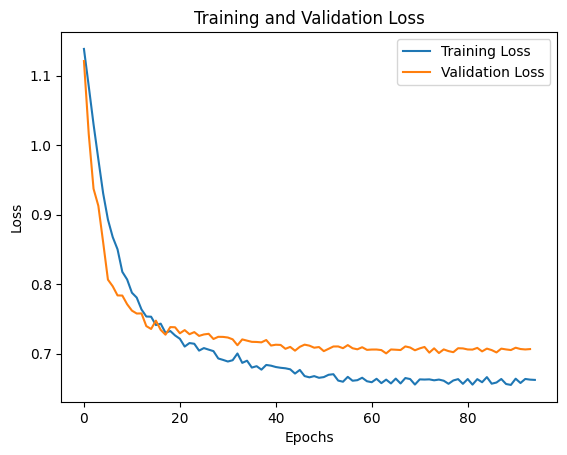

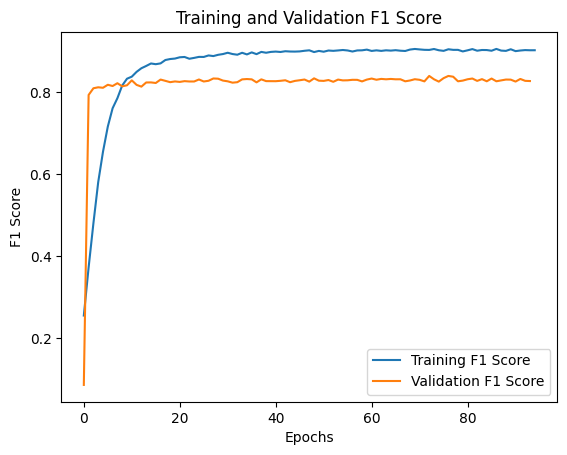

In [ ]:
# Initialize MetaClassifier and move to device
feed_forward_NN = FeedForwardNN().to(device)

# HP definition
num_epochs = 200
batch_size = 128
lr = 1e-5
weight_decay = 1e-2
model_path = "FFNN.pth"

# Training loop
train_metaclassifier(feed_forward_NN, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

In [ ]:
FFNN = FeedForwardNN()
FFNN.load_state_dict(torch.load(model_path))
FFNN = FFNN.to(device)
evaluate_metaclassifier(FFNN, test_dataset)


Test Loss: 0.6719652672608694
Test Macro F1 Score: 0.862274010046073
Test Weighted F1 Score: [0.88034934 0.89546351 0.81100917]
Test Accuracy: 0.8784292630446476


Not the best though.

##### <b>Convolutional NN</b>

Here, I would like to try a Convolutional architecture.</br>The reason behind this choice is the hope that the model could be capable of extracting high-order features concerning the reliability of base models.

Let's try and see!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_1d(nn.Module):
    def __init__(self):
        super(CNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, 3)  # Input tensor has shape [batch_size, 1, 6] after the unsqueeze
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(16, 32, 3)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(32 * 2, 64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)

        # First Convolutional Layer
        x = F.gelu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        # Second Convolutional Layer
        x = F.gelu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FCLayers
        x = F.selu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

Epoch 0: 100%|██████████| 33/33 [00:01<00:00, 24.87it/s, training_loss=0.569]



Training Loss at end of epoch 0: 1.0794227809617014
Training F1 Score at end of epoch 0: 0.34968538869127125
New best model saved with validation loss: 1.0580828189849854

Validation Loss at end of epoch 0: 1.0580828189849854
Validation Macro F1 Score at end of epoch 0: 0.2829430286115178
Validation Weighted F1 Score at end of epoch 0: [0.46679688 0.36603221 0.016     ]


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 152.10it/s, training_loss=0.525]



Training Loss at end of epoch 1: 1.0664173762003581
Training F1 Score at end of epoch 1: 0.3684512892247027
New best model saved with validation loss: 1.0389107912778854

Validation Loss at end of epoch 1: 1.0389107912778854
Validation Macro F1 Score at end of epoch 1: 0.4011506109067085
Validation Weighted F1 Score at end of epoch 1: [0.13658537 0.86080586 0.20606061]


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 147.96it/s, training_loss=0.639]



Training Loss at end of epoch 2: 1.0645330783092615
Training F1 Score at end of epoch 2: 0.3855817412147225
New best model saved with validation loss: 1.0198090597987175

Validation Loss at end of epoch 2: 1.0198090597987175
Validation Macro F1 Score at end of epoch 2: 0.42465975747910195
Validation Weighted F1 Score at end of epoch 2: [0.12054795 0.87756926 0.27586207]


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 149.09it/s, training_loss=0.500]



Training Loss at end of epoch 3: 1.0443378686904907
Training F1 Score at end of epoch 3: 0.4006304993130638
New best model saved with validation loss: 1.0062194392085075

Validation Loss at end of epoch 3: 1.0062194392085075
Validation Macro F1 Score at end of epoch 3: 0.45422489383219516
Validation Weighted F1 Score at end of epoch 3: [0.14326648 0.88042516 0.33898305]


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 150.80it/s, training_loss=0.497]



Training Loss at end of epoch 4: 1.0359836636167583
Training F1 Score at end of epoch 4: 0.42768347164025927
New best model saved with validation loss: 0.9921670407056808

Validation Loss at end of epoch 4: 0.9921670407056808
Validation Macro F1 Score at end of epoch 4: 0.48639215515969236
Validation Weighted F1 Score at end of epoch 4: [0.22764228 0.88318584 0.34834835]


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 146.98it/s, training_loss=0.569]



Training Loss at end of epoch 5: 1.0296151023922544
Training F1 Score at end of epoch 5: 0.4393699205303518
New best model saved with validation loss: 0.9741787537932396

Validation Loss at end of epoch 5: 0.9741787537932396
Validation Macro F1 Score at end of epoch 5: 0.5467835381080811
Validation Weighted F1 Score at end of epoch 5: [0.32978723 0.88556338 0.425     ]


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 147.89it/s, training_loss=0.604]



Training Loss at end of epoch 6: 1.0216095826842568
Training F1 Score at end of epoch 6: 0.4586692438636253
New best model saved with validation loss: 0.961900033056736

Validation Loss at end of epoch 6: 0.961900033056736
Validation Macro F1 Score at end of epoch 6: 0.5642929976816945
Validation Weighted F1 Score at end of epoch 6: [0.36787565 0.88475177 0.44025157]


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 144.53it/s, training_loss=0.553]



Training Loss at end of epoch 7: 1.0121664693861296
Training F1 Score at end of epoch 7: 0.4686832129862794
New best model saved with validation loss: 0.9593673348426819

Validation Loss at end of epoch 7: 0.9593673348426819
Validation Macro F1 Score at end of epoch 7: 0.6831110221637712
Validation Weighted F1 Score at end of epoch 7: [0.59325843 0.88355556 0.57251908]


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 149.36it/s, training_loss=0.550]



Training Loss at end of epoch 8: 1.002153010079355
Training F1 Score at end of epoch 8: 0.48129255244097985
New best model saved with validation loss: 0.946217343211174

Validation Loss at end of epoch 8: 0.946217343211174
Validation Macro F1 Score at end of epoch 8: 0.8018212009123761
Validation Weighted F1 Score at end of epoch 8: [0.76518219 0.88198758 0.75829384]


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 148.37it/s, training_loss=0.435]



Training Loss at end of epoch 9: 0.9855458122311216
Training F1 Score at end of epoch 9: 0.49911457186969327
New best model saved with validation loss: 0.9366947710514069

Validation Loss at end of epoch 9: 0.9366947710514069
Validation Macro F1 Score at end of epoch 9: 0.8097593936692974
Validation Weighted F1 Score at end of epoch 9: [0.77868852 0.8806366  0.76995305]


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 148.09it/s, training_loss=0.469]



Training Loss at end of epoch 10: 0.9801344311598575
Training F1 Score at end of epoch 10: 0.5218202702098025
New best model saved with validation loss: 0.9266095981001854

Validation Loss at end of epoch 10: 0.9266095981001854
Validation Macro F1 Score at end of epoch 10: 0.8083031881305701
Validation Weighted F1 Score at end of epoch 10: [0.7826087  0.88400703 0.75829384]


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 145.77it/s, training_loss=0.534]



Training Loss at end of epoch 11: 0.9733152714642611
Training F1 Score at end of epoch 11: 0.5361370596515006
New best model saved with validation loss: 0.9151060953736305

Validation Loss at end of epoch 11: 0.9151060953736305
Validation Macro F1 Score at end of epoch 11: 0.8177546934274288
Validation Weighted F1 Score at end of epoch 11: [0.7892562  0.88261253 0.78139535]


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 147.61it/s, training_loss=0.454]



Training Loss at end of epoch 12: 0.9606499075889587
Training F1 Score at end of epoch 12: 0.5469544469774674
New best model saved with validation loss: 0.903286799788475

Validation Loss at end of epoch 12: 0.903286799788475
Validation Macro F1 Score at end of epoch 12: 0.8164873662142779
Validation Weighted F1 Score at end of epoch 12: [0.79166667 0.88421053 0.77358491]


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 149.78it/s, training_loss=0.387]



Training Loss at end of epoch 13: 0.9501257863911715
Training F1 Score at end of epoch 13: 0.5542656853004433
New best model saved with validation loss: 0.8953206688165665

Validation Loss at end of epoch 13: 0.8953206688165665
Validation Macro F1 Score at end of epoch 13: 0.8202401418385356
Validation Weighted F1 Score at end of epoch 13: [0.79166667 0.88400703 0.78504673]


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 150.41it/s, training_loss=0.464]



Training Loss at end of epoch 14: 0.9512478438290682
Training F1 Score at end of epoch 14: 0.5562551867843503
New best model saved with validation loss: 0.8853582292795181

Validation Loss at end of epoch 14: 0.8853582292795181
Validation Macro F1 Score at end of epoch 14: 0.8283458994245491
Validation Weighted F1 Score at end of epoch 14: [0.8024948  0.88437776 0.79816514]


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 146.15it/s, training_loss=0.478]



Training Loss at end of epoch 15: 0.9399912465702404
Training F1 Score at end of epoch 15: 0.5867454690731196
New best model saved with validation loss: 0.8748234808444977

Validation Loss at end of epoch 15: 0.8748234808444977
Validation Macro F1 Score at end of epoch 15: 0.8250369948003639
Validation Weighted F1 Score at end of epoch 15: [0.8        0.88441331 0.79069767]


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 141.75it/s, training_loss=0.582]



Training Loss at end of epoch 16: 0.9391732215881348
Training F1 Score at end of epoch 16: 0.5971623714206203
New best model saved with validation loss: 0.8689864799380302

Validation Loss at end of epoch 16: 0.8689864799380302
Validation Macro F1 Score at end of epoch 16: 0.8261597672226366
Validation Weighted F1 Score at end of epoch 16: [0.79749478 0.88281938 0.79816514]


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 140.93it/s, training_loss=0.385]



Training Loss at end of epoch 17: 0.9211101333300272
Training F1 Score at end of epoch 17: 0.6080702086696188
New best model saved with validation loss: 0.859747126698494

Validation Loss at end of epoch 17: 0.859747126698494
Validation Macro F1 Score at end of epoch 17: 0.8268146582100071
Validation Weighted F1 Score at end of epoch 17: [0.80338266 0.88636364 0.79069767]


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 149.26it/s, training_loss=0.349]



Training Loss at end of epoch 18: 0.9066755627140854
Training F1 Score at end of epoch 18: 0.6366752773215072
New best model saved with validation loss: 0.8552947342395782

Validation Loss at end of epoch 18: 0.8552947342395782
Validation Macro F1 Score at end of epoch 18: 0.8292311187698548
Validation Weighted F1 Score at end of epoch 18: [0.80416667 0.88536155 0.79816514]


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 138.14it/s, training_loss=0.513]



Training Loss at end of epoch 19: 0.9164425604271166
Training F1 Score at end of epoch 19: 0.6329919642631908
New best model saved with validation loss: 0.8441481664776802

Validation Loss at end of epoch 19: 0.8441481664776802
Validation Macro F1 Score at end of epoch 19: 0.8270437114774684
Validation Weighted F1 Score at end of epoch 19: [0.79916318 0.88380282 0.79816514]


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 148.00it/s, training_loss=0.419]



Training Loss at end of epoch 20: 0.8994862310814135
Training F1 Score at end of epoch 20: 0.6576767156886613
New best model saved with validation loss: 0.83975949883461

Validation Loss at end of epoch 20: 0.83975949883461
Validation Macro F1 Score at end of epoch 20: 0.8312304203843098
Validation Weighted F1 Score at end of epoch 20: [0.80331263 0.88672566 0.80365297]


Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 152.05it/s, training_loss=0.514]



Training Loss at end of epoch 21: 0.901965036536708
Training F1 Score at end of epoch 21: 0.6509292037336849
New best model saved with validation loss: 0.8328148648142815

Validation Loss at end of epoch 21: 0.8328148648142815
Validation Macro F1 Score at end of epoch 21: 0.8297292527241772
Validation Weighted F1 Score at end of epoch 21: [0.80331263 0.88770999 0.79816514]


Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 140.42it/s, training_loss=0.427]



Training Loss at end of epoch 22: 0.8918380014824144
Training F1 Score at end of epoch 22: 0.6611984390425233
New best model saved with validation loss: 0.8288887590169907

Validation Loss at end of epoch 22: 0.8288887590169907
Validation Macro F1 Score at end of epoch 22: 0.8278566021615811
Validation Weighted F1 Score at end of epoch 22: [0.80165289 0.88553682 0.79638009]


Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 146.94it/s, training_loss=0.385]



Training Loss at end of epoch 23: 0.8813999132676558
Training F1 Score at end of epoch 23: 0.6728159756508147
New best model saved with validation loss: 0.8202651664614677

Validation Loss at end of epoch 23: 0.8202651664614677
Validation Macro F1 Score at end of epoch 23: 0.8296840739864578
Validation Weighted F1 Score at end of epoch 23: [0.80331263 0.88573959 0.8       ]


Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 144.61it/s, training_loss=0.421]



Training Loss at end of epoch 24: 0.8781148809375185
Training F1 Score at end of epoch 24: 0.6840225172490183
New best model saved with validation loss: 0.8114175722002983

Validation Loss at end of epoch 24: 0.8114175722002983
Validation Macro F1 Score at end of epoch 24: 0.8286402693954514
Validation Weighted F1 Score at end of epoch 24: [0.80082988 0.8869258  0.79816514]


Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 145.23it/s, training_loss=0.516]



Training Loss at end of epoch 25: 0.8773767424352241
Training F1 Score at end of epoch 25: 0.6903866774909484
New best model saved with validation loss: 0.8080462738871574

Validation Loss at end of epoch 25: 0.8080462738871574
Validation Macro F1 Score at end of epoch 25: 0.8257712521735732
Validation Weighted F1 Score at end of epoch 25: [0.80165289 0.88475177 0.79090909]


Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 150.55it/s, training_loss=0.561]



Training Loss at end of epoch 26: 0.873087738499497
Training F1 Score at end of epoch 26: 0.7077001115688706
New best model saved with validation loss: 0.8047969117760658

Validation Loss at end of epoch 26: 0.8047969117760658
Validation Macro F1 Score at end of epoch 26: 0.8270973560087372
Validation Weighted F1 Score at end of epoch 26: [0.80082988 0.88594164 0.79452055]


Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 141.83it/s, training_loss=0.596]



Training Loss at end of epoch 27: 0.8705482392600088
Training F1 Score at end of epoch 27: 0.707986519410638
New best model saved with validation loss: 0.8011210337281227

Validation Loss at end of epoch 27: 0.8011210337281227
Validation Macro F1 Score at end of epoch 27: 0.8270973560087372
Validation Weighted F1 Score at end of epoch 27: [0.80082988 0.88594164 0.79452055]


Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 142.38it/s, training_loss=0.417]



Training Loss at end of epoch 28: 0.8540925022327539
Training F1 Score at end of epoch 28: 0.7181834969481363
New best model saved with validation loss: 0.7989471331238747

Validation Loss at end of epoch 28: 0.7989471331238747
Validation Macro F1 Score at end of epoch 28: 0.8266537709561547
Validation Weighted F1 Score at end of epoch 28: [0.80331263 0.88573959 0.79090909]


Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 138.68it/s, training_loss=0.433]



Training Loss at end of epoch 29: 0.8525196422230114
Training F1 Score at end of epoch 29: 0.7225601556099944
New best model saved with validation loss: 0.7897379770874977

Validation Loss at end of epoch 29: 0.7897379770874977
Validation Macro F1 Score at end of epoch 29: 0.8246033565486233
Validation Weighted F1 Score at end of epoch 29: [0.79835391 0.88454707 0.79090909]


Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 144.48it/s, training_loss=0.544]



Training Loss at end of epoch 30: 0.8525930914011869
Training F1 Score at end of epoch 30: 0.7303411781053226
New best model saved with validation loss: 0.7852725759148598

Validation Loss at end of epoch 30: 0.7852725759148598
Validation Macro F1 Score at end of epoch 30: 0.8257712521735732
Validation Weighted F1 Score at end of epoch 30: [0.80165289 0.88475177 0.79090909]


Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 148.57it/s, training_loss=0.476]



Training Loss at end of epoch 31: 0.8442002534866333
Training F1 Score at end of epoch 31: 0.7347705760825858
New best model saved with validation loss: 0.7823584228754044

Validation Loss at end of epoch 31: 0.7823584228754044
Validation Macro F1 Score at end of epoch 31: 0.8246033565486233
Validation Weighted F1 Score at end of epoch 31: [0.79835391 0.88454707 0.79090909]


Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 148.32it/s, training_loss=0.593]



Training Loss at end of epoch 32: 0.8425781817147227
Training F1 Score at end of epoch 32: 0.751271896011787
New best model saved with validation loss: 0.7714758738875389

Validation Loss at end of epoch 32: 0.7714758738875389
Validation Macro F1 Score at end of epoch 32: 0.825564906213384
Validation Weighted F1 Score at end of epoch 32: [0.80082988 0.88495575 0.79090909]


Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 145.59it/s, training_loss=0.370]



Training Loss at end of epoch 33: 0.8257942271955085
Training F1 Score at end of epoch 33: 0.7513719073320843

Validation Loss at end of epoch 33: 0.7768582329154015
Validation Macro F1 Score at end of epoch 33: 0.8246830156446207
Validation Weighted F1 Score at end of epoch 33: [0.79917184 0.88396811 0.79090909]


Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 150.45it/s, training_loss=0.412]



Training Loss at end of epoch 34: 0.8232720837448583
Training F1 Score at end of epoch 34: 0.7547810029017011

Validation Loss at end of epoch 34: 0.7748737335205078
Validation Macro F1 Score at end of epoch 34: 0.8230799272542192
Validation Weighted F1 Score at end of epoch 34: [0.79835391 0.88355556 0.78733032]


Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 146.19it/s, training_loss=0.374]



Training Loss at end of epoch 35: 0.818026784694556
Training F1 Score at end of epoch 35: 0.7620118788384046
New best model saved with validation loss: 0.7710082158446312

Validation Loss at end of epoch 35: 0.7710082158446312
Validation Macro F1 Score at end of epoch 35: 0.8242484699454838
Validation Weighted F1 Score at end of epoch 35: [0.80165289 0.8837622  0.78733032]


Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 145.37it/s, training_loss=0.432]



Training Loss at end of epoch 36: 0.8166746623588331
Training F1 Score at end of epoch 36: 0.7713142979200905
New best model saved with validation loss: 0.7688350826501846

Validation Loss at end of epoch 36: 0.7688350826501846
Validation Macro F1 Score at end of epoch 36: 0.8248904304804926
Validation Weighted F1 Score at end of epoch 36: [0.8        0.8837622  0.79090909]


Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 151.87it/s, training_loss=0.341]



Training Loss at end of epoch 37: 0.8033915667822866
Training F1 Score at end of epoch 37: 0.7840326523663319
New best model saved with validation loss: 0.7618532180786133

Validation Loss at end of epoch 37: 0.7618532180786133
Validation Macro F1 Score at end of epoch 37: 0.8238028251567903
Validation Weighted F1 Score at end of epoch 37: [0.79752066 0.88297872 0.79090909]


Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 142.88it/s, training_loss=0.324]



Training Loss at end of epoch 38: 0.8010292053222656
Training F1 Score at end of epoch 38: 0.7858572777449524
New best model saved with validation loss: 0.7581413760781288

Validation Loss at end of epoch 38: 0.7581413760781288
Validation Macro F1 Score at end of epoch 38: 0.8230799272542192
Validation Weighted F1 Score at end of epoch 38: [0.79835391 0.88355556 0.78733032]


Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 134.22it/s, training_loss=0.487]



Training Loss at end of epoch 39: 0.807400851538687
Training F1 Score at end of epoch 39: 0.7795897999919692
New best model saved with validation loss: 0.7521467506885529

Validation Loss at end of epoch 39: 0.7521467506885529
Validation Macro F1 Score at end of epoch 39: 0.8200633994644067
Validation Weighted F1 Score at end of epoch 39: [0.79835391 0.88156723 0.78026906]


Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 144.06it/s, training_loss=0.570]



Training Loss at end of epoch 40: 0.8072850180394722
Training F1 Score at end of epoch 40: 0.7980631319831204
New best model saved with validation loss: 0.749838687479496

Validation Loss at end of epoch 40: 0.749838687479496
Validation Macro F1 Score at end of epoch 40: 0.82316029426548
Validation Weighted F1 Score at end of epoch 40: [0.79917184 0.88297872 0.78733032]


Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 139.50it/s, training_loss=0.329]



Training Loss at end of epoch 41: 0.7876714034513994
Training F1 Score at end of epoch 41: 0.8019614986655661

Validation Loss at end of epoch 41: 0.7525587305426598
Validation Macro F1 Score at end of epoch 41: 0.8200633994644067
Validation Weighted F1 Score at end of epoch 41: [0.79835391 0.88156723 0.78026906]


Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 138.66it/s, training_loss=0.529]



Training Loss at end of epoch 42: 0.7996045441338511
Training F1 Score at end of epoch 42: 0.7975289703679075
New best model saved with validation loss: 0.7465026751160622

Validation Loss at end of epoch 42: 0.7465026751160622
Validation Macro F1 Score at end of epoch 42: 0.8264485126554092
Validation Weighted F1 Score at end of epoch 42: [0.8024948  0.88594164 0.79090909]


Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 146.44it/s, training_loss=0.510]



Training Loss at end of epoch 43: 0.7912867737538887
Training F1 Score at end of epoch 43: 0.807866517410932
New best model saved with validation loss: 0.7404821515083313

Validation Loss at end of epoch 43: 0.7404821515083313
Validation Macro F1 Score at end of epoch 43: 0.8215666569429585
Validation Weighted F1 Score at end of epoch 43: [0.79835391 0.88256228 0.78378378]


Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 143.29it/s, training_loss=0.381]



Training Loss at end of epoch 44: 0.7842135826746622
Training F1 Score at end of epoch 44: 0.7986524316196011

Validation Loss at end of epoch 44: 0.7440881058573723
Validation Macro F1 Score at end of epoch 44: 0.8279803818310039
Validation Weighted F1 Score at end of epoch 44: [0.8024948  0.8869258  0.79452055]


Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 147.34it/s, training_loss=0.362]



Training Loss at end of epoch 45: 0.7751276854312781
Training F1 Score at end of epoch 45: 0.8140907022975878

Validation Loss at end of epoch 45: 0.7418177053332329
Validation Macro F1 Score at end of epoch 45: 0.8249269571497577
Validation Weighted F1 Score at end of epoch 45: [0.8024948  0.88495575 0.78733032]


Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 134.68it/s, training_loss=0.364]



Training Loss at end of epoch 46: 0.7726004647486138
Training F1 Score at end of epoch 46: 0.8217189632245442
New best model saved with validation loss: 0.7394668832421303

Validation Loss at end of epoch 46: 0.7394668832421303
Validation Macro F1 Score at end of epoch 46: 0.82316029426548
Validation Weighted F1 Score at end of epoch 46: [0.79917184 0.88297872 0.78733032]


Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 146.62it/s, training_loss=0.361]



Training Loss at end of epoch 47: 0.7707581646514662
Training F1 Score at end of epoch 47: 0.8205947682675118
New best model saved with validation loss: 0.7361737415194511

Validation Loss at end of epoch 47: 0.7361737415194511
Validation Macro F1 Score at end of epoch 47: 0.8200633994644067
Validation Weighted F1 Score at end of epoch 47: [0.79835391 0.88156723 0.78026906]


Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 141.75it/s, training_loss=0.339]



Training Loss at end of epoch 48: 0.7666351253336127
Training F1 Score at end of epoch 48: 0.8185767043141974
New best model saved with validation loss: 0.7360822334885597

Validation Loss at end of epoch 48: 0.7360822334885597
Validation Macro F1 Score at end of epoch 48: 0.8230799272542192
Validation Weighted F1 Score at end of epoch 48: [0.79835391 0.88355556 0.78733032]


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 142.34it/s, training_loss=0.299]



Training Loss at end of epoch 49: 0.7589901559280626
Training F1 Score at end of epoch 49: 0.8282766334306823
New best model saved with validation loss: 0.7350000068545341

Validation Loss at end of epoch 49: 0.7350000068545341
Validation Macro F1 Score at end of epoch 49: 0.8222795185129526
Validation Weighted F1 Score at end of epoch 49: [0.79752066 0.88198758 0.78733032]


Epoch 50: 100%|██████████| 33/33 [00:00<00:00, 146.83it/s, training_loss=0.453]



Training Loss at end of epoch 50: 0.7710433367526892
Training F1 Score at end of epoch 50: 0.8204331190352377
New best model saved with validation loss: 0.7327303737401962

Validation Loss at end of epoch 50: 0.7327303737401962
Validation Macro F1 Score at end of epoch 50: 0.8238028251567903
Validation Weighted F1 Score at end of epoch 50: [0.79752066 0.88297872 0.79090909]


Epoch 51: 100%|██████████| 33/33 [00:00<00:00, 149.84it/s, training_loss=0.319]



Training Loss at end of epoch 51: 0.7587867722366796
Training F1 Score at end of epoch 51: 0.822601364044428

Validation Loss at end of epoch 51: 0.7327781170606613
Validation Macro F1 Score at end of epoch 51: 0.8270973560087372
Validation Weighted F1 Score at end of epoch 51: [0.80082988 0.88594164 0.79452055]


Epoch 52: 100%|██████████| 33/33 [00:00<00:00, 148.70it/s, training_loss=0.500]



Training Loss at end of epoch 52: 0.7652136827960159
Training F1 Score at end of epoch 52: 0.832946292494337
New best model saved with validation loss: 0.7283459454774857

Validation Loss at end of epoch 52: 0.7283459454774857
Validation Macro F1 Score at end of epoch 52: 0.8200633994644067
Validation Weighted F1 Score at end of epoch 52: [0.79835391 0.88156723 0.78026906]


Epoch 53: 100%|██████████| 33/33 [00:00<00:00, 148.72it/s, training_loss=0.330]



Training Loss at end of epoch 53: 0.7521876927578088
Training F1 Score at end of epoch 53: 0.8352786545472973
New best model saved with validation loss: 0.7267852053046227

Validation Loss at end of epoch 53: 0.7267852053046227
Validation Macro F1 Score at end of epoch 53: 0.8203506588151434
Validation Weighted F1 Score at end of epoch 53: [0.8        0.88078292 0.78026906]


Epoch 54: 100%|██████████| 33/33 [00:00<00:00, 141.05it/s, training_loss=0.292]



Training Loss at end of epoch 54: 0.7467268253817703
Training F1 Score at end of epoch 54: 0.8411961227758792

Validation Loss at end of epoch 54: 0.7277530208230019
Validation Macro F1 Score at end of epoch 54: 0.8222795185129526
Validation Weighted F1 Score at end of epoch 54: [0.79752066 0.88198758 0.78733032]


Epoch 55: 100%|██████████| 33/33 [00:00<00:00, 142.99it/s, training_loss=0.323]



Training Loss at end of epoch 55: 0.7474803021459868
Training F1 Score at end of epoch 55: 0.8358078959951296
New best model saved with validation loss: 0.7258737087249756

Validation Loss at end of epoch 55: 0.7258737087249756
Validation Macro F1 Score at end of epoch 55: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 55: [0.80082136 0.88214286 0.78222222]


Epoch 56: 100%|██████████| 33/33 [00:00<00:00, 144.73it/s, training_loss=0.448]



Training Loss at end of epoch 56: 0.7496794949878346
Training F1 Score at end of epoch 56: 0.8482174856328834
New best model saved with validation loss: 0.7239292860031128

Validation Loss at end of epoch 56: 0.7239292860031128
Validation Macro F1 Score at end of epoch 56: 0.8192632398176629
Validation Weighted F1 Score at end of epoch 56: [0.79752066 0.88       0.78026906]


Epoch 57: 100%|██████████| 33/33 [00:00<00:00, 146.89it/s, training_loss=0.371]



Training Loss at end of epoch 57: 0.7455771041638923
Training F1 Score at end of epoch 57: 0.8455163302625192
New best model saved with validation loss: 0.722060039639473

Validation Loss at end of epoch 57: 0.722060039639473
Validation Macro F1 Score at end of epoch 57: 0.8192632398176629
Validation Weighted F1 Score at end of epoch 57: [0.79752066 0.88       0.78026906]


Epoch 58: 100%|██████████| 33/33 [00:00<00:00, 145.34it/s, training_loss=0.459]



Training Loss at end of epoch 58: 0.7486686598170887
Training F1 Score at end of epoch 58: 0.8438474562608195
New best model saved with validation loss: 0.7215329557657242

Validation Loss at end of epoch 58: 0.7215329557657242
Validation Macro F1 Score at end of epoch 58: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 58: [0.79835391 0.88135593 0.78222222]


Epoch 59: 100%|██████████| 33/33 [00:00<00:00, 147.06it/s, training_loss=0.386]



Training Loss at end of epoch 59: 0.739625663468332
Training F1 Score at end of epoch 59: 0.8466968268149687
New best model saved with validation loss: 0.7199953123927116

Validation Loss at end of epoch 59: 0.7199953123927116
Validation Macro F1 Score at end of epoch 59: 0.823367062359853
Validation Weighted F1 Score at end of epoch 59: [0.8        0.88277087 0.78733032]


Epoch 60: 100%|██████████| 33/33 [00:00<00:00, 147.18it/s, training_loss=0.381]



Training Loss at end of epoch 60: 0.7390533938552394
Training F1 Score at end of epoch 60: 0.843297851075879

Validation Loss at end of epoch 60: 0.721333421766758
Validation Macro F1 Score at end of epoch 60: 0.8215666569429585
Validation Weighted F1 Score at end of epoch 60: [0.79835391 0.88256228 0.78378378]


Epoch 61: 100%|██████████| 33/33 [00:00<00:00, 147.14it/s, training_loss=0.502]



Training Loss at end of epoch 61: 0.7430434208927732
Training F1 Score at end of epoch 61: 0.8487416450659269
New best model saved with validation loss: 0.7171907052397728

Validation Loss at end of epoch 61: 0.7171907052397728
Validation Macro F1 Score at end of epoch 61: 0.8185700112443032
Validation Weighted F1 Score at end of epoch 61: [0.79835391 0.88057041 0.77678571]


Epoch 62: 100%|██████████| 33/33 [00:00<00:00, 67.20it/s, training_loss=0.287]



Training Loss at end of epoch 62: 0.729545325943918
Training F1 Score at end of epoch 62: 0.8493567988280518

Validation Loss at end of epoch 62: 0.7179545760154724
Validation Macro F1 Score at end of epoch 62: 0.8185700112443032
Validation Weighted F1 Score at end of epoch 62: [0.79835391 0.88057041 0.77678571]


Epoch 63: 100%|██████████| 33/33 [00:00<00:00, 147.06it/s, training_loss=0.326]



Training Loss at end of epoch 63: 0.7277971343560652
Training F1 Score at end of epoch 63: 0.8542998730254091
New best model saved with validation loss: 0.7166499346494675

Validation Loss at end of epoch 63: 0.7166499346494675
Validation Macro F1 Score at end of epoch 63: 0.8279803818310039
Validation Weighted F1 Score at end of epoch 63: [0.8024948  0.8869258  0.79452055]


Epoch 64: 100%|██████████| 33/33 [00:00<00:00, 146.89it/s, training_loss=0.378]



Training Loss at end of epoch 64: 0.7294253544373945
Training F1 Score at end of epoch 64: 0.8617575445314979
New best model saved with validation loss: 0.7150919809937477

Validation Loss at end of epoch 64: 0.7150919809937477
Validation Macro F1 Score at end of epoch 64: 0.8185700112443032
Validation Weighted F1 Score at end of epoch 64: [0.79835391 0.88057041 0.77678571]


Epoch 65: 100%|██████████| 33/33 [00:00<00:00, 143.44it/s, training_loss=0.446]



Training Loss at end of epoch 65: 0.7315437179623228
Training F1 Score at end of epoch 65: 0.856652930630342
New best model saved with validation loss: 0.7129058018326759

Validation Loss at end of epoch 65: 0.7129058018326759
Validation Macro F1 Score at end of epoch 65: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 65: [0.79835391 0.88135593 0.78222222]


Epoch 66: 100%|██████████| 33/33 [00:00<00:00, 137.04it/s, training_loss=0.297]



Training Loss at end of epoch 66: 0.7205776265173247
Training F1 Score at end of epoch 66: 0.8625239575800862

Validation Loss at end of epoch 66: 0.7147043123841286
Validation Macro F1 Score at end of epoch 66: 0.8177699780538669
Validation Weighted F1 Score at end of epoch 66: [0.79752066 0.87900356 0.77678571]


Epoch 67: 100%|██████████| 33/33 [00:00<00:00, 147.78it/s, training_loss=0.355]



Training Loss at end of epoch 67: 0.7232216307611177
Training F1 Score at end of epoch 67: 0.8575454676307924
New best model saved with validation loss: 0.7125778719782829

Validation Loss at end of epoch 67: 0.7125778719782829
Validation Macro F1 Score at end of epoch 67: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 67: [0.79835391 0.88135593 0.78222222]


Epoch 68: 100%|██████████| 33/33 [00:00<00:00, 143.52it/s, training_loss=0.485]



Training Loss at end of epoch 68: 0.7285448511441549
Training F1 Score at end of epoch 68: 0.8611267216812618
New best model saved with validation loss: 0.7111067399382591

Validation Loss at end of epoch 68: 0.7111067399382591
Validation Macro F1 Score at end of epoch 68: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 68: [0.80082136 0.88214286 0.78222222]


Epoch 69: 100%|██████████| 33/33 [00:00<00:00, 147.43it/s, training_loss=0.332]



Training Loss at end of epoch 69: 0.7175092046911066
Training F1 Score at end of epoch 69: 0.8614451591291853

Validation Loss at end of epoch 69: 0.7117572799324989
Validation Macro F1 Score at end of epoch 69: 0.8218538538538538
Validation Weighted F1 Score at end of epoch 69: [0.8        0.88177778 0.78378378]


Epoch 70: 100%|██████████| 33/33 [00:00<00:00, 147.66it/s, training_loss=0.296]



Training Loss at end of epoch 70: 0.7133046551184221
Training F1 Score at end of epoch 70: 0.8650760446504605

Validation Loss at end of epoch 70: 0.7114013284444809
Validation Macro F1 Score at end of epoch 70: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 70: [0.79835391 0.88135593 0.78222222]


Epoch 71: 100%|██████████| 33/33 [00:00<00:00, 145.22it/s, training_loss=0.362]



Training Loss at end of epoch 71: 0.7156844825455637
Training F1 Score at end of epoch 71: 0.8588342201392334
New best model saved with validation loss: 0.7105769515037537

Validation Loss at end of epoch 71: 0.7105769515037537
Validation Macro F1 Score at end of epoch 71: 0.8228106997693426
Validation Weighted F1 Score at end of epoch 71: [0.80327869 0.88293119 0.78222222]


Epoch 72: 100%|██████████| 33/33 [00:00<00:00, 139.36it/s, training_loss=0.368]



Training Loss at end of epoch 72: 0.7147883140679562
Training F1 Score at end of epoch 72: 0.8672700571273292
New best model saved with validation loss: 0.7081094235181808

Validation Loss at end of epoch 72: 0.7081094235181808
Validation Macro F1 Score at end of epoch 72: 0.8219141947316739
Validation Weighted F1 Score at end of epoch 72: [0.8024948  0.88297872 0.78026906]


Epoch 73: 100%|██████████| 33/33 [00:00<00:00, 140.07it/s, training_loss=0.455]



Training Loss at end of epoch 73: 0.7181395653522376
Training F1 Score at end of epoch 73: 0.8696536314155882
New best model saved with validation loss: 0.7076869830489159

Validation Loss at end of epoch 73: 0.7076869830489159
Validation Macro F1 Score at end of epoch 73: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 73: [0.79835391 0.88135593 0.78222222]


Epoch 74: 100%|██████████| 33/33 [00:00<00:00, 145.04it/s, training_loss=0.412]



Training Loss at end of epoch 74: 0.71783652269479
Training F1 Score at end of epoch 74: 0.8601685659159269

Validation Loss at end of epoch 74: 0.7092372477054596
Validation Macro F1 Score at end of epoch 74: 0.8225307942355703
Validation Weighted F1 Score at end of epoch 74: [0.80082988 0.88297872 0.78378378]


Epoch 75: 100%|██████████| 33/33 [00:00<00:00, 142.99it/s, training_loss=0.434]



Training Loss at end of epoch 75: 0.7135372216051276
Training F1 Score at end of epoch 75: 0.8703451758476287
New best model saved with validation loss: 0.7067334577441216

Validation Loss at end of epoch 75: 0.7067334577441216
Validation Macro F1 Score at end of epoch 75: 0.8196543339084146
Validation Weighted F1 Score at end of epoch 75: [0.80082136 0.88135593 0.77678571]


Epoch 76: 100%|██████████| 33/33 [00:00<00:00, 141.85it/s, training_loss=0.339]



Training Loss at end of epoch 76: 0.7074417742815885
Training F1 Score at end of epoch 76: 0.8709690922024772

Validation Loss at end of epoch 76: 0.7072806730866432
Validation Macro F1 Score at end of epoch 76: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 76: [0.79835391 0.88135593 0.78222222]


Epoch 77: 100%|██████████| 33/33 [00:00<00:00, 146.02it/s, training_loss=0.392]



Training Loss at end of epoch 77: 0.7097895831772776
Training F1 Score at end of epoch 77: 0.8656766238855345
New best model saved with validation loss: 0.7053043767809868

Validation Loss at end of epoch 77: 0.7053043767809868
Validation Macro F1 Score at end of epoch 77: 0.8177699780538669
Validation Weighted F1 Score at end of epoch 77: [0.79752066 0.87900356 0.77678571]


Epoch 78: 100%|██████████| 33/33 [00:00<00:00, 146.34it/s, training_loss=0.285]



Training Loss at end of epoch 78: 0.7031889955202738
Training F1 Score at end of epoch 78: 0.8739447057805833

Validation Loss at end of epoch 78: 0.7071356549859047
Validation Macro F1 Score at end of epoch 78: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 78: [0.80082136 0.88214286 0.78222222]


Epoch 79: 100%|██████████| 33/33 [00:00<00:00, 147.38it/s, training_loss=0.293]



Training Loss at end of epoch 79: 0.7020056374145277
Training F1 Score at end of epoch 79: 0.8710190829082979
New best model saved with validation loss: 0.7051735445857048

Validation Loss at end of epoch 79: 0.7051735445857048
Validation Macro F1 Score at end of epoch 79: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 79: [0.80082136 0.88214286 0.78222222]


Epoch 80: 100%|██████████| 33/33 [00:00<00:00, 140.33it/s, training_loss=0.396]



Training Loss at end of epoch 80: 0.706281759522178
Training F1 Score at end of epoch 80: 0.8685832542392572

Validation Loss at end of epoch 80: 0.7055030167102814
Validation Macro F1 Score at end of epoch 80: 0.8198430567037384
Validation Weighted F1 Score at end of epoch 80: [0.79752066 0.87978629 0.78222222]


Epoch 81: 100%|██████████| 33/33 [00:00<00:00, 145.61it/s, training_loss=0.286]



Training Loss at end of epoch 81: 0.6991203770493016
Training F1 Score at end of epoch 81: 0.8721276067226112
New best model saved with validation loss: 0.7046443521976471

Validation Loss at end of epoch 81: 0.7046443521976471
Validation Macro F1 Score at end of epoch 81: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 81: [0.79835391 0.88135593 0.78222222]


Epoch 82: 100%|██████████| 33/33 [00:00<00:00, 150.22it/s, training_loss=0.278]



Training Loss at end of epoch 82: 0.6956877419442842
Training F1 Score at end of epoch 82: 0.8726240163655087

Validation Loss at end of epoch 82: 0.7052129581570625
Validation Macro F1 Score at end of epoch 82: 0.8228106997693426
Validation Weighted F1 Score at end of epoch 82: [0.80327869 0.88293119 0.78222222]


Epoch 83: 100%|██████████| 33/33 [00:00<00:00, 145.53it/s, training_loss=0.313]



Training Loss at end of epoch 83: 0.6966434988108549
Training F1 Score at end of epoch 83: 0.8751389858025199
New best model saved with validation loss: 0.7041221261024475

Validation Loss at end of epoch 83: 0.7041221261024475
Validation Macro F1 Score at end of epoch 83: 0.8185700112443032
Validation Weighted F1 Score at end of epoch 83: [0.79835391 0.88057041 0.77678571]


Epoch 84: 100%|██████████| 33/33 [00:00<00:00, 145.74it/s, training_loss=0.294]



Training Loss at end of epoch 84: 0.6968246878999652
Training F1 Score at end of epoch 84: 0.8739777375715185

Validation Loss at end of epoch 84: 0.7041536048054695
Validation Macro F1 Score at end of epoch 84: 0.8228106997693426
Validation Weighted F1 Score at end of epoch 84: [0.80327869 0.88293119 0.78222222]


Epoch 85: 100%|██████████| 33/33 [00:00<00:00, 145.50it/s, training_loss=0.374]



Training Loss at end of epoch 85: 0.6991533889915004
Training F1 Score at end of epoch 85: 0.8749709453187179
New best model saved with validation loss: 0.7039921879768372

Validation Loss at end of epoch 85: 0.7039921879768372
Validation Macro F1 Score at end of epoch 85: 0.8196543339084146
Validation Weighted F1 Score at end of epoch 85: [0.80082136 0.88135593 0.77678571]


Epoch 86: 100%|██████████| 33/33 [00:00<00:00, 140.88it/s, training_loss=0.405]



Training Loss at end of epoch 86: 0.6998148054787607
Training F1 Score at end of epoch 86: 0.8769553573559051
New best model saved with validation loss: 0.7035582959651947

Validation Loss at end of epoch 86: 0.7035582959651947
Validation Macro F1 Score at end of epoch 86: 0.8211477849028581
Validation Weighted F1 Score at end of epoch 86: [0.80082136 0.88235294 0.78026906]


Epoch 87: 100%|██████████| 33/33 [00:00<00:00, 133.36it/s, training_loss=0.525]



Training Loss at end of epoch 87: 0.7053955685008656
Training F1 Score at end of epoch 87: 0.8741105559581541
New best model saved with validation loss: 0.7028731107711792

Validation Loss at end of epoch 87: 0.7028731107711792
Validation Macro F1 Score at end of epoch 87: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 87: [0.80082136 0.88214286 0.78222222]


Epoch 88: 100%|██████████| 33/33 [00:00<00:00, 142.66it/s, training_loss=0.294]



Training Loss at end of epoch 88: 0.6913506081610015
Training F1 Score at end of epoch 88: 0.8789339664596961
New best model saved with validation loss: 0.7023439854383469

Validation Loss at end of epoch 88: 0.7023439854383469
Validation Macro F1 Score at end of epoch 88: 0.8198430567037384
Validation Weighted F1 Score at end of epoch 88: [0.79752066 0.87978629 0.78222222]


Epoch 89: 100%|██████████| 33/33 [00:00<00:00, 145.70it/s, training_loss=0.303]



Training Loss at end of epoch 89: 0.6922070799451886
Training F1 Score at end of epoch 89: 0.8735807224022872
New best model saved with validation loss: 0.7013509720563889

Validation Loss at end of epoch 89: 0.7013509720563889
Validation Macro F1 Score at end of epoch 89: 0.8195563069547304
Validation Weighted F1 Score at end of epoch 89: [0.79587629 0.88057041 0.78222222]


Epoch 90: 100%|██████████| 33/33 [00:00<00:00, 146.26it/s, training_loss=0.391]



Training Loss at end of epoch 90: 0.6964789141308178
Training F1 Score at end of epoch 90: 0.8764225221721987

Validation Loss at end of epoch 90: 0.7018060013651848
Validation Macro F1 Score at end of epoch 90: 0.8228106997693426
Validation Weighted F1 Score at end of epoch 90: [0.80327869 0.88293119 0.78222222]


Epoch 91: 100%|██████████| 33/33 [00:00<00:00, 137.12it/s, training_loss=0.336]



Training Loss at end of epoch 91: 0.6905057376081293
Training F1 Score at end of epoch 91: 0.8804337866214915

Validation Loss at end of epoch 91: 0.7016826719045639
Validation Macro F1 Score at end of epoch 91: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 91: [0.80082136 0.88214286 0.78222222]


Epoch 92: 100%|██████████| 33/33 [00:00<00:00, 144.74it/s, training_loss=0.552]



Training Loss at end of epoch 92: 0.7023698741739447
Training F1 Score at end of epoch 92: 0.8794809249751193

Validation Loss at end of epoch 92: 0.7016602084040642
Validation Macro F1 Score at end of epoch 92: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 92: [0.79835391 0.88135593 0.78222222]


Epoch 93: 100%|██████████| 33/33 [00:00<00:00, 141.37it/s, training_loss=0.491]



Training Loss at end of epoch 93: 0.6983800747177817
Training F1 Score at end of epoch 93: 0.8777151347956668
New best model saved with validation loss: 0.7001676186919212

Validation Loss at end of epoch 93: 0.7001676186919212
Validation Macro F1 Score at end of epoch 93: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 93: [0.80082136 0.88214286 0.78222222]


Epoch 94: 100%|██████████| 33/33 [00:00<00:00, 144.17it/s, training_loss=0.552]



Training Loss at end of epoch 94: 0.7001503868536516
Training F1 Score at end of epoch 94: 0.8813935372306282
New best model saved with validation loss: 0.6997049078345299

Validation Loss at end of epoch 94: 0.6997049078345299
Validation Macro F1 Score at end of epoch 94: 0.8216099585062241
Validation Weighted F1 Score at end of epoch 94: [0.80082988 0.88177778 0.78222222]


Epoch 95: 100%|██████████| 33/33 [00:00<00:00, 145.41it/s, training_loss=0.390]



Training Loss at end of epoch 95: 0.6899914597020005
Training F1 Score at end of epoch 95: 0.878908460106727

Validation Loss at end of epoch 95: 0.6999044939875603
Validation Macro F1 Score at end of epoch 95: 0.820725661007264
Validation Weighted F1 Score at end of epoch 95: [0.79917184 0.88078292 0.78222222]


Epoch 96: 100%|██████████| 33/33 [00:00<00:00, 140.36it/s, training_loss=0.411]



Training Loss at end of epoch 96: 0.6906032634503914
Training F1 Score at end of epoch 96: 0.8808198422913366

Validation Loss at end of epoch 96: 0.700266920030117
Validation Macro F1 Score at end of epoch 96: 0.8228106997693426
Validation Weighted F1 Score at end of epoch 96: [0.80327869 0.88293119 0.78222222]


Epoch 97: 100%|██████████| 33/33 [00:00<00:00, 140.84it/s, training_loss=0.281]



Training Loss at end of epoch 97: 0.6827404733860132
Training F1 Score at end of epoch 97: 0.8765633023722329

Validation Loss at end of epoch 97: 0.6998234242200851
Validation Macro F1 Score at end of epoch 97: 0.8195563069547304
Validation Weighted F1 Score at end of epoch 97: [0.79587629 0.88057041 0.78222222]


Epoch 98: 100%|██████████| 33/33 [00:00<00:00, 143.99it/s, training_loss=0.284]



Training Loss at end of epoch 98: 0.6806174805670073
Training F1 Score at end of epoch 98: 0.8821000273389982
New best model saved with validation loss: 0.6996554359793663

Validation Loss at end of epoch 98: 0.6996554359793663
Validation Macro F1 Score at end of epoch 98: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 98: [0.79835391 0.88135593 0.78222222]


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 145.68it/s, training_loss=0.531]



Training Loss at end of epoch 99: 0.6958092324661486
Training F1 Score at end of epoch 99: 0.8834861229177253
New best model saved with validation loss: 0.6995851248502731

Validation Loss at end of epoch 99: 0.6995851248502731
Validation Macro F1 Score at end of epoch 99: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 99: [0.79835391 0.88135593 0.78222222]


Epoch 100: 100%|██████████| 33/33 [00:00<00:00, 143.46it/s, training_loss=0.293]



Training Loss at end of epoch 100: 0.6812409144459348
Training F1 Score at end of epoch 100: 0.8801287118920941

Validation Loss at end of epoch 100: 0.6997194364666939
Validation Macro F1 Score at end of epoch 100: 0.8195563069547304
Validation Weighted F1 Score at end of epoch 100: [0.79587629 0.88057041 0.78222222]


Epoch 101: 100%|██████████| 33/33 [00:00<00:00, 145.40it/s, training_loss=0.470]



Training Loss at end of epoch 101: 0.6905360420544943
Training F1 Score at end of epoch 101: 0.8839142516420657
New best model saved with validation loss: 0.6986700147390366

Validation Loss at end of epoch 101: 0.6986700147390366
Validation Macro F1 Score at end of epoch 101: 0.8198430567037384
Validation Weighted F1 Score at end of epoch 101: [0.79752066 0.87978629 0.78222222]


Epoch 102: 100%|██████████| 33/33 [00:00<00:00, 147.14it/s, training_loss=0.306]



Training Loss at end of epoch 102: 0.6800688324552594
Training F1 Score at end of epoch 102: 0.8860317695695978

Validation Loss at end of epoch 102: 0.6992650330066681
Validation Macro F1 Score at end of epoch 102: 0.821323923979466
Validation Weighted F1 Score at end of epoch 102: [0.80327869 0.88193202 0.77876106]


Epoch 103: 100%|██████████| 33/33 [00:00<00:00, 142.63it/s, training_loss=0.662]



Training Loss at end of epoch 103: 0.7002912633346788
Training F1 Score at end of epoch 103: 0.8862933089922719
New best model saved with validation loss: 0.6986381635069847

Validation Loss at end of epoch 103: 0.6986381635069847
Validation Macro F1 Score at end of epoch 103: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 103: [0.80082136 0.88214286 0.78222222]


Epoch 104: 100%|██████████| 33/33 [00:00<00:00, 141.88it/s, training_loss=0.434]



Training Loss at end of epoch 104: 0.6880615425832344
Training F1 Score at end of epoch 104: 0.8815593670984384

Validation Loss at end of epoch 104: 0.699186697602272
Validation Macro F1 Score at end of epoch 104: 0.8233804111122153
Validation Weighted F1 Score at end of epoch 104: [0.80327869 0.88272158 0.78414097]


Epoch 105: 100%|██████████| 33/33 [00:00<00:00, 146.34it/s, training_loss=0.513]



Training Loss at end of epoch 105: 0.6908019347624346
Training F1 Score at end of epoch 105: 0.8834237536414854
New best model saved with validation loss: 0.697576142847538

Validation Loss at end of epoch 105: 0.697576142847538
Validation Macro F1 Score at end of epoch 105: 0.8195563069547304
Validation Weighted F1 Score at end of epoch 105: [0.79587629 0.88057041 0.78222222]


Epoch 106: 100%|██████████| 33/33 [00:00<00:00, 147.08it/s, training_loss=0.567]



Training Loss at end of epoch 106: 0.6941769881681963
Training F1 Score at end of epoch 106: 0.8816402716198142
New best model saved with validation loss: 0.6975735053420067

Validation Loss at end of epoch 106: 0.6975735053420067
Validation Macro F1 Score at end of epoch 106: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 106: [0.79835391 0.88135593 0.78222222]


Epoch 107: 100%|██████████| 33/33 [00:00<00:00, 148.33it/s, training_loss=0.446]



Training Loss at end of epoch 107: 0.6848486950903228
Training F1 Score at end of epoch 107: 0.8838148010910053

Validation Loss at end of epoch 107: 0.6982416585087776
Validation Macro F1 Score at end of epoch 107: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 107: [0.80082136 0.88114388 0.77876106]


Epoch 108: 100%|██████████| 33/33 [00:00<00:00, 148.47it/s, training_loss=0.288]



Training Loss at end of epoch 108: 0.6771587639143972
Training F1 Score at end of epoch 108: 0.8819932945987632

Validation Loss at end of epoch 108: 0.6980876475572586
Validation Macro F1 Score at end of epoch 108: 0.8177699780538669
Validation Weighted F1 Score at end of epoch 108: [0.79752066 0.87900356 0.77678571]


Epoch 109: 100%|██████████| 33/33 [00:00<00:00, 144.63it/s, training_loss=0.312]



Training Loss at end of epoch 109: 0.6761662580750205
Training F1 Score at end of epoch 109: 0.8832674732322454

Validation Loss at end of epoch 109: 0.6986599639058113
Validation Macro F1 Score at end of epoch 109: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 109: [0.80327869 0.88251121 0.7860262 ]


Epoch 110: 100%|██████████| 33/33 [00:00<00:00, 148.03it/s, training_loss=0.334]



Training Loss at end of epoch 110: 0.6775100935589183
Training F1 Score at end of epoch 110: 0.8813857210758922

Validation Loss at end of epoch 110: 0.6982419043779373
Validation Macro F1 Score at end of epoch 110: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 110: [0.80327869 0.88251121 0.7860262 ]


Epoch 111: 100%|██████████| 33/33 [00:00<00:00, 139.95it/s, training_loss=0.282]



Training Loss at end of epoch 111: 0.6722594517650027
Training F1 Score at end of epoch 111: 0.8869600047973568

Validation Loss at end of epoch 111: 0.6978975832462311
Validation Macro F1 Score at end of epoch 111: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 111: [0.80082136 0.88214286 0.78222222]


Epoch 112: 100%|██████████| 33/33 [00:00<00:00, 146.07it/s, training_loss=0.277]



Training Loss at end of epoch 112: 0.6734285625544462
Training F1 Score at end of epoch 112: 0.8880466952728567

Validation Loss at end of epoch 112: 0.6982471123337746
Validation Macro F1 Score at end of epoch 112: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 112: [0.80327869 0.88251121 0.7860262 ]


Epoch 113: 100%|██████████| 33/33 [00:00<00:00, 148.22it/s, training_loss=0.513]



Training Loss at end of epoch 113: 0.6853225881403143
Training F1 Score at end of epoch 113: 0.8860735560162706
New best model saved with validation loss: 0.697520300745964

Validation Loss at end of epoch 113: 0.697520300745964
Validation Macro F1 Score at end of epoch 113: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 113: [0.79835391 0.88135593 0.78222222]


Epoch 114: 100%|██████████| 33/33 [00:00<00:00, 144.98it/s, training_loss=0.316]



Training Loss at end of epoch 114: 0.6724926540345857
Training F1 Score at end of epoch 114: 0.889676933942857
New best model saved with validation loss: 0.6963591352105141

Validation Loss at end of epoch 114: 0.6963591352105141
Validation Macro F1 Score at end of epoch 114: 0.8230744710457216
Validation Weighted F1 Score at end of epoch 114: [0.80082988 0.88078292 0.78761062]


Epoch 115: 100%|██████████| 33/33 [00:00<00:00, 147.40it/s, training_loss=0.418]



Training Loss at end of epoch 115: 0.6814708294290485
Training F1 Score at end of epoch 115: 0.884147453972934

Validation Loss at end of epoch 115: 0.6968411132693291
Validation Macro F1 Score at end of epoch 115: 0.8177699780538669
Validation Weighted F1 Score at end of epoch 115: [0.79752066 0.87900356 0.77678571]


Epoch 116: 100%|██████████| 33/33 [00:00<00:00, 144.47it/s, training_loss=0.306]



Training Loss at end of epoch 116: 0.6696885625521342
Training F1 Score at end of epoch 116: 0.8894404484581697

Validation Loss at end of epoch 116: 0.6976462751626968
Validation Macro F1 Score at end of epoch 116: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 116: [0.80327869 0.88251121 0.7860262 ]


Epoch 117: 100%|██████████| 33/33 [00:00<00:00, 138.00it/s, training_loss=0.328]



Training Loss at end of epoch 117: 0.6736934383710226
Training F1 Score at end of epoch 117: 0.8818820724487196

Validation Loss at end of epoch 117: 0.6966020911931992
Validation Macro F1 Score at end of epoch 117: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 117: [0.80082136 0.88114388 0.77876106]


Epoch 118: 100%|██████████| 33/33 [00:00<00:00, 144.38it/s, training_loss=0.317]



Training Loss at end of epoch 118: 0.6707562605539957
Training F1 Score at end of epoch 118: 0.8873219294393039
New best model saved with validation loss: 0.6957051903009415

Validation Loss at end of epoch 118: 0.6957051903009415
Validation Macro F1 Score at end of epoch 118: 0.820725661007264
Validation Weighted F1 Score at end of epoch 118: [0.79917184 0.88078292 0.78222222]


Epoch 119: 100%|██████████| 33/33 [00:00<00:00, 145.73it/s, training_loss=0.303]



Training Loss at end of epoch 119: 0.6700432806304006
Training F1 Score at end of epoch 119: 0.8886278894186518

Validation Loss at end of epoch 119: 0.6970948204398155
Validation Macro F1 Score at end of epoch 119: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 119: [0.80082136 0.88214286 0.78222222]


Epoch 120: 100%|██████████| 33/33 [00:00<00:00, 144.58it/s, training_loss=0.295]



Training Loss at end of epoch 120: 0.6679586623654221
Training F1 Score at end of epoch 120: 0.8904972582510483

Validation Loss at end of epoch 120: 0.6964135989546776
Validation Macro F1 Score at end of epoch 120: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 120: [0.80082136 0.88114388 0.77876106]


Epoch 121: 100%|██████████| 33/33 [00:00<00:00, 145.92it/s, training_loss=0.300]



Training Loss at end of epoch 121: 0.6691309376196428
Training F1 Score at end of epoch 121: 0.88931840727354

Validation Loss at end of epoch 121: 0.6975230276584625
Validation Macro F1 Score at end of epoch 121: 0.8299649709288532
Validation Weighted F1 Score at end of epoch 121: [0.80327869 0.88489209 0.80172414]


Epoch 122: 100%|██████████| 33/33 [00:00<00:00, 143.05it/s, training_loss=0.358]



Training Loss at end of epoch 122: 0.6715824712406505
Training F1 Score at end of epoch 122: 0.8883930057948387

Validation Loss at end of epoch 122: 0.6966835111379623
Validation Macro F1 Score at end of epoch 122: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 122: [0.80082136 0.88114388 0.77876106]


Epoch 123: 100%|██████████| 33/33 [00:00<00:00, 144.23it/s, training_loss=0.322]



Training Loss at end of epoch 123: 0.6707039872805277
Training F1 Score at end of epoch 123: 0.8871578779030521

Validation Loss at end of epoch 123: 0.6971680000424385
Validation Macro F1 Score at end of epoch 123: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 123: [0.80327869 0.88388839 0.79828326]


Epoch 124: 100%|██████████| 33/33 [00:00<00:00, 66.38it/s, training_loss=0.357]



Training Loss at end of epoch 124: 0.6714669809196935
Training F1 Score at end of epoch 124: 0.8894033118869761
New best model saved with validation loss: 0.6954417824745178

Validation Loss at end of epoch 124: 0.6954417824745178
Validation Macro F1 Score at end of epoch 124: 0.820725661007264
Validation Weighted F1 Score at end of epoch 124: [0.79917184 0.88078292 0.78222222]


Epoch 125: 100%|██████████| 33/33 [00:00<00:00, 145.99it/s, training_loss=0.496]



Training Loss at end of epoch 125: 0.681416108752742
Training F1 Score at end of epoch 125: 0.8840073190818799

Validation Loss at end of epoch 125: 0.6954500749707222
Validation Macro F1 Score at end of epoch 125: 0.820725661007264
Validation Weighted F1 Score at end of epoch 125: [0.79917184 0.88078292 0.78222222]


Epoch 126: 100%|██████████| 33/33 [00:00<00:00, 147.79it/s, training_loss=0.522]



Training Loss at end of epoch 126: 0.6807620380863999
Training F1 Score at end of epoch 126: 0.8895229487335161

Validation Loss at end of epoch 126: 0.696091964840889
Validation Macro F1 Score at end of epoch 126: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 126: [0.80082136 0.88214286 0.78222222]


Epoch 127: 100%|██████████| 33/33 [00:00<00:00, 137.55it/s, training_loss=0.277]



Training Loss at end of epoch 127: 0.6663929783936703
Training F1 Score at end of epoch 127: 0.886768058685016

Validation Loss at end of epoch 127: 0.69654630869627
Validation Macro F1 Score at end of epoch 127: 0.8228559954056763
Validation Weighted F1 Score at end of epoch 127: [0.80082136 0.88172043 0.7860262 ]


Epoch 128: 100%|██████████| 33/33 [00:00<00:00, 140.61it/s, training_loss=0.534]



Training Loss at end of epoch 128: 0.680847092108293
Training F1 Score at end of epoch 128: 0.8853655813524558

Validation Loss at end of epoch 128: 0.695911169052124
Validation Macro F1 Score at end of epoch 128: 0.8228559954056763
Validation Weighted F1 Score at end of epoch 128: [0.80082136 0.88172043 0.7860262 ]


Epoch 129: 100%|██████████| 33/33 [00:00<00:00, 144.83it/s, training_loss=0.428]



Training Loss at end of epoch 129: 0.673437729026332
Training F1 Score at end of epoch 129: 0.888990353398913

Validation Loss at end of epoch 129: 0.6962747573852539
Validation Macro F1 Score at end of epoch 129: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 129: [0.80327869 0.88388839 0.79828326]


Epoch 130: 100%|██████████| 33/33 [00:00<00:00, 146.06it/s, training_loss=0.310]



Training Loss at end of epoch 130: 0.6666324391509547
Training F1 Score at end of epoch 130: 0.8874950326269984

Validation Loss at end of epoch 130: 0.6969855725765228
Validation Macro F1 Score at end of epoch 130: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 130: [0.80327869 0.88388839 0.79828326]


Epoch 131: 100%|██████████| 33/33 [00:00<00:00, 144.82it/s, training_loss=0.538]



Training Loss at end of epoch 131: 0.6784661249680952
Training F1 Score at end of epoch 131: 0.8906423774409097
New best model saved with validation loss: 0.695415623486042

Validation Loss at end of epoch 131: 0.695415623486042
Validation Macro F1 Score at end of epoch 131: 0.8191573714230219
Validation Weighted F1 Score at end of epoch 131: [0.79835391 0.88035714 0.77876106]


Epoch 132: 100%|██████████| 33/33 [00:00<00:00, 145.56it/s, training_loss=0.359]



Training Loss at end of epoch 132: 0.6685032248497009
Training F1 Score at end of epoch 132: 0.8891858579000712

Validation Loss at end of epoch 132: 0.6962185949087143
Validation Macro F1 Score at end of epoch 132: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 132: [0.80327869 0.88388839 0.79828326]


Epoch 133: 100%|██████████| 33/33 [00:00<00:00, 137.58it/s, training_loss=0.304]



Training Loss at end of epoch 133: 0.6639206012090048
Training F1 Score at end of epoch 133: 0.8891108929449238

Validation Loss at end of epoch 133: 0.69657963514328
Validation Macro F1 Score at end of epoch 133: 0.8259621491605788
Validation Weighted F1 Score at end of epoch 133: [0.80327869 0.88330341 0.79130435]


Epoch 134: 100%|██████████| 33/33 [00:00<00:00, 140.08it/s, training_loss=0.296]



Training Loss at end of epoch 134: 0.6617847157247139
Training F1 Score at end of epoch 134: 0.8896517741302388

Validation Loss at end of epoch 134: 0.6965140327811241
Validation Macro F1 Score at end of epoch 134: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 134: [0.80327869 0.88388839 0.79828326]


Epoch 135: 100%|██████████| 33/33 [00:00<00:00, 135.45it/s, training_loss=0.296]



Training Loss at end of epoch 135: 0.6619821877190561
Training F1 Score at end of epoch 135: 0.8909992884131258

Validation Loss at end of epoch 135: 0.6964021623134613
Validation Macro F1 Score at end of epoch 135: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 135: [0.80327869 0.88388839 0.79828326]
Epoch 00136: reducing learning rate of group 0 to 1.0000e-06.


Epoch 136: 100%|██████████| 33/33 [00:00<00:00, 139.60it/s, training_loss=0.289]



Training Loss at end of epoch 136: 0.6602635835156296
Training F1 Score at end of epoch 136: 0.8936473081969175

Validation Loss at end of epoch 136: 0.6956362649798393
Validation Macro F1 Score at end of epoch 136: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 136: [0.80327869 0.88251121 0.7860262 ]


Epoch 137: 100%|██████████| 33/33 [00:00<00:00, 137.57it/s, training_loss=0.298]



Training Loss at end of epoch 137: 0.663368902423165
Training F1 Score at end of epoch 137: 0.8889793474158135

Validation Loss at end of epoch 137: 0.6966186612844467
Validation Macro F1 Score at end of epoch 137: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 137: [0.80327869 0.88388839 0.79828326]


Epoch 138: 100%|██████████| 33/33 [00:00<00:00, 140.11it/s, training_loss=0.301]



Training Loss at end of epoch 138: 0.662686369635842
Training F1 Score at end of epoch 138: 0.8889959899337145
New best model saved with validation loss: 0.6946574747562408

Validation Loss at end of epoch 138: 0.6946574747562408
Validation Macro F1 Score at end of epoch 138: 0.8230744710457216
Validation Weighted F1 Score at end of epoch 138: [0.80082988 0.88078292 0.78761062]


Epoch 139: 100%|██████████| 33/33 [00:00<00:00, 134.61it/s, training_loss=0.278]



Training Loss at end of epoch 139: 0.6614056211529356
Training F1 Score at end of epoch 139: 0.8896531436332041

Validation Loss at end of epoch 139: 0.695582926273346
Validation Macro F1 Score at end of epoch 139: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 139: [0.80082136 0.88114388 0.77876106]


Epoch 140: 100%|██████████| 33/33 [00:00<00:00, 134.39it/s, training_loss=0.484]



Training Loss at end of epoch 140: 0.6737479278535554
Training F1 Score at end of epoch 140: 0.8881359915173132

Validation Loss at end of epoch 140: 0.6959767267107964
Validation Macro F1 Score at end of epoch 140: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 140: [0.80327869 0.88251121 0.7860262 ]


Epoch 141: 100%|██████████| 33/33 [00:00<00:00, 145.84it/s, training_loss=0.284]



Training Loss at end of epoch 141: 0.6613439592448148
Training F1 Score at end of epoch 141: 0.8920157384645591

Validation Loss at end of epoch 141: 0.6953010559082031
Validation Macro F1 Score at end of epoch 141: 0.8214993706733793
Validation Weighted F1 Score at end of epoch 141: [0.8        0.88035714 0.78414097]


Epoch 142: 100%|██████████| 33/33 [00:00<00:00, 138.30it/s, training_loss=0.387]



Training Loss at end of epoch 142: 0.6670781283667593
Training F1 Score at end of epoch 142: 0.8871854936966109

Validation Loss at end of epoch 142: 0.6963318139314651
Validation Macro F1 Score at end of epoch 142: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 142: [0.80327869 0.88388839 0.79828326]


Epoch 143: 100%|██████████| 33/33 [00:00<00:00, 138.84it/s, training_loss=0.344]



Training Loss at end of epoch 143: 0.6649855754592202
Training F1 Score at end of epoch 143: 0.8922274514032136

Validation Loss at end of epoch 143: 0.6958464831113815
Validation Macro F1 Score at end of epoch 143: 0.8224651543904594
Validation Weighted F1 Score at end of epoch 143: [0.80327869 0.88150808 0.7826087 ]


Epoch 144: 100%|██████████| 33/33 [00:00<00:00, 140.42it/s, training_loss=0.290]



Training Loss at end of epoch 144: 0.6615997083259352
Training F1 Score at end of epoch 144: 0.8913898502169992

Validation Loss at end of epoch 144: 0.6954650953412056
Validation Macro F1 Score at end of epoch 144: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 144: [0.80082136 0.88114388 0.77876106]


Epoch 145: 100%|██████████| 33/33 [00:00<00:00, 143.04it/s, training_loss=0.280]



Training Loss at end of epoch 145: 0.6631437377496199
Training F1 Score at end of epoch 145: 0.8900348080978936

Validation Loss at end of epoch 145: 0.6961051523685455
Validation Macro F1 Score at end of epoch 145: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 145: [0.80327869 0.88251121 0.7860262 ]


Epoch 146: 100%|██████████| 33/33 [00:00<00:00, 146.95it/s, training_loss=0.277]



Training Loss at end of epoch 146: 0.6606889764467875
Training F1 Score at end of epoch 146: 0.8918837739010899

Validation Loss at end of epoch 146: 0.6953784450888634
Validation Macro F1 Score at end of epoch 146: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 146: [0.80082136 0.88114388 0.77876106]


Epoch 147: 100%|██████████| 33/33 [00:00<00:00, 147.27it/s, training_loss=0.350]



Training Loss at end of epoch 147: 0.6669586698214213
Training F1 Score at end of epoch 147: 0.8887779925021312

Validation Loss at end of epoch 147: 0.6955541968345642
Validation Macro F1 Score at end of epoch 147: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 147: [0.80082136 0.88214286 0.78222222]


Epoch 148: 100%|██████████| 33/33 [00:00<00:00, 146.23it/s, training_loss=0.332]



Training Loss at end of epoch 148: 0.6646341518922285
Training F1 Score at end of epoch 148: 0.889770754636511
New best model saved with validation loss: 0.6943461447954178

Validation Loss at end of epoch 148: 0.6943461447954178
Validation Macro F1 Score at end of epoch 148: 0.8257394438278894
Validation Weighted F1 Score at end of epoch 148: [0.80584551 0.8837622  0.78761062]


Epoch 149: 100%|██████████| 33/33 [00:00<00:00, 143.79it/s, training_loss=0.287]



Training Loss at end of epoch 149: 0.6615827083587646
Training F1 Score at end of epoch 149: 0.8879432199516294

Validation Loss at end of epoch 149: 0.6966439262032509
Validation Macro F1 Score at end of epoch 149: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 149: [0.80327869 0.88388839 0.79828326]


Epoch 150: 100%|██████████| 33/33 [00:00<00:00, 135.85it/s, training_loss=0.290]



Training Loss at end of epoch 150: 0.6630872975696217
Training F1 Score at end of epoch 150: 0.8858833362907932

Validation Loss at end of epoch 150: 0.6967078596353531
Validation Macro F1 Score at end of epoch 150: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 150: [0.80327869 0.88388839 0.79828326]


Epoch 151: 100%|██████████| 33/33 [00:00<00:00, 142.76it/s, training_loss=0.279]



Training Loss at end of epoch 151: 0.6619514190789425
Training F1 Score at end of epoch 151: 0.8892130487514804

Validation Loss at end of epoch 151: 0.695823185145855
Validation Macro F1 Score at end of epoch 151: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 151: [0.80082136 0.88114388 0.77876106]


Epoch 152: 100%|██████████| 33/33 [00:00<00:00, 140.83it/s, training_loss=0.398]



Training Loss at end of epoch 152: 0.6707977200999404
Training F1 Score at end of epoch 152: 0.8847481149069218

Validation Loss at end of epoch 152: 0.695754200220108
Validation Macro F1 Score at end of epoch 152: 0.82229811528868
Validation Weighted F1 Score at end of epoch 152: [0.80082136 0.88193202 0.78414097]


Epoch 153: 100%|██████████| 33/33 [00:00<00:00, 146.85it/s, training_loss=0.526]



Training Loss at end of epoch 153: 0.6759945316748186
Training F1 Score at end of epoch 153: 0.8889785091926141

Validation Loss at end of epoch 153: 0.6958096995949745
Validation Macro F1 Score at end of epoch 153: 0.8243388716985752
Validation Weighted F1 Score at end of epoch 153: [0.80082136 0.88272158 0.78947368]


Epoch 154: 100%|██████████| 33/33 [00:00<00:00, 145.06it/s, training_loss=0.279]



Training Loss at end of epoch 154: 0.6620579741217874
Training F1 Score at end of epoch 154: 0.885243631934895

Validation Loss at end of epoch 154: 0.6953621357679367
Validation Macro F1 Score at end of epoch 154: 0.8214993706733793
Validation Weighted F1 Score at end of epoch 154: [0.8        0.88035714 0.78414097]


Epoch 155: 100%|██████████| 33/33 [00:00<00:00, 144.56it/s, training_loss=0.291]



Training Loss at end of epoch 155: 0.6620511484868599
Training F1 Score at end of epoch 155: 0.891854273495076

Validation Loss at end of epoch 155: 0.6954988837242126
Validation Macro F1 Score at end of epoch 155: 0.8214993706733793
Validation Weighted F1 Score at end of epoch 155: [0.8        0.88035714 0.78414097]


Epoch 156: 100%|██████████| 33/33 [00:00<00:00, 135.30it/s, training_loss=0.308]



Training Loss at end of epoch 156: 0.6630664178819368
Training F1 Score at end of epoch 156: 0.8864707803572104

Validation Loss at end of epoch 156: 0.6964323967695236
Validation Macro F1 Score at end of epoch 156: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 156: [0.80327869 0.88388839 0.79828326]


Epoch 157: 100%|██████████| 33/33 [00:00<00:00, 137.93it/s, training_loss=0.443]



Training Loss at end of epoch 157: 0.6714793859106122
Training F1 Score at end of epoch 157: 0.8902435414404053

Validation Loss at end of epoch 157: 0.6962976157665253
Validation Macro F1 Score at end of epoch 157: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 157: [0.80327869 0.88388839 0.79828326]


Epoch 158: 100%|██████████| 33/33 [00:00<00:00, 140.62it/s, training_loss=0.469]



Training Loss at end of epoch 158: 0.6728563832514214
Training F1 Score at end of epoch 158: 0.8889206948709737

Validation Loss at end of epoch 158: 0.6960597410798073
Validation Macro F1 Score at end of epoch 158: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 158: [0.80327869 0.88388839 0.79828326]


Epoch 159: 100%|██████████| 33/33 [00:00<00:00, 141.32it/s, training_loss=0.331]



Training Loss at end of epoch 159: 0.6672151215148695
Training F1 Score at end of epoch 159: 0.8844085833787663

Validation Loss at end of epoch 159: 0.696562796831131
Validation Macro F1 Score at end of epoch 159: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 159: [0.80327869 0.88388839 0.79828326]
Epoch 00160: reducing learning rate of group 0 to 1.0000e-07.


Epoch 160: 100%|██████████| 33/33 [00:00<00:00, 143.50it/s, training_loss=0.289]



Training Loss at end of epoch 160: 0.6634202292471221
Training F1 Score at end of epoch 160: 0.8868251875897414

Validation Loss at end of epoch 160: 0.6961722150444984
Validation Macro F1 Score at end of epoch 160: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 160: [0.80327869 0.88388839 0.79828326]


Epoch 161: 100%|██████████| 33/33 [00:00<00:00, 146.25it/s, training_loss=0.568]



Training Loss at end of epoch 161: 0.6780564821127689
Training F1 Score at end of epoch 161: 0.8924342112236857

Validation Loss at end of epoch 161: 0.6946132406592369
Validation Macro F1 Score at end of epoch 161: 0.8209308774014658
Validation Weighted F1 Score at end of epoch 161: [0.8        0.88057041 0.78222222]


Epoch 162: 100%|██████████| 33/33 [00:00<00:00, 149.02it/s, training_loss=0.482]



Training Loss at end of epoch 162: 0.673965699744947
Training F1 Score at end of epoch 162: 0.8949148246674925

Validation Loss at end of epoch 162: 0.6957451775670052
Validation Macro F1 Score at end of epoch 162: 0.821323923979466
Validation Weighted F1 Score at end of epoch 162: [0.80327869 0.88193202 0.77876106]


Epoch 163: 100%|██████████| 33/33 [00:00<00:00, 145.86it/s, training_loss=0.512]



Training Loss at end of epoch 163: 0.6754392511916884
Training F1 Score at end of epoch 163: 0.8876833742350353

Validation Loss at end of epoch 163: 0.6957310661673546
Validation Macro F1 Score at end of epoch 163: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 163: [0.80327869 0.88251121 0.7860262 ]


Epoch 164: 100%|██████████| 33/33 [00:00<00:00, 141.83it/s, training_loss=0.484]



Training Loss at end of epoch 164: 0.6733881343494762
Training F1 Score at end of epoch 164: 0.8905148786269352

Validation Loss at end of epoch 164: 0.6950448825955391
Validation Macro F1 Score at end of epoch 164: 0.8202420985486518
Validation Weighted F1 Score at end of epoch 164: [0.80082136 0.88114388 0.77876106]


Epoch 165: 100%|██████████| 33/33 [00:00<00:00, 146.80it/s, training_loss=0.525]



Training Loss at end of epoch 165: 0.6751525131138888
Training F1 Score at end of epoch 165: 0.8916700089599883

Validation Loss at end of epoch 165: 0.69490846991539
Validation Macro F1 Score at end of epoch 165: 0.8204111470677201
Validation Weighted F1 Score at end of epoch 165: [0.79752066 0.87957181 0.78414097]


Epoch 166: 100%|██████████| 33/33 [00:00<00:00, 144.71it/s, training_loss=0.305]



Training Loss at end of epoch 166: 0.6626735745054303
Training F1 Score at end of epoch 166: 0.8916813446373856

Validation Loss at end of epoch 166: 0.6964132189750671
Validation Macro F1 Score at end of epoch 166: 0.8284834463886831
Validation Weighted F1 Score at end of epoch 166: [0.80327869 0.88388839 0.79828326]


Epoch 167: 100%|██████████| 33/33 [00:00<00:00, 144.84it/s, training_loss=0.282]



Training Loss at end of epoch 167: 0.6607242551716891
Training F1 Score at end of epoch 167: 0.892142457314581

Validation Loss at end of epoch 167: 0.6951574459671974
Validation Macro F1 Score at end of epoch 167: 0.8198430567037384
Validation Weighted F1 Score at end of epoch 167: [0.79752066 0.87978629 0.78222222]


Epoch 168: 100%|██████████| 33/33 [00:00<00:00, 141.97it/s, training_loss=0.276]



Training Loss at end of epoch 168: 0.662168284257253
Training F1 Score at end of epoch 168: 0.8894782081386277

Validation Loss at end of epoch 168: 0.6956007555127144
Validation Macro F1 Score at end of epoch 168: 0.8206440212968776
Validation Weighted F1 Score at end of epoch 168: [0.79835391 0.88135593 0.78222222]


Epoch 169: 100%|██████████| 33/33 [00:00<00:00, 142.61it/s, training_loss=0.303]



Training Loss at end of epoch 169: 0.661005558389606
Training F1 Score at end of epoch 169: 0.8945592614328154

Validation Loss at end of epoch 169: 0.6961089372634888
Validation Macro F1 Score at end of epoch 169: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 169: [0.80327869 0.88251121 0.7860262 ]


Epoch 170: 100%|██████████| 33/33 [00:00<00:00, 145.10it/s, training_loss=0.285]



Training Loss at end of epoch 170: 0.6612060629960262
Training F1 Score at end of epoch 170: 0.890777476833651

Validation Loss at end of epoch 170: 0.6955569535493851
Validation Macro F1 Score at end of epoch 170: 0.8228559954056763
Validation Weighted F1 Score at end of epoch 170: [0.80082136 0.88172043 0.7860262 ]


Epoch 171: 100%|██████████| 33/33 [00:00<00:00, 139.31it/s, training_loss=0.278]



Training Loss at end of epoch 171: 0.6620555213003447
Training F1 Score at end of epoch 171: 0.8895773031415851

Validation Loss at end of epoch 171: 0.695398285984993
Validation Macro F1 Score at end of epoch 171: 0.8191573714230219
Validation Weighted F1 Score at end of epoch 171: [0.79835391 0.88035714 0.77876106]


Epoch 172: 100%|██████████| 33/33 [00:00<00:00, 140.56it/s, training_loss=0.280]



Training Loss at end of epoch 172: 0.662276855020812
Training F1 Score at end of epoch 172: 0.8869940104545143

Validation Loss at end of epoch 172: 0.6952069327235222
Validation Macro F1 Score at end of epoch 172: 0.8214993706733793
Validation Weighted F1 Score at end of epoch 172: [0.8        0.88035714 0.78414097]


Epoch 173: 100%|██████████| 33/33 [00:00<00:00, 145.06it/s, training_loss=0.285]



Training Loss at end of epoch 173: 0.6625155788479429
Training F1 Score at end of epoch 173: 0.8890974301426281

Validation Loss at end of epoch 173: 0.6954012736678123
Validation Macro F1 Score at end of epoch 173: 0.8266501789263468
Validation Weighted F1 Score at end of epoch 173: [0.80246914 0.88272158 0.79475983]


Epoch 174: 100%|██████████| 33/33 [00:00<00:00, 143.56it/s, training_loss=0.537]



Training Loss at end of epoch 174: 0.675740689942331
Training F1 Score at end of epoch 174: 0.8920275898017761

Validation Loss at end of epoch 174: 0.6951450183987617
Validation Macro F1 Score at end of epoch 174: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 174: [0.80082136 0.88214286 0.78222222]


Epoch 175: 100%|██████████| 33/33 [00:00<00:00, 144.54it/s, training_loss=0.281]



Training Loss at end of epoch 175: 0.6597630020343896
Training F1 Score at end of epoch 175: 0.8936123643496559

Validation Loss at end of epoch 175: 0.6956882253289223
Validation Macro F1 Score at end of epoch 175: 0.8217288115337396
Validation Weighted F1 Score at end of epoch 175: [0.80082136 0.88214286 0.78222222]
Epoch 00176: reducing learning rate of group 0 to 1.0000e-08.


Epoch 176: 100%|██████████| 33/33 [00:00<00:00, 145.30it/s, training_loss=0.289]



Training Loss at end of epoch 176: 0.661042621641448
Training F1 Score at end of epoch 176: 0.8904092098211809

Validation Loss at end of epoch 176: 0.69540736079216
Validation Macro F1 Score at end of epoch 176: 0.8243388716985752
Validation Weighted F1 Score at end of epoch 176: [0.80082136 0.88272158 0.78947368]


Epoch 177: 100%|██████████| 33/33 [00:00<00:00, 145.67it/s, training_loss=0.436]



Training Loss at end of epoch 177: 0.6695566610856489
Training F1 Score at end of epoch 177: 0.8902227303334826

Validation Loss at end of epoch 177: 0.6955678090453148
Validation Macro F1 Score at end of epoch 177: 0.8228559954056763
Validation Weighted F1 Score at end of epoch 177: [0.80082136 0.88172043 0.7860262 ]


Epoch 178: 100%|██████████| 33/33 [00:00<00:00, 146.84it/s, training_loss=0.296]



Training Loss at end of epoch 178: 0.6629213744943793
Training F1 Score at end of epoch 178: 0.8887431081328279

Validation Loss at end of epoch 178: 0.695739135146141
Validation Macro F1 Score at end of epoch 178: 0.8239387000534282
Validation Weighted F1 Score at end of epoch 178: [0.80327869 0.88251121 0.7860262 ]


Epoch 179: 100%|██████████| 33/33 [00:00<00:00, 145.88it/s, training_loss=0.338]



Training Loss at end of epoch 179: 0.6630293564362959
Training F1 Score at end of epoch 179: 0.8913013753500474
No improvement in Validation Loss for 30 epochs. Training stops.


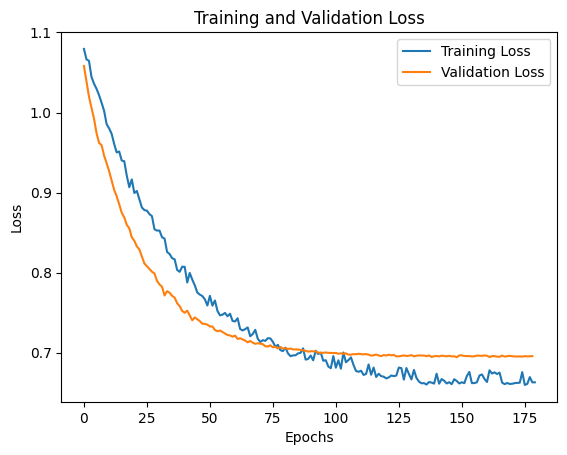

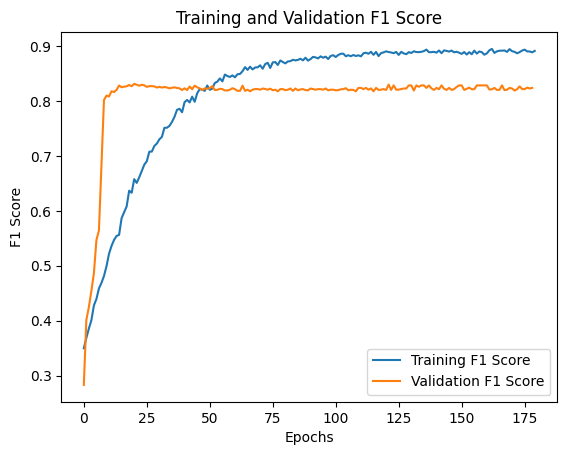

In [ ]:
# Initialize MetaClassifier and move to device
CNN_1D = CNN_1d().to(device)

# HP definition
num_epochs = 200
batch_size = 256
lr = 1e-5
weight_decay = 1e-3
model_path = "CNN.pth"

# Training loop
train_metaclassifier(CNN_1D, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

A bit of overfitting can be seen by means of the two plots above. The model's generalization capabilities seems to find a plateau pretty early in the training loop, but this is probably due to the simplicity of the input tensor.

In [ ]:
CNN_model = CNN_1d()
CNN_model.load_state_dict(torch.load(model_path))
CNN_model = CNN_model.to(device)

evaluate_metaclassifier(CNN_model, test_dataset)


Test Loss: 0.6696648697058359
Test Macro F1 Score: 0.8612525139819286
Test Weighted F1 Score: [0.87992989 0.89598452 0.80784314]
Test Accuracy: 0.8789671866594944
